# Setup

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


'ghp_z(HayhkIaeF11Invg1KGWKjWYvfi150358zH'

ghp_z(HayhkIaeF11Invg1KGWKjWYvfi150358zH

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Emotion vgg cnn + training monitor callback

In [2]:
# UNDERFITTING - occurs when the model cannot obtain a low enough loss on the training set => model fails to learn the underlying patters in the training data

# OVERFITTING - where network models the training data too well + fails to generalize to the validation data

# goal is to reduce training loss + ensure gap between training & testing loss is small

# control fitting by adjusting CAPACITY of the network
    # increase it by adding layers + neurons => reach "optimal" of network
    # decrease it by removing layers & neurons + using regularization methods

# training & validation loss/accuracy start to diverge from each other => noticeable gap => GOAL is to limit the gap => preserve the generalizability of the model
    # if gap isnt limited => "OVERFITTING ZONE" => training loss will either stagnate/continue to drop + validation loss stagnates & increases (heavy indicator of overfitting)

# combat overfitting? reduce complexity (less layers & neurons) + applying regularization methods (weight decay, dropout, data augmentation)

# import the necessary packages
from keras.callbacks import BaseLogger # used to create a class that logs the losses & acccuracy to the disk
import matplotlib.pyplot as plt
import numpy as np
import json
import os

class TrainingMonitor(BaseLogger):

    def __init__(self, figPath, jsonPath=None, startAt=0):
    
        # figPath = path to output plot thay can be used to visualize loss & accuracy over time
        # jsonPath = path used to serialize the loss & accuracy values as a JSON file (useful to see the training history to create custome plots)
        # startAt = staring epoch that training is resumed at using ctrl + c training
        
        
        # store the output path for the figure, the path to the JSON serialized file, and the starting epoch
        super(TrainingMonitor, self).__init__()
        self.figPath = figPath
        self.jsonPath = jsonPath
        self.startAt = startAt
        
    def on_train_begin(self, logs={}):
    
        # initialize the history dictionary ("history" of losses)
        self.H = {}
     
        # if the JSON history path exists, load the training history
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.H = json.loads(open(self.jsonPath).read())
               
                # check to see if a starting epoch was supplied
                if self.startAt > 0:
                    # loop over the entries in the history log and trim any entries that are past the starting epoch
                    for k in self.H.keys():
                         self.H[k] = self.H[k][:self.startAt]

    def on_epoch_end(self, epoch, logs={}): # is called when a training epoch completes
        # epoch = epoch #
        # logs = contains the training & validation loss + accuracy for current epoch
    
        # loop over the logs and update the loss, accuracy, etc. for the entire training process
        for (k, v) in logs.items():
            l = self.H.get(k, [])
            l.append(v)
            self.H[k] = l
            
            #after code is executed H has 4 keys (train_loss, train_accuracy, val_loss, val_accuracy) => a list is kept for each of the values => each list is updated after every epoch => plot an updated loss & accuracy curve as soon as the epoch completes
            
        # check to see if the training history should be serialized to file
        if self.jsonPath is not None:
            f = open(self.jsonPath, "w")
            f.write(json.dumps(self.H))
            f.close()

        # ensure at least two epochs have passed before plotting (epoch starts at zero)
        if len(self.H["loss"]) > 1:
            # plot the training loss and accuracy
            N = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(N, self.H["loss"], label="train_loss")
            plt.plot(N, self.H["val_loss"], label="val_loss")
            plt.plot(N, self.H["accuracy"], label="train_accuracy")
            plt.plot(N, self.H["val_accuracy"], label="val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.H["loss"])))
            plt.xlabel("Epoch Number")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            
            # save the figure
            plt.savefig(self.figPath)
            plt.close()

In [3]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ELU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

# Initial cu matrice de confuzie si best model save

Rezultatele se vor gasi in outputs/output1

Modelul cel mai bun se salveaza in folder-ul checkpoint.



---



ANTRENARE

Aici se antreneaza setul de date de train si de validation.

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output1'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 318s 10s/step - loss: 1.9945 - accuracy: 0.3531 - val_loss: 4.6547 - val_accuracy: 0.1875
Epoch 2/50
 4/33 [==>...........................] - ETA: 21s - loss: 1.6300 - accuracy: 0.4102

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.4075 - accuracy: 0.4740 - val_loss: 2.7606 - val_accuracy: 0.2871
Epoch 3/50
11/33 [=========>....................] - ETA: 15s - loss: 1.2375 - accuracy: 0.5207

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.2206 - accuracy: 0.5372 - val_loss: 2.0951 - val_accuracy: 0.3281
Epoch 4/50
29/33 [=========================>....] - ETA: 2s - loss: 1.0370 - accuracy: 0.6073

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 1.0439 - accuracy: 0.6032 - val_loss: 1.6984 - val_accuracy: 0.3535
Epoch 5/50
18/33 [===============>..............] - ETA: 11s - loss: 0.9561 - accuracy: 0.6347

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.9684 - accuracy: 0.6328 - val_loss: 1.6858 - val_accuracy: 0.3984
Epoch 6/50
27/33 [=======================>......] - ETA: 4s - loss: 0.8978 - accuracy: 0.6555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 923ms/step - loss: 0.8885 - accuracy: 0.6583 - val_loss: 0.9846 - val_accuracy: 0.6504
Epoch 7/50
24/33 [====================>.........] - ETA: 6s - loss: 0.8318 - accuracy: 0.6831

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.8387 - accuracy: 0.6821 - val_loss: 1.2015 - val_accuracy: 0.5430
Epoch 8/50
 1/33 [..............................] - ETA: 26s - loss: 0.8143 - accuracy: 0.6953

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 902ms/step - loss: 0.7386 - accuracy: 0.7171 - val_loss: 0.8965 - val_accuracy: 0.6602
Epoch 9/50
33/33 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.7317

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint/assets
33/33 [==============================] - 30s 903ms/step - loss: 0.6976 - accuracy: 0.7317 - val_loss: 0.8105 - val_accuracy: 0.6836
Epoch 10/50
 5/33 [===>..........................] - ETA: 21s - loss: 0.7126 - accuracy: 0.7328

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.6982 - accuracy: 0.7254 - val_loss: 0.7495 - val_accuracy: 0.7246
Epoch 11/50
31/33 [===========================>..] - ETA: 1s - loss: 0.6639 - accuracy: 0.7457

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.6637 - accuracy: 0.7448 - val_loss: 0.7505 - val_accuracy: 0.7031
Epoch 12/50
24/33 [====================>.........] - ETA: 6s - loss: 0.6207 - accuracy: 0.7663

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 0.6286 - accuracy: 0.7615 - val_loss: 0.6864 - val_accuracy: 0.7480
Epoch 13/50
22/33 [===================>..........] - ETA: 8s - loss: 0.5937 - accuracy: 0.7670

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.6046 - accuracy: 0.7603 - val_loss: 0.8924 - val_accuracy: 0.7188
Epoch 14/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5796 - accuracy: 0.7823

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 900ms/step - loss: 0.5738 - accuracy: 0.7841 - val_loss: 0.6395 - val_accuracy: 0.7695
Epoch 15/50
28/33 [========================>.....] - ETA: 3s - loss: 0.5511 - accuracy: 0.7829

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.5557 - accuracy: 0.7814 - val_loss: 0.6471 - val_accuracy: 0.7559
Epoch 16/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5371 - accuracy: 0.7953

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 895ms/step - loss: 0.5363 - accuracy: 0.7967 - val_loss: 0.6606 - val_accuracy: 0.7852
Epoch 17/50
19/33 [================>.............] - ETA: 10s - loss: 0.5241 - accuracy: 0.8035

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.5193 - accuracy: 0.7994 - val_loss: 0.6623 - val_accuracy: 0.7461
Epoch 18/50
17/33 [==============>...............] - ETA: 11s - loss: 0.5200 - accuracy: 0.8082

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.4959 - accuracy: 0.8184 - val_loss: 0.6913 - val_accuracy: 0.7695
Epoch 19/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.4300 - accuracy: 0.8241

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.4783 - accuracy: 0.8099 - val_loss: 0.6944 - val_accuracy: 0.7480
Epoch 20/50
23/33 [===================>..........] - ETA: 7s - loss: 0.4424 - accuracy: 0.8326

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 790ms/step - loss: 0.4415 - accuracy: 0.8329 - val_loss: 0.7012 - val_accuracy: 0.7500
Epoch 21/50
 3/33 [=>............................] - ETA: 21s - loss: 0.4373 - accuracy: 0.8307

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.4538 - accuracy: 0.8273 - val_loss: 0.6397 - val_accuracy: 0.7598
Epoch 22/50
11/33 [=========>....................] - ETA: 14s - loss: 0.4037 - accuracy: 0.8410

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.4313 - accuracy: 0.8305 - val_loss: 0.6953 - val_accuracy: 0.7754
Epoch 23/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3917 - accuracy: 0.8483

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 895ms/step - loss: 0.3922 - accuracy: 0.8504 - val_loss: 0.5636 - val_accuracy: 0.8145
Epoch 24/50
13/33 [==========>...................] - ETA: 15s - loss: 0.3702 - accuracy: 0.8552

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.3958 - accuracy: 0.8477 - val_loss: 0.8663 - val_accuracy: 0.7480
Epoch 25/50
15/33 [============>.................] - ETA: 13s - loss: 0.3994 - accuracy: 0.8542

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.3803 - accuracy: 0.8594 - val_loss: 0.6550 - val_accuracy: 0.7969
Epoch 26/50
15/33 [============>.................] - ETA: 13s - loss: 0.3398 - accuracy: 0.8797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.3653 - accuracy: 0.8672 - val_loss: 0.7422 - val_accuracy: 0.7988
Epoch 27/50
 1/33 [..............................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8828

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3288 - accuracy: 0.8766 - val_loss: 0.7495 - val_accuracy: 0.7988
Epoch 28/50
 3/33 [=>............................] - ETA: 23s - loss: 0.3276 - accuracy: 0.8880

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3129 - accuracy: 0.8830 - val_loss: 0.8097 - val_accuracy: 0.8145
Epoch 29/50
19/33 [================>.............] - ETA: 10s - loss: 0.3059 - accuracy: 0.8869

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.3267 - accuracy: 0.8766 - val_loss: 1.2650 - val_accuracy: 0.7148
Epoch 30/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2842 - accuracy: 0.8977

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3367 - accuracy: 0.8791 - val_loss: 0.8743 - val_accuracy: 0.7441
Epoch 31/50
19/33 [================>.............] - ETA: 10s - loss: 0.3053 - accuracy: 0.8942

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3199 - accuracy: 0.8861 - val_loss: 0.9820 - val_accuracy: 0.7852
Epoch 32/50
20/33 [=================>............] - ETA: 9s - loss: 0.3156 - accuracy: 0.8810

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 886ms/step - loss: 0.3092 - accuracy: 0.8822 - val_loss: 0.6467 - val_accuracy: 0.8223
Epoch 33/50
26/33 [======================>.......] - ETA: 5s - loss: 0.2901 - accuracy: 0.8914

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.2819 - accuracy: 0.8958 - val_loss: 1.1725 - val_accuracy: 0.7559
Epoch 34/50
20/33 [=================>............] - ETA: 9s - loss: 0.2585 - accuracy: 0.9083

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2664 - accuracy: 0.9021 - val_loss: 0.6042 - val_accuracy: 0.8066
Epoch 35/50
18/33 [===============>..............] - ETA: 11s - loss: 0.2437 - accuracy: 0.9123

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2434 - accuracy: 0.9136 - val_loss: 0.6181 - val_accuracy: 0.8105
Epoch 36/50
25/33 [=====================>........] - ETA: 5s - loss: 0.2480 - accuracy: 0.9118

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2477 - accuracy: 0.9099 - val_loss: 0.7299 - val_accuracy: 0.7852
Epoch 37/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2263 - accuracy: 0.9091

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.2285 - accuracy: 0.9102 - val_loss: 0.7616 - val_accuracy: 0.8027
Epoch 38/50
32/33 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9120

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2287 - accuracy: 0.9119 - val_loss: 0.8762 - val_accuracy: 0.7910
Epoch 39/50
13/33 [==========>...................] - ETA: 14s - loss: 0.2190 - accuracy: 0.9213

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.2282 - accuracy: 0.9126 - val_loss: 2.2384 - val_accuracy: 0.7793
Epoch 40/50
13/33 [==========>...................] - ETA: 14s - loss: 0.1918 - accuracy: 0.9261

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 930ms/step - loss: 0.1999 - accuracy: 0.9261 - val_loss: 0.6422 - val_accuracy: 0.8301
Epoch 41/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.2296 - accuracy: 0.9199

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.2116 - accuracy: 0.9254 - val_loss: 0.6020 - val_accuracy: 0.8086
Epoch 42/50
28/33 [========================>.....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9255

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2124 - accuracy: 0.9252 - val_loss: 0.5887 - val_accuracy: 0.8145
Epoch 43/50
11/33 [=========>....................] - ETA: 16s - loss: 0.2392 - accuracy: 0.9119

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.2158 - accuracy: 0.9182 - val_loss: 0.6677 - val_accuracy: 0.8145
Epoch 44/50
 9/33 [=======>......................] - ETA: 17s - loss: 0.1577 - accuracy: 0.9436

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.1828 - accuracy: 0.9335 - val_loss: 0.7700 - val_accuracy: 0.7930
Epoch 45/50
 3/33 [=>............................] - ETA: 23s - loss: 0.1914 - accuracy: 0.9323

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2065 - accuracy: 0.9230 - val_loss: 1.8823 - val_accuracy: 0.6973
Epoch 46/50
21/33 [==================>...........] - ETA: 8s - loss: 0.1864 - accuracy: 0.9326

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.1849 - accuracy: 0.9342 - val_loss: 1.3424 - val_accuracy: 0.7500
Epoch 47/50
20/33 [=================>............] - ETA: 9s - loss: 0.1659 - accuracy: 0.9387 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.1718 - accuracy: 0.9378 - val_loss: 0.7285 - val_accuracy: 0.8066
Epoch 48/50
16/33 [=============>................] - ETA: 12s - loss: 0.1566 - accuracy: 0.9414

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1664 - accuracy: 0.9407 - val_loss: 0.6340 - val_accuracy: 0.8086
Epoch 49/50
13/33 [==========>...................] - ETA: 13s - loss: 0.1704 - accuracy: 0.9390

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1785 - accuracy: 0.9347 - val_loss: 0.6784 - val_accuracy: 0.8184
Epoch 50/50
15/33 [============>.................] - ETA: 12s - loss: 0.1459 - accuracy: 0.9449

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.1610 - accuracy: 0.9400 - val_loss: 0.6218 - val_accuracy: 0.8105




---



TESTARE

Aici se va testa setul de date test. Se va vedea acuratetea modelului folosit preluat in urma testarii si obtinerii celui mai bun model.

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output1/checkpoint...
4/4 [==============================] - 144s 48s/step - loss: 0.5977 - accuracy: 0.8242
              precision    recall  f1-score   support

           0       0.14      0.14      0.14        96
           1       0.12      0.12      0.12        81
           2       0.21      0.19      0.20        99
           3       0.20      0.23      0.22        94
           4       0.20      0.19      0.20        88
           5       0.17      0.17      0.17        82

    accuracy                           0.18       540
   macro avg       0.17      0.17      0.17       540
weighted avg       0.18      0.18      0.18       540

[INFO] accuracy: 82.42


Matrice de confuzie



In [ ]:
%matplotlib inline
plt.close('all')

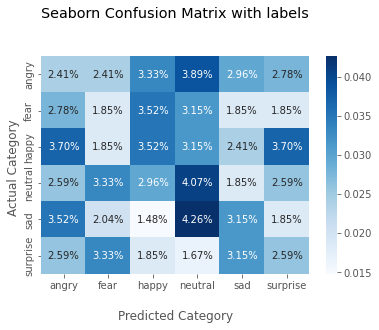

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Schimbare set de date de testare cu cel de validare

Se vor inversa caile in cod pentru cele doua seturi de dateb intre ele. 

Iesirea se va putea vizualiza in outputs/output2, iar cel mai bun model este salvat in checkpoint



---



ANTRENAREA

se va pune in loc de calea /val, /test.

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output2'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output2/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition2.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 540 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 540 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
25/33 [=====================>........] - ETA: 5s - loss: 2.0735 - accuracy: 0.3416

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 905ms/step - loss: 1.9767 - accuracy: 0.3567 - val_loss: 4.9276 - val_accuracy: 0.1875
Epoch 2/50
20/33 [=================>............] - ETA: 9s - loss: 1.4478 - accuracy: 0.4597 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 1.3968 - accuracy: 0.4743 - val_loss: 3.1309 - val_accuracy: 0.3184
Epoch 3/50
23/33 [===================>..........] - ETA: 7s - loss: 1.2180 - accuracy: 0.5363

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 915ms/step - loss: 1.1980 - accuracy: 0.5427 - val_loss: 1.5160 - val_accuracy: 0.4707
Epoch 4/50
14/33 [===========>..................] - ETA: 14s - loss: 1.0864 - accuracy: 0.5854

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 1.0769 - accuracy: 0.5884 - val_loss: 1.2814 - val_accuracy: 0.5039
Epoch 5/50
31/33 [===========================>..] - ETA: 1s - loss: 0.9323 - accuracy: 0.6406

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 0.9282 - accuracy: 0.6421 - val_loss: 1.3152 - val_accuracy: 0.5605
Epoch 6/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.8203 - accuracy: 0.6797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.8678 - accuracy: 0.6612 - val_loss: 1.1923 - val_accuracy: 0.5664
Epoch 7/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.8606 - accuracy: 0.6504

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.8136 - accuracy: 0.6884 - val_loss: 1.2535 - val_accuracy: 0.5449
Epoch 8/50
 6/33 [====>.........................] - ETA: 19s - loss: 0.7873 - accuracy: 0.7083

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.8045 - accuracy: 0.6904 - val_loss: 1.0142 - val_accuracy: 0.6406
Epoch 9/50
14/33 [===========>..................] - ETA: 13s - loss: 0.7007 - accuracy: 0.7378

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.7084 - accuracy: 0.7334 - val_loss: 0.8551 - val_accuracy: 0.6797
Epoch 10/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.7122 - accuracy: 0.7266

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.6819 - accuracy: 0.7336 - val_loss: 0.9345 - val_accuracy: 0.6543
Epoch 11/50
11/33 [=========>....................] - ETA: 16s - loss: 0.6100 - accuracy: 0.7599

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 897ms/step - loss: 0.6251 - accuracy: 0.7516 - val_loss: 0.7465 - val_accuracy: 0.7090
Epoch 12/50
11/33 [=========>....................] - ETA: 16s - loss: 0.6212 - accuracy: 0.7472

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.6083 - accuracy: 0.7644 - val_loss: 0.8740 - val_accuracy: 0.6855
Epoch 13/50
20/33 [=================>............] - ETA: 9s - loss: 0.5582 - accuracy: 0.7840 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 888ms/step - loss: 0.5654 - accuracy: 0.7810 - val_loss: 0.7878 - val_accuracy: 0.7246
Epoch 14/50
21/33 [==================>...........] - ETA: 9s - loss: 0.5323 - accuracy: 0.7946

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 904ms/step - loss: 0.5392 - accuracy: 0.7950 - val_loss: 0.7085 - val_accuracy: 0.7480
Epoch 15/50
13/33 [==========>...................] - ETA: 15s - loss: 0.5243 - accuracy: 0.7975

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.5247 - accuracy: 0.7970 - val_loss: 0.6853 - val_accuracy: 0.7598
Epoch 16/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.4942 - accuracy: 0.8138

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.5080 - accuracy: 0.8045 - val_loss: 0.6495 - val_accuracy: 0.7793
Epoch 17/50
22/33 [===================>..........] - ETA: 8s - loss: 0.4738 - accuracy: 0.8271

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.4967 - accuracy: 0.8157 - val_loss: 0.7278 - val_accuracy: 0.7324
Epoch 18/50
30/33 [==========================>...] - ETA: 2s - loss: 0.4904 - accuracy: 0.8115

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.4833 - accuracy: 0.8152 - val_loss: 0.6793 - val_accuracy: 0.7754
Epoch 19/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.4356 - accuracy: 0.8464

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.4350 - accuracy: 0.8414 - val_loss: 0.8032 - val_accuracy: 0.7383
Epoch 20/50
 1/33 [..............................] - ETA: 26s - loss: 0.4378 - accuracy: 0.8516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 900ms/step - loss: 0.4435 - accuracy: 0.8286 - val_loss: 0.6277 - val_accuracy: 0.7812
Epoch 21/50
10/33 [========>.....................] - ETA: 17s - loss: 0.3942 - accuracy: 0.8617

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.4004 - accuracy: 0.8480 - val_loss: 0.8564 - val_accuracy: 0.7402
Epoch 22/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.3694 - accuracy: 0.8605

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 895ms/step - loss: 0.3872 - accuracy: 0.8543 - val_loss: 0.8066 - val_accuracy: 0.7910
Epoch 23/50
16/33 [=============>................] - ETA: 13s - loss: 0.3655 - accuracy: 0.8643

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.3760 - accuracy: 0.8570 - val_loss: 0.6651 - val_accuracy: 0.7930
Epoch 24/50
10/33 [========>.....................] - ETA: 15s - loss: 0.3891 - accuracy: 0.8484

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.3846 - accuracy: 0.8485 - val_loss: 0.6832 - val_accuracy: 0.8008
Epoch 25/50
20/33 [=================>............] - ETA: 9s - loss: 0.3536 - accuracy: 0.8676 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.3646 - accuracy: 0.8623 - val_loss: 0.6116 - val_accuracy: 0.7871
Epoch 26/50
25/33 [=====================>........] - ETA: 5s - loss: 0.3550 - accuracy: 0.8662

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 911ms/step - loss: 0.3556 - accuracy: 0.8657 - val_loss: 0.6880 - val_accuracy: 0.8145
Epoch 27/50
29/33 [=========================>....] - ETA: 3s - loss: 0.3199 - accuracy: 0.8782

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.3203 - accuracy: 0.8788 - val_loss: 0.6263 - val_accuracy: 0.8145
Epoch 28/50
25/33 [=====================>........] - ETA: 5s - loss: 0.3323 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.3240 - accuracy: 0.8762 - val_loss: 0.8193 - val_accuracy: 0.7637
Epoch 29/50
 7/33 [=====>........................] - ETA: 21s - loss: 0.3366 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3248 - accuracy: 0.8754 - val_loss: 2.3454 - val_accuracy: 0.7168
Epoch 30/50
16/33 [=============>................] - ETA: 12s - loss: 0.2949 - accuracy: 0.8867

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 904ms/step - loss: 0.3127 - accuracy: 0.8805 - val_loss: 0.5596 - val_accuracy: 0.8340
Epoch 31/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9258

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.3119 - accuracy: 0.8849 - val_loss: 1.1043 - val_accuracy: 0.7852
Epoch 32/50
16/33 [=============>................] - ETA: 11s - loss: 0.2841 - accuracy: 0.8903

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.3036 - accuracy: 0.8815 - val_loss: 0.6360 - val_accuracy: 0.8008
Epoch 33/50
33/33 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.8953

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.2763 - accuracy: 0.8953 - val_loss: 0.7756 - val_accuracy: 0.7812
Epoch 34/50
25/33 [=====================>........] - ETA: 5s - loss: 0.2630 - accuracy: 0.9008

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2700 - accuracy: 0.8975 - val_loss: 0.5877 - val_accuracy: 0.8320
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2673 - accuracy: 0.8995 - val_loss: 0.7183 - val_accuracy: 0.8027
Epoch 36/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2414 - accuracy: 0.9039

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2412 - accuracy: 0.9070 - val_loss: 0.7108 - val_accuracy: 0.7988
Epoch 37/50
 3/33 [=>............................] - ETA: 21s - loss: 0.2404 - accuracy: 0.9062

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2472 - accuracy: 0.9106 - val_loss: 0.6116 - val_accuracy: 0.8262
Epoch 38/50
12/33 [=========>....................] - ETA: 15s - loss: 0.1974 - accuracy: 0.9277

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 814ms/step - loss: 0.2789 - accuracy: 0.8898 - val_loss: 1.1791 - val_accuracy: 0.7109
Epoch 39/50
30/33 [==========================>...] - ETA: 2s - loss: 0.2870 - accuracy: 0.8915

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.2878 - accuracy: 0.8917 - val_loss: 0.8695 - val_accuracy: 0.7910
Epoch 40/50
15/33 [============>.................] - ETA: 13s - loss: 0.2622 - accuracy: 0.9021

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2620 - accuracy: 0.8944 - val_loss: 0.7095 - val_accuracy: 0.8125
Epoch 41/50
21/33 [==================>...........] - ETA: 8s - loss: 0.2294 - accuracy: 0.9129

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.2305 - accuracy: 0.9089 - val_loss: 0.7641 - val_accuracy: 0.7715
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.1970 - accuracy: 0.9288 - val_loss: 0.7078 - val_accuracy: 0.8145
Epoch 43/50
18/33 [===============>..............] - ETA: 10s - loss: 0.1729 - accuracy: 0.9377

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.1836 - accuracy: 0.9337 - val_loss: 0.7354 - val_accuracy: 0.8145
Epoch 44/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.1769 - accuracy: 0.9385

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.1825 - accuracy: 0.9328 - val_loss: 0.6707 - val_accuracy: 0.8281
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 890ms/step - loss: 0.1730 - accuracy: 0.9349 - val_loss: 0.6312 - val_accuracy: 0.8398
Epoch 46/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.1646 - accuracy: 0.9466

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.1724 - accuracy: 0.9393 - val_loss: 1.8691 - val_accuracy: 0.7793
Epoch 47/50
16/33 [=============>................] - ETA: 12s - loss: 0.2251 - accuracy: 0.9109

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2038 - accuracy: 0.9218 - val_loss: 0.8057 - val_accuracy: 0.8105
Epoch 48/50
22/33 [===================>..........] - ETA: 8s - loss: 0.1636 - accuracy: 0.9403

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.1646 - accuracy: 0.9407 - val_loss: 0.6190 - val_accuracy: 0.8242
Epoch 49/50
29/33 [=========================>....] - ETA: 2s - loss: 0.1715 - accuracy: 0.9321

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.1780 - accuracy: 0.9301 - val_loss: 1.5573 - val_accuracy: 0.7500
Epoch 50/50
29/33 [=========================>....] - ETA: 2s - loss: 0.1846 - accuracy: 0.9334

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.1850 - accuracy: 0.9335 - val_loss: 0.7851 - val_accuracy: 0.8066




---



TESTARE

Se va inlocui calea /test, cu /val.

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output2/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 529 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 529 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output2/checkpoint...
4/4 [==============================] - 2s 445ms/step - loss: 0.6506 - accuracy: 0.8047
              precision    recall  f1-score   support

           0       0.22      0.21      0.21        95
           1       0.16      0.11      0.13        79
           2       0.23      0.22      0.23        98
           3       0.17      0.20      0.18        92
           4       0.15      0.16      0.16        85
           5       0.17      0.19      0.18        80

    accuracy                           0.19       529
   macro avg       0.18      0.18      0.18       529
weighted avg       0.19      0.19      0.18       529

[INFO] accuracy: 80.47


Matricea de confuzie

In [ ]:
%matplotlib inline
plt.close('all')

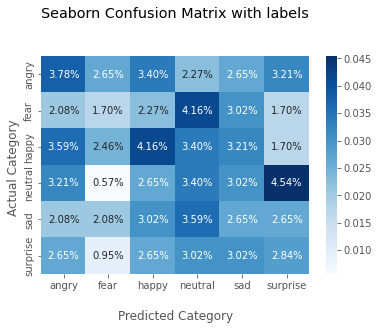

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()




---



# Schimbare ELU cu ReLU in EmotionVGG

SCHIMBARE IN EMOTIONVGG

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

Rezultatele in urma antrenarii vor fi afisate in outputs/output3

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output3'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output3/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition3.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition3.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
24/33 [====================>.........] - ETA: 6s - loss: 2.0323 - accuracy: 0.3327

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 916ms/step - loss: 1.9387 - accuracy: 0.3507 - val_loss: 3.9303 - val_accuracy: 0.1816
Epoch 2/50
 5/33 [===>..........................] - ETA: 21s - loss: 1.5011 - accuracy: 0.4422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 900ms/step - loss: 1.4542 - accuracy: 0.4565 - val_loss: 2.0714 - val_accuracy: 0.2383
Epoch 3/50
 1/33 [..............................] - ETA: 27s - loss: 1.2601 - accuracy: 0.5391

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 1.2283 - accuracy: 0.5396 - val_loss: 1.6320 - val_accuracy: 0.2832
Epoch 4/50
22/33 [===================>..........] - ETA: 8s - loss: 1.1097 - accuracy: 0.5871

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 1.1163 - accuracy: 0.5821 - val_loss: 1.6723 - val_accuracy: 0.3457
Epoch 5/50
18/33 [===============>..............] - ETA: 10s - loss: 1.0123 - accuracy: 0.6228

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 1.0150 - accuracy: 0.6207 - val_loss: 1.6940 - val_accuracy: 0.3164
Epoch 6/50
26/33 [======================>.......] - ETA: 5s - loss: 0.8941 - accuracy: 0.6713

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 880ms/step - loss: 0.9024 - accuracy: 0.6625 - val_loss: 1.4934 - val_accuracy: 0.4277
Epoch 7/50
18/33 [===============>..............] - ETA: 11s - loss: 0.8642 - accuracy: 0.6665

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 965ms/step - loss: 0.8289 - accuracy: 0.6802 - val_loss: 1.2460 - val_accuracy: 0.5117
Epoch 8/50
22/33 [===================>..........] - ETA: 8s - loss: 0.7327 - accuracy: 0.7234

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.7336 - accuracy: 0.7210 - val_loss: 1.3695 - val_accuracy: 0.4785
Epoch 9/50
29/33 [=========================>....] - ETA: 3s - loss: 0.7268 - accuracy: 0.7166

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 931ms/step - loss: 0.7262 - accuracy: 0.7190 - val_loss: 1.0503 - val_accuracy: 0.5898
Epoch 10/50
17/33 [==============>...............] - ETA: 11s - loss: 0.6795 - accuracy: 0.7298

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.6699 - accuracy: 0.7398 - val_loss: 1.1382 - val_accuracy: 0.5742
Epoch 11/50
14/33 [===========>..................] - ETA: 13s - loss: 0.6198 - accuracy: 0.7656

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.6223 - accuracy: 0.7602 - val_loss: 0.8591 - val_accuracy: 0.6758
Epoch 12/50
27/33 [=======================>......] - ETA: 4s - loss: 0.5924 - accuracy: 0.7675

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.5959 - accuracy: 0.7671 - val_loss: 0.7926 - val_accuracy: 0.6641
Epoch 13/50
17/33 [==============>...............] - ETA: 12s - loss: 0.5514 - accuracy: 0.7918

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 1s/step - loss: 0.5682 - accuracy: 0.7856 - val_loss: 0.7173 - val_accuracy: 0.7246
Epoch 14/50
12/33 [=========>....................] - ETA: 14s - loss: 0.5462 - accuracy: 0.7958

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 898ms/step - loss: 0.5547 - accuracy: 0.7868 - val_loss: 0.6945 - val_accuracy: 0.7285
Epoch 15/50
26/33 [======================>.......] - ETA: 5s - loss: 0.4676 - accuracy: 0.8197

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 895ms/step - loss: 0.4744 - accuracy: 0.8167 - val_loss: 0.6269 - val_accuracy: 0.7578
Epoch 16/50
31/33 [===========================>..] - ETA: 1s - loss: 0.4622 - accuracy: 0.8234

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.4761 - accuracy: 0.8179 - val_loss: 0.6767 - val_accuracy: 0.7363
Epoch 17/50
21/33 [==================>...........] - ETA: 8s - loss: 0.4587 - accuracy: 0.8296

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 888ms/step - loss: 0.4665 - accuracy: 0.8254 - val_loss: 0.6354 - val_accuracy: 0.7734
Epoch 18/50
26/33 [======================>.......] - ETA: 5s - loss: 0.4603 - accuracy: 0.8181

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 821ms/step - loss: 0.4655 - accuracy: 0.8191 - val_loss: 0.8188 - val_accuracy: 0.7266
Epoch 19/50
32/33 [============================>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.8301

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.4487 - accuracy: 0.8295 - val_loss: 0.5964 - val_accuracy: 0.7969
Epoch 20/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.3659 - accuracy: 0.8717

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.4113 - accuracy: 0.8443 - val_loss: 0.6459 - val_accuracy: 0.7754
Epoch 21/50
31/33 [===========================>..] - ETA: 1s - loss: 0.4149 - accuracy: 0.8402

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 812ms/step - loss: 0.4087 - accuracy: 0.8431 - val_loss: 0.5899 - val_accuracy: 0.7910
Epoch 22/50
22/33 [===================>..........] - ETA: 7s - loss: 0.3545 - accuracy: 0.8672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 898ms/step - loss: 0.3606 - accuracy: 0.8633 - val_loss: 0.5607 - val_accuracy: 0.8008
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3513 - accuracy: 0.8667 - val_loss: 0.6537 - val_accuracy: 0.7793
Epoch 24/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3626 - accuracy: 0.8675

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3675 - accuracy: 0.8647 - val_loss: 0.6206 - val_accuracy: 0.7910
Epoch 25/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3368 - accuracy: 0.8732

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.3323 - accuracy: 0.8735 - val_loss: 0.6370 - val_accuracy: 0.7793
Epoch 26/50
12/33 [=========>....................] - ETA: 15s - loss: 0.3183 - accuracy: 0.8853

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.3368 - accuracy: 0.8754 - val_loss: 0.5740 - val_accuracy: 0.7930
Epoch 27/50
11/33 [=========>....................] - ETA: 15s - loss: 0.2779 - accuracy: 0.8986

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.3192 - accuracy: 0.8783 - val_loss: 0.7179 - val_accuracy: 0.7578
Epoch 28/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.3070 - accuracy: 0.8898

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 963ms/step - loss: 0.3021 - accuracy: 0.8890 - val_loss: 0.5969 - val_accuracy: 0.8066
Epoch 29/50
20/33 [=================>............] - ETA: 10s - loss: 0.2963 - accuracy: 0.8879

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 851ms/step - loss: 0.3006 - accuracy: 0.8856 - val_loss: 0.8324 - val_accuracy: 0.7539
Epoch 30/50
25/33 [=====================>........] - ETA: 6s - loss: 0.2877 - accuracy: 0.8988

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.2799 - accuracy: 0.9004 - val_loss: 0.5936 - val_accuracy: 0.8066
Epoch 31/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2562 - accuracy: 0.9066

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.2661 - accuracy: 0.9021 - val_loss: 0.5990 - val_accuracy: 0.8125
Epoch 32/50
21/33 [==================>...........] - ETA: 8s - loss: 0.2740 - accuracy: 0.8970

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.2701 - accuracy: 0.9000 - val_loss: 0.6759 - val_accuracy: 0.8047
Epoch 33/50
12/33 [=========>....................] - ETA: 15s - loss: 0.2362 - accuracy: 0.9147

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2515 - accuracy: 0.9087 - val_loss: 0.8676 - val_accuracy: 0.7637
Epoch 34/50
15/33 [============>.................] - ETA: 13s - loss: 0.2648 - accuracy: 0.9031

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2666 - accuracy: 0.9019 - val_loss: 0.6220 - val_accuracy: 0.7871
Epoch 35/50
28/33 [========================>.....] - ETA: 3s - loss: 0.2543 - accuracy: 0.9060

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2594 - accuracy: 0.9036 - val_loss: 0.7781 - val_accuracy: 0.7852
Epoch 36/50
14/33 [===========>..................] - ETA: 13s - loss: 0.2339 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.2485 - accuracy: 0.9065 - val_loss: 0.6686 - val_accuracy: 0.7891
Epoch 37/50
24/33 [====================>.........] - ETA: 6s - loss: 0.2284 - accuracy: 0.9150

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2220 - accuracy: 0.9184 - val_loss: 0.6379 - val_accuracy: 0.8008
Epoch 38/50
24/33 [====================>.........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9167

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.2270 - accuracy: 0.9177 - val_loss: 1.4446 - val_accuracy: 0.6426
Epoch 39/50
 2/33 [>.............................] - ETA: 21s - loss: 0.2719 - accuracy: 0.9102

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2230 - accuracy: 0.9165 - val_loss: 0.9284 - val_accuracy: 0.7617
Epoch 40/50
 3/33 [=>............................] - ETA: 22s - loss: 0.1986 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.2084 - accuracy: 0.9179 - val_loss: 0.6996 - val_accuracy: 0.8203
Epoch 41/50
 3/33 [=>............................] - ETA: 21s - loss: 0.1704 - accuracy: 0.9453

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2014 - accuracy: 0.9262 - val_loss: 0.6402 - val_accuracy: 0.8145
Epoch 42/50
15/33 [============>.................] - ETA: 13s - loss: 0.2047 - accuracy: 0.9240

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 786ms/step - loss: 0.2048 - accuracy: 0.9240 - val_loss: 0.6128 - val_accuracy: 0.8047
Epoch 43/50
22/33 [===================>..........] - ETA: 8s - loss: 0.1972 - accuracy: 0.9339

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.1928 - accuracy: 0.9332 - val_loss: 0.6395 - val_accuracy: 0.8145
Epoch 44/50
20/33 [=================>............] - ETA: 9s - loss: 0.1724 - accuracy: 0.9348 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.1873 - accuracy: 0.9303 - val_loss: 2.4731 - val_accuracy: 0.7305
Epoch 45/50
32/33 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.9040

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2564 - accuracy: 0.9043 - val_loss: 0.9157 - val_accuracy: 0.7480
Epoch 46/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2277 - accuracy: 0.9219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.2186 - accuracy: 0.9228 - val_loss: 0.7131 - val_accuracy: 0.7891
Epoch 47/50
 7/33 [=====>........................] - ETA: 18s - loss: 0.2033 - accuracy: 0.9275

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.2064 - accuracy: 0.9235 - val_loss: 0.8864 - val_accuracy: 0.7676
Epoch 48/50
 3/33 [=>............................] - ETA: 23s - loss: 0.2142 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1844 - accuracy: 0.9274 - val_loss: 0.6662 - val_accuracy: 0.7734
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.1924 - accuracy: 0.9281 - val_loss: 0.7288 - val_accuracy: 0.7891
Epoch 50/50
 5/33 [===>..........................] - ETA: 16s - loss: 0.1765 - accuracy: 0.9307

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.1550 - accuracy: 0.9412 - val_loss: 0.6088 - val_accuracy: 0.8320




---



TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output3/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output3/checkpoint...
4/4 [==============================] - 2s 459ms/step - loss: 0.6139 - accuracy: 0.8301
              precision    recall  f1-score   support

           0       0.17      0.16      0.16        96
           1       0.12      0.14      0.13        81
           2       0.16      0.16      0.16        99
           3       0.17      0.16      0.16        94
           4       0.15      0.15      0.15        88
           5       0.14      0.13      0.14        82

    accuracy                           0.15       540
   macro avg       0.15      0.15      0.15       540
weighted avg       0.15      0.15      0.15       540

[INFO] accuracy: 83.01


Matrice de confuzie

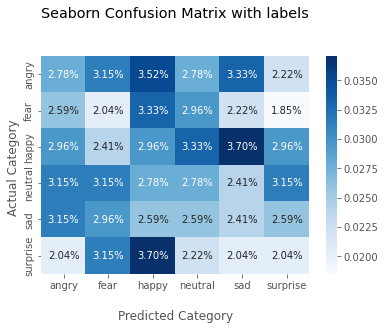

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Adaugarea unui nou strat in EmotionVGG

SCHIMBARE IN EMOTIONVGG

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ELU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ELU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #BLOC 5 - NOU ADAUGAT
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ELU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

Rezultatele vor fi afisate in outputs/output4.

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output4'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output4/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition4.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition4.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
15/33 [============>.................] - ETA: 12s - loss: 2.3678 - accuracy: 0.3010

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 937ms/step - loss: 2.1851 - accuracy: 0.3232 - val_loss: 11.5489 - val_accuracy: 0.1445
Epoch 2/50
21/33 [==================>...........] - ETA: 8s - loss: 1.7958 - accuracy: 0.3706

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 921ms/step - loss: 1.7529 - accuracy: 0.3902 - val_loss: 2.5017 - val_accuracy: 0.2793
Epoch 3/50
14/33 [===========>..................] - ETA: 14s - loss: 1.5776 - accuracy: 0.4319

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.5422 - accuracy: 0.4451 - val_loss: 1.6486 - val_accuracy: 0.3809
Epoch 4/50
22/33 [===================>..........] - ETA: 8s - loss: 1.3956 - accuracy: 0.4768

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 920ms/step - loss: 1.3752 - accuracy: 0.4886 - val_loss: 1.4628 - val_accuracy: 0.4375
Epoch 5/50
14/33 [===========>..................] - ETA: 12s - loss: 1.2241 - accuracy: 0.5451

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 1.2389 - accuracy: 0.5321 - val_loss: 1.6283 - val_accuracy: 0.4375
Epoch 6/50
14/33 [===========>..................] - ETA: 14s - loss: 1.1812 - accuracy: 0.5402

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 1.1307 - accuracy: 0.5576 - val_loss: 1.0290 - val_accuracy: 0.5957
Epoch 7/50
27/33 [=======================>......] - ETA: 4s - loss: 1.0784 - accuracy: 0.5854

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 1.0697 - accuracy: 0.5881 - val_loss: 0.9806 - val_accuracy: 0.5957
Epoch 8/50
18/33 [===============>..............] - ETA: 10s - loss: 0.9824 - accuracy: 0.6087

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.9605 - accuracy: 0.6226 - val_loss: 0.9421 - val_accuracy: 0.6309
Epoch 9/50
19/33 [================>.............] - ETA: 10s - loss: 0.9330 - accuracy: 0.6341

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.9168 - accuracy: 0.6442 - val_loss: 0.8026 - val_accuracy: 0.7031
Epoch 10/50
22/33 [===================>..........] - ETA: 8s - loss: 0.8764 - accuracy: 0.6672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.8612 - accuracy: 0.6714 - val_loss: 0.7032 - val_accuracy: 0.7168
Epoch 11/50
11/33 [=========>....................] - ETA: 15s - loss: 0.8296 - accuracy: 0.6797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.8381 - accuracy: 0.6785 - val_loss: 0.7863 - val_accuracy: 0.6875
Epoch 12/50
18/33 [===============>..............] - ETA: 10s - loss: 0.7707 - accuracy: 0.7034

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 924ms/step - loss: 0.7783 - accuracy: 0.7045 - val_loss: 0.6767 - val_accuracy: 0.7441
Epoch 13/50
21/33 [==================>...........] - ETA: 9s - loss: 0.7557 - accuracy: 0.6998

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.7550 - accuracy: 0.7035 - val_loss: 0.6591 - val_accuracy: 0.7402
Epoch 14/50
 1/33 [..............................] - ETA: 26s - loss: 0.7126 - accuracy: 0.7188

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 791ms/step - loss: 0.7391 - accuracy: 0.7142 - val_loss: 0.8124 - val_accuracy: 0.6836
Epoch 15/50
 3/33 [=>............................] - ETA: 22s - loss: 0.7259 - accuracy: 0.7240

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.7111 - accuracy: 0.7341 - val_loss: 0.7295 - val_accuracy: 0.7344
Epoch 16/50
19/33 [================>.............] - ETA: 10s - loss: 0.6545 - accuracy: 0.7516

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.6521 - accuracy: 0.7530 - val_loss: 0.6566 - val_accuracy: 0.7500
Epoch 17/50
26/33 [======================>.......] - ETA: 5s - loss: 0.6483 - accuracy: 0.7480

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 821ms/step - loss: 0.6437 - accuracy: 0.7516 - val_loss: 0.6761 - val_accuracy: 0.7402
Epoch 18/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5922 - accuracy: 0.7665

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 902ms/step - loss: 0.5899 - accuracy: 0.7674 - val_loss: 0.6450 - val_accuracy: 0.7578
Epoch 19/50
 6/33 [====>.........................] - ETA: 19s - loss: 0.5698 - accuracy: 0.7674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.5715 - accuracy: 0.7734 - val_loss: 0.8007 - val_accuracy: 0.6934
Epoch 20/50
24/33 [====================>.........] - ETA: 6s - loss: 0.5578 - accuracy: 0.7930

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.5605 - accuracy: 0.7931 - val_loss: 0.6955 - val_accuracy: 0.7363
Epoch 21/50
31/33 [===========================>..] - ETA: 1s - loss: 0.5361 - accuracy: 0.7911

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.5353 - accuracy: 0.7909 - val_loss: 0.7387 - val_accuracy: 0.7266
Epoch 22/50
28/33 [========================>.....] - ETA: 3s - loss: 0.5442 - accuracy: 0.7967

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.5395 - accuracy: 0.7980 - val_loss: 0.7335 - val_accuracy: 0.7363
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.5050 - accuracy: 0.8072 - val_loss: 0.7657 - val_accuracy: 0.7441
Epoch 24/50
 9/33 [=======>......................] - ETA: 16s - loss: 0.5049 - accuracy: 0.8011

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.4985 - accuracy: 0.8067 - val_loss: 0.7545 - val_accuracy: 0.7168
Epoch 25/50
 5/33 [===>..........................] - ETA: 19s - loss: 0.5191 - accuracy: 0.8000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.4910 - accuracy: 0.8137 - val_loss: 0.6380 - val_accuracy: 0.7676
Epoch 26/50
18/33 [===============>..............] - ETA: 11s - loss: 0.4471 - accuracy: 0.8212

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.4719 - accuracy: 0.8174 - val_loss: 0.6393 - val_accuracy: 0.7695
Epoch 27/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.4791 - accuracy: 0.8092

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.4469 - accuracy: 0.8273 - val_loss: 0.5756 - val_accuracy: 0.7891
Epoch 28/50
28/33 [========================>.....] - ETA: 3s - loss: 0.4117 - accuracy: 0.8440

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.4051 - accuracy: 0.8468 - val_loss: 0.6149 - val_accuracy: 0.7793
Epoch 29/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.4207 - accuracy: 0.8312

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 816ms/step - loss: 0.4124 - accuracy: 0.8407 - val_loss: 0.7375 - val_accuracy: 0.7520
Epoch 30/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.3809 - accuracy: 0.8531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.3856 - accuracy: 0.8519 - val_loss: 0.6696 - val_accuracy: 0.7617
Epoch 31/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.3953 - accuracy: 0.8469

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.3825 - accuracy: 0.8541 - val_loss: 0.5306 - val_accuracy: 0.8223
Epoch 32/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.3318 - accuracy: 0.8770

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.3859 - accuracy: 0.8516 - val_loss: 0.6226 - val_accuracy: 0.7969
Epoch 33/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3851 - accuracy: 0.8534

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.3910 - accuracy: 0.8514 - val_loss: 0.6242 - val_accuracy: 0.7930
Epoch 34/50
 3/33 [=>............................] - ETA: 21s - loss: 0.3480 - accuracy: 0.8724

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.3466 - accuracy: 0.8672 - val_loss: 0.6061 - val_accuracy: 0.8008
Epoch 35/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.2932 - accuracy: 0.8929

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.3363 - accuracy: 0.8723 - val_loss: 0.8266 - val_accuracy: 0.7480
Epoch 36/50
32/33 [============================>.] - ETA: 0s - loss: 0.3338 - accuracy: 0.8742

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.3334 - accuracy: 0.8745 - val_loss: 0.6679 - val_accuracy: 0.7871
Epoch 37/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3311 - accuracy: 0.8741

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.3203 - accuracy: 0.8781 - val_loss: 0.6634 - val_accuracy: 0.7871
Epoch 38/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.2707 - accuracy: 0.8984

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.2969 - accuracy: 0.8856 - val_loss: 0.6251 - val_accuracy: 0.7930
Epoch 39/50
31/33 [===========================>..] - ETA: 1s - loss: 0.2702 - accuracy: 0.8988

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.2706 - accuracy: 0.8983 - val_loss: 0.5967 - val_accuracy: 0.8066
Epoch 40/50
 3/33 [=>............................] - ETA: 12s - loss: 0.2493 - accuracy: 0.9029

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.2737 - accuracy: 0.8985 - val_loss: 0.7108 - val_accuracy: 0.7773
Epoch 41/50
15/33 [============>.................] - ETA: 13s - loss: 0.2793 - accuracy: 0.8896

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.2825 - accuracy: 0.8944 - val_loss: 0.6294 - val_accuracy: 0.8105
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2733 - accuracy: 0.8958 - val_loss: 0.6230 - val_accuracy: 0.8047
Epoch 43/50
 1/33 [..............................] - ETA: 24s - loss: 0.2314 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.2390 - accuracy: 0.9150 - val_loss: 0.6981 - val_accuracy: 0.7734
Epoch 44/50
10/33 [========>.....................] - ETA: 15s - loss: 0.2111 - accuracy: 0.9242

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.2268 - accuracy: 0.9160 - val_loss: 0.7317 - val_accuracy: 0.7734
Epoch 45/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2167 - accuracy: 0.9195

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.2226 - accuracy: 0.9206 - val_loss: 0.5953 - val_accuracy: 0.8008
Epoch 46/50
 9/33 [=======>......................] - ETA: 16s - loss: 0.2444 - accuracy: 0.9063

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2625 - accuracy: 0.9014 - val_loss: 0.6730 - val_accuracy: 0.8008
Epoch 47/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2709 - accuracy: 0.9070

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.2530 - accuracy: 0.9053 - val_loss: 0.6717 - val_accuracy: 0.7910
Epoch 48/50
21/33 [==================>...........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9070

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.2324 - accuracy: 0.9114 - val_loss: 0.6648 - val_accuracy: 0.8086
Epoch 49/50
 3/33 [=>............................] - ETA: 24s - loss: 0.2204 - accuracy: 0.9219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2208 - accuracy: 0.9153 - val_loss: 0.7587 - val_accuracy: 0.7871
Epoch 50/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.2069 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.2099 - accuracy: 0.9211 - val_loss: 0.6706 - val_accuracy: 0.7949




---



TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output4/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output4/checkpoint...
4/4 [==============================] - 2s 467ms/step - loss: 0.6089 - accuracy: 0.8066
              precision    recall  f1-score   support

           0       0.18      0.19      0.18        96
           1       0.17      0.14      0.15        81
           2       0.21      0.21      0.21        99
           3       0.14      0.14      0.14        94
           4       0.18      0.17      0.17        88
           5       0.22      0.27      0.24        82

    accuracy                           0.19       540
   macro avg       0.18      0.19      0.18       540
weighted avg       0.18      0.19      0.18       540

[INFO] accuracy: 80.66


Matrice de confuzie

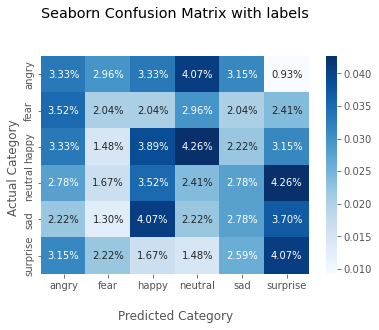

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Adaugarea unui nou strat si schimbarea ELU cu ReLU in EmotionVGG

SCHIMBARILE FACUTE IN EMOTION VGG

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #BLOC 5
        model.add(Dense(256, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

Rezultatele se vor salva in outputs/output5

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output5'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output5/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition5.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition5.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
 5/33 [===>..........................] - ETA: 20s - loss: 2.7401 - accuracy: 0.2328

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 924ms/step - loss: 2.3306 - accuracy: 0.2807 - val_loss: 2.1668 - val_accuracy: 0.1641
Epoch 2/50
31/33 [===========================>..] - ETA: 1s - loss: 1.8919 - accuracy: 0.3566

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 1.8829 - accuracy: 0.3594 - val_loss: 1.7588 - val_accuracy: 0.2969
Epoch 3/50
30/33 [==========================>...] - ETA: 2s - loss: 1.6189 - accuracy: 0.4130

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 1.6147 - accuracy: 0.4165 - val_loss: 2.0423 - val_accuracy: 0.2734
Epoch 4/50
15/33 [============>.................] - ETA: 12s - loss: 1.5023 - accuracy: 0.4592

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 908ms/step - loss: 1.4525 - accuracy: 0.4777 - val_loss: 1.7473 - val_accuracy: 0.3164
Epoch 5/50
26/33 [======================>.......] - ETA: 5s - loss: 1.3335 - accuracy: 0.5022

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 1.3296 - accuracy: 0.5034 - val_loss: 1.4621 - val_accuracy: 0.3945
Epoch 6/50
24/33 [====================>.........] - ETA: 6s - loss: 1.2187 - accuracy: 0.5472

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 1.2119 - accuracy: 0.5444 - val_loss: 1.8596 - val_accuracy: 0.3457
Epoch 7/50
 2/33 [>.............................] - ETA: 21s - loss: 1.1849 - accuracy: 0.5625

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 919ms/step - loss: 1.1169 - accuracy: 0.5610 - val_loss: 1.4763 - val_accuracy: 0.4375
Epoch 8/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.9803 - accuracy: 0.6107

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 1.0061 - accuracy: 0.6105 - val_loss: 1.5783 - val_accuracy: 0.4199
Epoch 9/50
14/33 [===========>..................] - ETA: 12s - loss: 0.9870 - accuracy: 0.6133

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 908ms/step - loss: 0.9767 - accuracy: 0.6163 - val_loss: 1.2882 - val_accuracy: 0.5176
Epoch 10/50
24/33 [====================>.........] - ETA: 6s - loss: 0.9165 - accuracy: 0.6288

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.9122 - accuracy: 0.6319 - val_loss: 1.2428 - val_accuracy: 0.4961
Epoch 11/50
 3/33 [=>............................] - ETA: 23s - loss: 0.7599 - accuracy: 0.6849

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 895ms/step - loss: 0.8354 - accuracy: 0.6649 - val_loss: 1.0880 - val_accuracy: 0.5605
Epoch 12/50
28/33 [========================>.....] - ETA: 3s - loss: 0.8076 - accuracy: 0.6889

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 915ms/step - loss: 0.8113 - accuracy: 0.6865 - val_loss: 0.9711 - val_accuracy: 0.6289
Epoch 13/50
16/33 [=============>................] - ETA: 13s - loss: 0.7668 - accuracy: 0.7031

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.7775 - accuracy: 0.6972 - val_loss: 0.9573 - val_accuracy: 0.5918
Epoch 14/50
24/33 [====================>.........] - ETA: 6s - loss: 0.7561 - accuracy: 0.7028

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.7539 - accuracy: 0.7030 - val_loss: 0.8734 - val_accuracy: 0.6680
Epoch 15/50
15/33 [============>.................] - ETA: 13s - loss: 0.7457 - accuracy: 0.7078

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 915ms/step - loss: 0.7312 - accuracy: 0.7169 - val_loss: 0.6765 - val_accuracy: 0.7207
Epoch 16/50
23/33 [===================>..........] - ETA: 7s - loss: 0.6841 - accuracy: 0.7242

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 0.6840 - accuracy: 0.7300 - val_loss: 0.6530 - val_accuracy: 0.7617
Epoch 17/50
18/33 [===============>..............] - ETA: 10s - loss: 0.6459 - accuracy: 0.7425

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.6643 - accuracy: 0.7380 - val_loss: 0.6607 - val_accuracy: 0.7363
Epoch 18/50
19/33 [================>.............] - ETA: 10s - loss: 0.6352 - accuracy: 0.7438

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.6537 - accuracy: 0.7455 - val_loss: 0.6117 - val_accuracy: 0.7559
Epoch 19/50
15/33 [============>.................] - ETA: 13s - loss: 0.6262 - accuracy: 0.7484

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.6114 - accuracy: 0.7581 - val_loss: 0.6648 - val_accuracy: 0.7383
Epoch 20/50
 3/33 [=>............................] - ETA: 21s - loss: 0.6362 - accuracy: 0.7682

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 905ms/step - loss: 0.5995 - accuracy: 0.7688 - val_loss: 0.5980 - val_accuracy: 0.7695
Epoch 21/50
17/33 [==============>...............] - ETA: 12s - loss: 0.5720 - accuracy: 0.7877

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.5730 - accuracy: 0.7846 - val_loss: 0.5980 - val_accuracy: 0.7539
Epoch 22/50
31/33 [===========================>..] - ETA: 1s - loss: 0.5514 - accuracy: 0.7786

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.5451 - accuracy: 0.7814 - val_loss: 0.6888 - val_accuracy: 0.7227
Epoch 23/50
27/33 [=======================>......] - ETA: 4s - loss: 0.5247 - accuracy: 0.7966

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.5349 - accuracy: 0.7943 - val_loss: 0.7375 - val_accuracy: 0.7090
Epoch 24/50
22/33 [===================>..........] - ETA: 8s - loss: 0.5586 - accuracy: 0.7830

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 792ms/step - loss: 0.5484 - accuracy: 0.7885 - val_loss: 0.5996 - val_accuracy: 0.7695
Epoch 25/50
15/33 [============>.................] - ETA: 13s - loss: 0.5264 - accuracy: 0.7990

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.5376 - accuracy: 0.7902 - val_loss: 0.7151 - val_accuracy: 0.7148
Epoch 26/50
 1/33 [..............................] - ETA: 24s - loss: 0.5433 - accuracy: 0.8047

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.5122 - accuracy: 0.8045 - val_loss: 0.6749 - val_accuracy: 0.7383
Epoch 27/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4605 - accuracy: 0.8322

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 0.4626 - accuracy: 0.8286 - val_loss: 0.5708 - val_accuracy: 0.7852
Epoch 28/50
17/33 [==============>...............] - ETA: 11s - loss: 0.4763 - accuracy: 0.8208

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.4790 - accuracy: 0.8142 - val_loss: 0.8525 - val_accuracy: 0.7090
Epoch 29/50
30/33 [==========================>...] - ETA: 2s - loss: 0.4305 - accuracy: 0.8315

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.4313 - accuracy: 0.8320 - val_loss: 0.5910 - val_accuracy: 0.7656
Epoch 30/50
24/33 [====================>.........] - ETA: 6s - loss: 0.4763 - accuracy: 0.8149

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.4701 - accuracy: 0.8191 - val_loss: 0.6779 - val_accuracy: 0.7520
Epoch 31/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.4341 - accuracy: 0.8404

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.4509 - accuracy: 0.8295 - val_loss: 0.9238 - val_accuracy: 0.6992
Epoch 32/50
19/33 [================>.............] - ETA: 10s - loss: 0.4049 - accuracy: 0.8396

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.4217 - accuracy: 0.8349 - val_loss: 0.7266 - val_accuracy: 0.7207
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.4563 - accuracy: 0.8239 - val_loss: 0.8608 - val_accuracy: 0.6777
Epoch 34/50
 6/33 [====>.........................] - ETA: 19s - loss: 0.4732 - accuracy: 0.8177

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.4890 - accuracy: 0.8152 - val_loss: 1.1631 - val_accuracy: 0.6602
Epoch 35/50
32/33 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8328

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 0.4253 - accuracy: 0.8338 - val_loss: 0.5875 - val_accuracy: 0.7949
Epoch 36/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3849 - accuracy: 0.8540

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.3920 - accuracy: 0.8502 - val_loss: 0.5847 - val_accuracy: 0.7949
Epoch 37/50
 7/33 [=====>........................] - ETA: 18s - loss: 0.3679 - accuracy: 0.8672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3953 - accuracy: 0.8456 - val_loss: 0.6550 - val_accuracy: 0.7754
Epoch 38/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.4065 - accuracy: 0.8498

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.4056 - accuracy: 0.8492 - val_loss: 0.8638 - val_accuracy: 0.7227
Epoch 39/50
27/33 [=======================>......] - ETA: 4s - loss: 0.3729 - accuracy: 0.8543

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.3746 - accuracy: 0.8553 - val_loss: 0.6115 - val_accuracy: 0.7969
Epoch 40/50
21/33 [==================>...........] - ETA: 9s - loss: 0.3375 - accuracy: 0.8731

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.3398 - accuracy: 0.8677 - val_loss: 0.6035 - val_accuracy: 0.7773
Epoch 41/50
19/33 [================>.............] - ETA: 10s - loss: 0.3277 - accuracy: 0.8725

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.3247 - accuracy: 0.8740 - val_loss: 0.5601 - val_accuracy: 0.7910
Epoch 42/50
31/33 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.8863

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.3072 - accuracy: 0.8844 - val_loss: 0.5867 - val_accuracy: 0.7930
Epoch 43/50
22/33 [===================>..........] - ETA: 8s - loss: 0.3026 - accuracy: 0.8815

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.3087 - accuracy: 0.8800 - val_loss: 0.8606 - val_accuracy: 0.6895
Epoch 44/50
 5/33 [===>..........................] - ETA: 22s - loss: 0.3452 - accuracy: 0.8781

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.3316 - accuracy: 0.8783 - val_loss: 0.6881 - val_accuracy: 0.7832
Epoch 45/50
20/33 [=================>............] - ETA: 9s - loss: 0.3204 - accuracy: 0.8798

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.3152 - accuracy: 0.8803 - val_loss: 0.5738 - val_accuracy: 0.8125
Epoch 46/50
20/33 [=================>............] - ETA: 9s - loss: 0.2770 - accuracy: 0.8918 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 903ms/step - loss: 0.2848 - accuracy: 0.8898 - val_loss: 0.5307 - val_accuracy: 0.8184
Epoch 47/50
13/33 [==========>...................] - ETA: 14s - loss: 0.2681 - accuracy: 0.8936

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.2808 - accuracy: 0.8910 - val_loss: 0.6054 - val_accuracy: 0.8027
Epoch 48/50
30/33 [==========================>...] - ETA: 2s - loss: 0.2752 - accuracy: 0.8961

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 790ms/step - loss: 0.2736 - accuracy: 0.8968 - val_loss: 0.6720 - val_accuracy: 0.7832
Epoch 49/50
22/33 [===================>..........] - ETA: 7s - loss: 0.2791 - accuracy: 0.8915

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2786 - accuracy: 0.8946 - val_loss: 0.6218 - val_accuracy: 0.7930
Epoch 50/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.2166 - accuracy: 0.9277

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.2608 - accuracy: 0.9038 - val_loss: 0.7913 - val_accuracy: 0.7305




---



TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output5/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output5/checkpoint...
4/4 [==============================] - 2s 453ms/step - loss: 0.6003 - accuracy: 0.8301
              precision    recall  f1-score   support

           0       0.20      0.19      0.19        96
           1       0.14      0.10      0.11        81
           2       0.14      0.13      0.13        99
           3       0.16      0.16      0.16        94
           4       0.17      0.18      0.18        88
           5       0.12      0.16      0.14        82

    accuracy                           0.15       540
   macro avg       0.15      0.15      0.15       540
weighted avg       0.15      0.15      0.15       540

[INFO] accuracy: 83.01


Matrice de confuzie

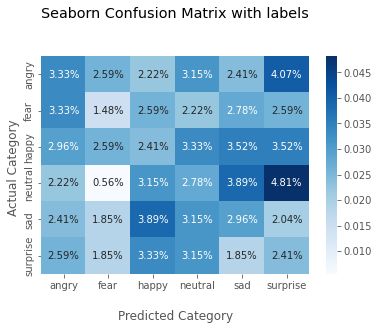

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Schimbarea numarului de neuroni din EmotionVGG la 512

SCHIMBARE IN EMOTIONVGG

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #BLOC 5
        model.add(Dense(512, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

Rezultatele se vor salva in outputs/output6.

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output6'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output6/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition6.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition6.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
16/33 [=============>................] - ETA: 11s - loss: 2.3985 - accuracy: 0.2868

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 935ms/step - loss: 2.2472 - accuracy: 0.3101 - val_loss: 2.4779 - val_accuracy: 0.2363
Epoch 2/50
32/33 [============================>.] - ETA: 0s - loss: 1.7750 - accuracy: 0.3915

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 1.7736 - accuracy: 0.3919 - val_loss: 2.2189 - val_accuracy: 0.2285
Epoch 3/50
 5/33 [===>..........................] - ETA: 20s - loss: 1.5041 - accuracy: 0.4437

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 908ms/step - loss: 1.5335 - accuracy: 0.4458 - val_loss: 2.1104 - val_accuracy: 0.2461
Epoch 4/50
29/33 [=========================>....] - ETA: 2s - loss: 1.4201 - accuracy: 0.4884

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 1.4065 - accuracy: 0.4898 - val_loss: 2.3762 - val_accuracy: 0.2559
Epoch 5/50
11/33 [=========>....................] - ETA: 15s - loss: 1.3347 - accuracy: 0.5138

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 917ms/step - loss: 1.2894 - accuracy: 0.5221 - val_loss: 2.3336 - val_accuracy: 0.2793
Epoch 6/50
13/33 [==========>...................] - ETA: 15s - loss: 1.1412 - accuracy: 0.5535

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 1.1110 - accuracy: 0.5682 - val_loss: 2.5096 - val_accuracy: 0.2754
Epoch 7/50
10/33 [========>.....................] - ETA: 17s - loss: 1.0568 - accuracy: 0.5930

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 919ms/step - loss: 1.0408 - accuracy: 0.6030 - val_loss: 1.6192 - val_accuracy: 0.3770
Epoch 8/50
 9/33 [=======>......................] - ETA: 17s - loss: 0.9597 - accuracy: 0.6272

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 936ms/step - loss: 1.0251 - accuracy: 0.6049 - val_loss: 1.5461 - val_accuracy: 0.4160
Epoch 9/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.9187 - accuracy: 0.6387

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 928ms/step - loss: 0.9129 - accuracy: 0.6413 - val_loss: 1.1481 - val_accuracy: 0.5645
Epoch 10/50
19/33 [================>.............] - ETA: 10s - loss: 0.8522 - accuracy: 0.6690

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 0.8572 - accuracy: 0.6642 - val_loss: 1.0025 - val_accuracy: 0.5977
Epoch 11/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.7927 - accuracy: 0.6875

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 925ms/step - loss: 0.8000 - accuracy: 0.6899 - val_loss: 0.8731 - val_accuracy: 0.6523
Epoch 12/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.8142 - accuracy: 0.6784

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 920ms/step - loss: 0.7296 - accuracy: 0.7088 - val_loss: 0.8173 - val_accuracy: 0.6660
Epoch 13/50
32/33 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.7216

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 918ms/step - loss: 0.6968 - accuracy: 0.7207 - val_loss: 0.7411 - val_accuracy: 0.6875
Epoch 14/50
16/33 [=============>................] - ETA: 13s - loss: 0.6473 - accuracy: 0.7461

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.6560 - accuracy: 0.7438 - val_loss: 0.6268 - val_accuracy: 0.7500
Epoch 15/50
 7/33 [=====>........................] - ETA: 18s - loss: 0.6409 - accuracy: 0.7701

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.6373 - accuracy: 0.7540 - val_loss: 0.7267 - val_accuracy: 0.7070
Epoch 16/50
30/33 [==========================>...] - ETA: 2s - loss: 0.6044 - accuracy: 0.7633

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.6109 - accuracy: 0.7603 - val_loss: 0.6920 - val_accuracy: 0.7480
Epoch 17/50
19/33 [================>.............] - ETA: 10s - loss: 0.5624 - accuracy: 0.7845

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 937ms/step - loss: 0.5615 - accuracy: 0.7801 - val_loss: 0.5828 - val_accuracy: 0.7812
Epoch 18/50
27/33 [=======================>......] - ETA: 4s - loss: 0.5381 - accuracy: 0.7940

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 825ms/step - loss: 0.5426 - accuracy: 0.7919 - val_loss: 1.0286 - val_accuracy: 0.7344
Epoch 19/50
11/33 [=========>....................] - ETA: 16s - loss: 0.5657 - accuracy: 0.7841

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 790ms/step - loss: 0.5679 - accuracy: 0.7795 - val_loss: 0.7044 - val_accuracy: 0.7383
Epoch 20/50
12/33 [=========>....................] - ETA: 14s - loss: 0.5467 - accuracy: 0.7874

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.5352 - accuracy: 0.7897 - val_loss: 0.6322 - val_accuracy: 0.7422
Epoch 21/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4878 - accuracy: 0.8134

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 918ms/step - loss: 0.4833 - accuracy: 0.8147 - val_loss: 0.5638 - val_accuracy: 0.8047
Epoch 22/50
12/33 [=========>....................] - ETA: 15s - loss: 0.4993 - accuracy: 0.8099

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.4854 - accuracy: 0.8113 - val_loss: 0.5933 - val_accuracy: 0.7773
Epoch 23/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4686 - accuracy: 0.8066

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.4676 - accuracy: 0.8067 - val_loss: 0.5807 - val_accuracy: 0.7891
Epoch 24/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.4254 - accuracy: 0.8457

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 801ms/step - loss: 0.4287 - accuracy: 0.8373 - val_loss: 0.8094 - val_accuracy: 0.7402
Epoch 25/50
 2/33 [>.............................] - ETA: 24s - loss: 0.4429 - accuracy: 0.8398

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.4227 - accuracy: 0.8383 - val_loss: 0.6637 - val_accuracy: 0.7676
Epoch 26/50
17/33 [==============>...............] - ETA: 12s - loss: 0.4011 - accuracy: 0.8497

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.3938 - accuracy: 0.8541 - val_loss: 0.6290 - val_accuracy: 0.7754
Epoch 27/50
33/33 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8356

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.4159 - accuracy: 0.8356 - val_loss: 0.7614 - val_accuracy: 0.7266
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.4253 - accuracy: 0.8388 - val_loss: 0.6211 - val_accuracy: 0.7949
Epoch 29/50
 2/33 [>.............................] - ETA: 21s - loss: 0.3609 - accuracy: 0.8672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.3812 - accuracy: 0.8533 - val_loss: 0.5795 - val_accuracy: 0.8086
Epoch 30/50
18/33 [===============>..............] - ETA: 11s - loss: 0.3821 - accuracy: 0.8508

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.4053 - accuracy: 0.8470 - val_loss: 0.6689 - val_accuracy: 0.7852
Epoch 31/50
29/33 [=========================>....] - ETA: 2s - loss: 0.3825 - accuracy: 0.8566

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 816ms/step - loss: 0.3849 - accuracy: 0.8562 - val_loss: 0.6714 - val_accuracy: 0.7656
Epoch 32/50
16/33 [=============>................] - ETA: 12s - loss: 0.3548 - accuracy: 0.8623

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.3703 - accuracy: 0.8533 - val_loss: 0.7038 - val_accuracy: 0.7383
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.3561 - accuracy: 0.8594 - val_loss: 0.7318 - val_accuracy: 0.7578
Epoch 34/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3461 - accuracy: 0.8698

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.3460 - accuracy: 0.8698 - val_loss: 0.5945 - val_accuracy: 0.8008
Epoch 35/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3233 - accuracy: 0.8813

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.3215 - accuracy: 0.8810 - val_loss: 0.6239 - val_accuracy: 0.7891
Epoch 36/50
33/33 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8832

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3086 - accuracy: 0.8832 - val_loss: 0.6497 - val_accuracy: 0.7969
Epoch 37/50
27/33 [=======================>......] - ETA: 4s - loss: 0.2930 - accuracy: 0.8893

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2960 - accuracy: 0.8868 - val_loss: 0.8750 - val_accuracy: 0.7402
Epoch 38/50
 1/33 [..............................] - ETA: 25s - loss: 0.3184 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 923ms/step - loss: 0.2901 - accuracy: 0.8837 - val_loss: 0.6086 - val_accuracy: 0.8164
Epoch 39/50
18/33 [===============>..............] - ETA: 11s - loss: 0.2600 - accuracy: 0.9015

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.2730 - accuracy: 0.8946 - val_loss: 0.6065 - val_accuracy: 0.8145
Epoch 40/50
20/33 [=================>............] - ETA: 9s - loss: 0.2840 - accuracy: 0.8924 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 920ms/step - loss: 0.2696 - accuracy: 0.8963 - val_loss: 0.6152 - val_accuracy: 0.8184
Epoch 41/50
12/33 [=========>....................] - ETA: 15s - loss: 0.2428 - accuracy: 0.9049

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.2508 - accuracy: 0.9038 - val_loss: 0.7813 - val_accuracy: 0.7598
Epoch 42/50
33/33 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8980

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2628 - accuracy: 0.8980 - val_loss: 0.6444 - val_accuracy: 0.8066
Epoch 43/50
20/33 [=================>............] - ETA: 9s - loss: 0.2492 - accuracy: 0.9000 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2459 - accuracy: 0.9031 - val_loss: 0.8136 - val_accuracy: 0.7383
Epoch 44/50
 1/33 [..............................] - ETA: 28s - loss: 0.2228 - accuracy: 0.9062

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2110 - accuracy: 0.9218 - val_loss: 0.6293 - val_accuracy: 0.8145
Epoch 45/50
22/33 [===================>..........] - ETA: 7s - loss: 0.2471 - accuracy: 0.9081

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2524 - accuracy: 0.9055 - val_loss: 0.5974 - val_accuracy: 0.8125
Epoch 46/50
28/33 [========================>.....] - ETA: 3s - loss: 0.2364 - accuracy: 0.9091

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 795ms/step - loss: 0.2309 - accuracy: 0.9128 - val_loss: 0.7646 - val_accuracy: 0.7812
Epoch 47/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9277

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 913ms/step - loss: 0.2204 - accuracy: 0.9203 - val_loss: 0.5856 - val_accuracy: 0.8242
Epoch 48/50
11/33 [=========>....................] - ETA: 17s - loss: 0.2446 - accuracy: 0.8942

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.2359 - accuracy: 0.9063 - val_loss: 0.7396 - val_accuracy: 0.7910
Epoch 49/50
20/33 [=================>............] - ETA: 9s - loss: 0.2451 - accuracy: 0.9075

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.2446 - accuracy: 0.9072 - val_loss: 0.6342 - val_accuracy: 0.8203
Epoch 50/50
 2/33 [>.............................] - ETA: 22s - loss: 0.1678 - accuracy: 0.9570

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 912ms/step - loss: 0.2244 - accuracy: 0.9160 - val_loss: 0.6748 - val_accuracy: 0.8262




---



TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output6/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output6/checkpoint...
4/4 [==============================] - 2s 459ms/step - loss: 0.7615 - accuracy: 0.8223
              precision    recall  f1-score   support

           0       0.20      0.18      0.19        96
           1       0.17      0.21      0.19        81
           2       0.24      0.25      0.25        99
           3       0.18      0.18      0.18        94
           4       0.26      0.19      0.22        88
           5       0.24      0.27      0.25        82

    accuracy                           0.21       540
   macro avg       0.21      0.21      0.21       540
weighted avg       0.22      0.21      0.21       540

[INFO] accuracy: 82.23


Matrice de confuzie

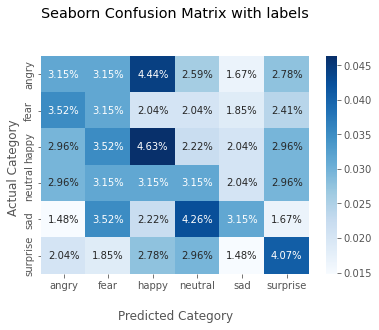

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Schimbarea numarului de neuroni din EmotionVGG la 1024

SCHIMBARI IN EMOTIONVGG

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class EmotionVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # Block #1: first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=inputShape))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #2: second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #3: third CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), kernel_initializer="he_normal", padding="same"))
        model.add(ReLU())
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # Block #4: first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #BLOC 5
        model.add(Dense(1024, kernel_initializer="he_normal"))
        model.add(ReLU())
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Block #7: softmax classifier
        model.add(Dense(classes, kernel_initializer="he_normal"))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model



---



ANTRENARE

Rezultatele se vor salva in outputs/output7

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output7'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output7/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')

# if there is no specific model checkpoint supplied, then initialize the network and compile the model
if model is None:
    print("[INFO] compiling mode...")
    model = EmotionVGGNet.build(width = 112, height = 112, depth = 3, classes = 6)
    opt = Adam(learning_rate = 1e-3)
    model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))
    K.set_value(model.optimizer.learning_rate, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.learning_rate)))

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition7.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition7.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling mode...
Epoch 1/50
21/33 [==================>...........] - ETA: 8s - loss: 2.4112 - accuracy: 0.3005

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 33s 971ms/step - loss: 2.2775 - accuracy: 0.3247 - val_loss: 2.2902 - val_accuracy: 0.1621
Epoch 2/50
 9/33 [=======>......................] - ETA: 18s - loss: 1.9277 - accuracy: 0.3845

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 933ms/step - loss: 1.7954 - accuracy: 0.4038 - val_loss: 2.3852 - val_accuracy: 0.1992
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.5265 - accuracy: 0.4743

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 1.5265 - accuracy: 0.4743 - val_loss: 2.5447 - val_accuracy: 0.1641
Epoch 4/50
31/33 [===========================>..] - ETA: 1s - loss: 1.3696 - accuracy: 0.5194

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 966ms/step - loss: 1.3743 - accuracy: 0.5187 - val_loss: 2.2127 - val_accuracy: 0.3047
Epoch 5/50
15/33 [============>.................] - ETA: 12s - loss: 1.2150 - accuracy: 0.5595

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 1.2290 - accuracy: 0.5617 - val_loss: 2.4817 - val_accuracy: 0.2422
Epoch 6/50
 1/33 [..............................] - ETA: 26s - loss: 1.0284 - accuracy: 0.6094

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 1.0432 - accuracy: 0.6141 - val_loss: 2.4165 - val_accuracy: 0.2578
Epoch 7/50
12/33 [=========>....................] - ETA: 15s - loss: 0.9361 - accuracy: 0.6517

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.9606 - accuracy: 0.6433 - val_loss: 2.5597 - val_accuracy: 0.2266
Epoch 8/50
12/33 [=========>....................] - ETA: 15s - loss: 0.8814 - accuracy: 0.6706

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 964ms/step - loss: 0.8909 - accuracy: 0.6629 - val_loss: 1.9959 - val_accuracy: 0.3574
Epoch 9/50
23/33 [===================>..........] - ETA: 7s - loss: 0.8395 - accuracy: 0.6815

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 938ms/step - loss: 0.8288 - accuracy: 0.6855 - val_loss: 1.1813 - val_accuracy: 0.5234
Epoch 10/50
29/33 [=========================>....] - ETA: 2s - loss: 0.7604 - accuracy: 0.7121

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 942ms/step - loss: 0.7580 - accuracy: 0.7125 - val_loss: 1.2749 - val_accuracy: 0.5469
Epoch 11/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.7162 - accuracy: 0.7344

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 983ms/step - loss: 0.7134 - accuracy: 0.7278 - val_loss: 0.9066 - val_accuracy: 0.6543
Epoch 12/50
29/33 [=========================>....] - ETA: 2s - loss: 0.6597 - accuracy: 0.7435

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 938ms/step - loss: 0.6668 - accuracy: 0.7436 - val_loss: 0.7473 - val_accuracy: 0.7109
Epoch 13/50
25/33 [=====================>........] - ETA: 5s - loss: 0.6212 - accuracy: 0.7582

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.6385 - accuracy: 0.7552 - val_loss: 0.8175 - val_accuracy: 0.6973
Epoch 14/50
 3/33 [=>............................] - ETA: 23s - loss: 0.4834 - accuracy: 0.8385

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 922ms/step - loss: 0.5862 - accuracy: 0.7744 - val_loss: 0.7326 - val_accuracy: 0.7461
Epoch 15/50
19/33 [================>.............] - ETA: 10s - loss: 0.5576 - accuracy: 0.7841

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.5813 - accuracy: 0.7776 - val_loss: 0.8597 - val_accuracy: 0.6875
Epoch 16/50
12/33 [=========>....................] - ETA: 15s - loss: 0.5588 - accuracy: 0.7897

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 968ms/step - loss: 0.5603 - accuracy: 0.7892 - val_loss: 0.6363 - val_accuracy: 0.7617
Epoch 17/50
11/33 [=========>....................] - ETA: 16s - loss: 0.4957 - accuracy: 0.8097

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.4916 - accuracy: 0.8137 - val_loss: 0.6688 - val_accuracy: 0.7500
Epoch 18/50
25/33 [=====================>........] - ETA: 6s - loss: 0.4956 - accuracy: 0.8112

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 818ms/step - loss: 0.4880 - accuracy: 0.8135 - val_loss: 0.6519 - val_accuracy: 0.7617
Epoch 19/50
 1/33 [..............................] - ETA: 28s - loss: 0.4839 - accuracy: 0.8203

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.4751 - accuracy: 0.8137 - val_loss: 0.9614 - val_accuracy: 0.7012
Epoch 20/50
31/33 [===========================>..] - ETA: 1s - loss: 0.4616 - accuracy: 0.8136

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.4544 - accuracy: 0.8167 - val_loss: 0.8228 - val_accuracy: 0.7285
Epoch 21/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4183 - accuracy: 0.8380

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 799ms/step - loss: 0.4232 - accuracy: 0.8361 - val_loss: 0.7102 - val_accuracy: 0.7422
Epoch 22/50
20/33 [=================>............] - ETA: 9s - loss: 0.4052 - accuracy: 0.8337

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 930ms/step - loss: 0.4299 - accuracy: 0.8315 - val_loss: 0.6027 - val_accuracy: 0.7891
Epoch 23/50
 1/33 [..............................] - ETA: 25s - loss: 0.3531 - accuracy: 0.8594

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.4014 - accuracy: 0.8460 - val_loss: 0.6378 - val_accuracy: 0.7676
Epoch 24/50
33/33 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.8426

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.4163 - accuracy: 0.8426 - val_loss: 0.7089 - val_accuracy: 0.7559
Epoch 25/50
16/33 [=============>................] - ETA: 12s - loss: 0.3602 - accuracy: 0.8605

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.3736 - accuracy: 0.8538 - val_loss: 0.7187 - val_accuracy: 0.7676
Epoch 26/50
32/33 [============================>.] - ETA: 0s - loss: 0.3492 - accuracy: 0.8702

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 936ms/step - loss: 0.3523 - accuracy: 0.8696 - val_loss: 0.6409 - val_accuracy: 0.7988
Epoch 27/50
26/33 [======================>.......] - ETA: 5s - loss: 0.3973 - accuracy: 0.8464

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 814ms/step - loss: 0.3899 - accuracy: 0.8470 - val_loss: 0.6349 - val_accuracy: 0.7695
Epoch 28/50
17/33 [==============>...............] - ETA: 11s - loss: 0.3292 - accuracy: 0.8696

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3418 - accuracy: 0.8630 - val_loss: 0.5584 - val_accuracy: 0.7969
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.3659 - accuracy: 0.8545 - val_loss: 0.6604 - val_accuracy: 0.7715
Epoch 30/50
 5/33 [===>..........................] - ETA: 21s - loss: 0.3565 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.3474 - accuracy: 0.8679 - val_loss: 0.6848 - val_accuracy: 0.7695
Epoch 31/50
10/33 [========>.....................] - ETA: 17s - loss: 0.3111 - accuracy: 0.8859

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.3175 - accuracy: 0.8781 - val_loss: 0.5879 - val_accuracy: 0.7891
Epoch 32/50
20/33 [=================>............] - ETA: 10s - loss: 0.2879 - accuracy: 0.8957

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3131 - accuracy: 0.8839 - val_loss: 0.6187 - val_accuracy: 0.7891
Epoch 33/50
17/33 [==============>...............] - ETA: 11s - loss: 0.2801 - accuracy: 0.8874

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2926 - accuracy: 0.8837 - val_loss: 0.7370 - val_accuracy: 0.7617
Epoch 34/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2875 - accuracy: 0.8835

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.2885 - accuracy: 0.8842 - val_loss: 0.6454 - val_accuracy: 0.7930
Epoch 35/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.2421 - accuracy: 0.9043

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.2740 - accuracy: 0.8905 - val_loss: 0.7562 - val_accuracy: 0.7598
Epoch 36/50
16/33 [=============>................] - ETA: 11s - loss: 0.2751 - accuracy: 0.9042

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 964ms/step - loss: 0.2699 - accuracy: 0.9017 - val_loss: 0.6280 - val_accuracy: 0.8301
Epoch 37/50
 3/33 [=>............................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9323

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.2410 - accuracy: 0.9094 - val_loss: 0.6945 - val_accuracy: 0.7891
Epoch 38/50
30/33 [==========================>...] - ETA: 2s - loss: 0.2548 - accuracy: 0.8993

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.2565 - accuracy: 0.8995 - val_loss: 0.7258 - val_accuracy: 0.7773
Epoch 39/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.2138 - accuracy: 0.9141

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 804ms/step - loss: 0.2372 - accuracy: 0.9053 - val_loss: 0.7167 - val_accuracy: 0.7832
Epoch 40/50
29/33 [=========================>....] - ETA: 2s - loss: 0.2253 - accuracy: 0.9193

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.2298 - accuracy: 0.9184 - val_loss: 0.6410 - val_accuracy: 0.8008
Epoch 41/50
10/33 [========>.....................] - ETA: 17s - loss: 0.2279 - accuracy: 0.9211

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.2216 - accuracy: 0.9199 - val_loss: 0.7016 - val_accuracy: 0.7891
Epoch 42/50
13/33 [==========>...................] - ETA: 15s - loss: 0.1996 - accuracy: 0.9237

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.1985 - accuracy: 0.9216 - val_loss: 0.7269 - val_accuracy: 0.7891
Epoch 43/50
25/33 [=====================>........] - ETA: 5s - loss: 0.2089 - accuracy: 0.9202

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.2226 - accuracy: 0.9150 - val_loss: 0.6592 - val_accuracy: 0.8145
Epoch 44/50
20/33 [=================>............] - ETA: 9s - loss: 0.2088 - accuracy: 0.9234 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.2199 - accuracy: 0.9167 - val_loss: 0.8227 - val_accuracy: 0.7578
Epoch 45/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.1544 - accuracy: 0.9492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 798ms/step - loss: 0.2375 - accuracy: 0.9116 - val_loss: 1.0716 - val_accuracy: 0.7148
Epoch 46/50
12/33 [=========>....................] - ETA: 15s - loss: 0.2381 - accuracy: 0.9134

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 801ms/step - loss: 0.2338 - accuracy: 0.9114 - val_loss: 0.7476 - val_accuracy: 0.7715
Epoch 47/50
11/33 [=========>....................] - ETA: 14s - loss: 0.2019 - accuracy: 0.9286

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.1948 - accuracy: 0.9296 - val_loss: 0.6091 - val_accuracy: 0.8105
Epoch 48/50
 9/33 [=======>......................] - ETA: 17s - loss: 0.1688 - accuracy: 0.9306

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 794ms/step - loss: 0.1740 - accuracy: 0.9344 - val_loss: 0.6301 - val_accuracy: 0.8281
Epoch 49/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.1959 - accuracy: 0.9258

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 796ms/step - loss: 0.1888 - accuracy: 0.9257 - val_loss: 0.6970 - val_accuracy: 0.8242
Epoch 50/50
26/33 [======================>.......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9252

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 804ms/step - loss: 0.1945 - accuracy: 0.9271 - val_loss: 0.6779 - val_accuracy: 0.8086




---



TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output7/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output7/checkpoint...
4/4 [==============================] - 2s 447ms/step - loss: 0.6218 - accuracy: 0.8223
              precision    recall  f1-score   support

           0       0.26      0.25      0.25        96
           1       0.17      0.21      0.18        81
           2       0.18      0.17      0.18        99
           3       0.18      0.16      0.17        94
           4       0.10      0.11      0.11        88
           5       0.21      0.17      0.19        82

    accuracy                           0.18       540
   macro avg       0.18      0.18      0.18       540
weighted avg       0.18      0.18      0.18       540

[INFO] accuracy: 82.23


Matrice de confuzie

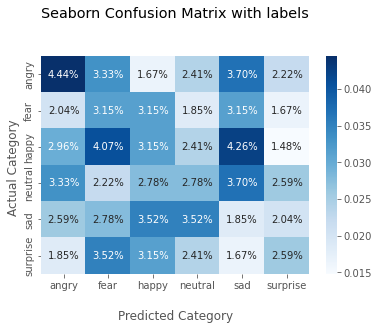

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Antrenare pe modelul VGG16 - 1

Se va schimba modelul EmotionVGG creat mai sus cu modelul VGG pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning.

Rezultatele se salveaza in outputs/output8.



---



ANTRENARE

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output8'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output8/checkpoint'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(112,112,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dense_layer_2, prediction_layer])

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition8.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition8.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling model...
Epoch 1/50
16/33 [=============>................] - ETA: 13s - loss: 1.7101 - accuracy: 0.2939

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 909ms/step - loss: 1.6170 - accuracy: 0.3371 - val_loss: 1.4394 - val_accuracy: 0.4297
Epoch 2/50
28/33 [========================>.....] - ETA: 3s - loss: 1.3161 - accuracy: 0.4807

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 880ms/step - loss: 1.3018 - accuracy: 0.4888 - val_loss: 1.1701 - val_accuracy: 0.5469
Epoch 3/50
32/33 [============================>.] - ETA: 0s - loss: 1.0868 - accuracy: 0.5990

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 895ms/step - loss: 1.0882 - accuracy: 0.5983 - val_loss: 1.0466 - val_accuracy: 0.5918
Epoch 4/50
 2/33 [>.............................] - ETA: 24s - loss: 0.9834 - accuracy: 0.6172

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.9660 - accuracy: 0.6391 - val_loss: 0.9520 - val_accuracy: 0.6348
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.6663

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output8/checkpoint/assets
33/33 [==============================] - 29s 886ms/step - loss: 0.8911 - accuracy: 0.6663 - val_loss: 0.8690 - val_accuracy: 0.6445
Epoch 6/50
16/33 [=============>................] - ETA: 13s - loss: 0.8332 - accuracy: 0.6978

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 896ms/step - loss: 0.8275 - accuracy: 0.6984 - val_loss: 0.8476 - val_accuracy: 0.6699
Epoch 7/50
30/33 [==========================>...] - ETA: 2s - loss: 0.7757 - accuracy: 0.7191

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.7760 - accuracy: 0.7186 - val_loss: 0.8172 - val_accuracy: 0.6680
Epoch 8/50
30/33 [==========================>...] - ETA: 2s - loss: 0.7183 - accuracy: 0.7416

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 842ms/step - loss: 0.7178 - accuracy: 0.7411 - val_loss: 0.8337 - val_accuracy: 0.6621
Epoch 9/50
 2/33 [>.............................] - ETA: 22s - loss: 0.6667 - accuracy: 0.7578

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 865ms/step - loss: 0.7009 - accuracy: 0.7513 - val_loss: 0.8315 - val_accuracy: 0.6680
Epoch 10/50
16/33 [=============>................] - ETA: 12s - loss: 0.6267 - accuracy: 0.7801

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.6511 - accuracy: 0.7712 - val_loss: 0.8315 - val_accuracy: 0.6758
Epoch 11/50
 2/33 [>.............................] - ETA: 23s - loss: 0.6655 - accuracy: 0.7656

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.6289 - accuracy: 0.7754 - val_loss: 0.7680 - val_accuracy: 0.6953
Epoch 12/50
33/33 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7882

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output8/checkpoint/assets
33/33 [==============================] - 29s 887ms/step - loss: 0.6049 - accuracy: 0.7882 - val_loss: 0.7478 - val_accuracy: 0.6992
Epoch 13/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5646 - accuracy: 0.8078

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.5669 - accuracy: 0.8065 - val_loss: 0.7660 - val_accuracy: 0.6875
Epoch 14/50
 2/33 [>.............................] - ETA: 23s - loss: 0.4995 - accuracy: 0.8203

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.5621 - accuracy: 0.8065 - val_loss: 0.7918 - val_accuracy: 0.6895
Epoch 15/50
25/33 [=====================>........] - ETA: 5s - loss: 0.5451 - accuracy: 0.8087

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 890ms/step - loss: 0.5445 - accuracy: 0.8079 - val_loss: 0.7952 - val_accuracy: 0.7051
Epoch 16/50
33/33 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.8167

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.5209 - accuracy: 0.8167 - val_loss: 0.8246 - val_accuracy: 0.6699
Epoch 17/50
11/33 [=========>....................] - ETA: 15s - loss: 0.4665 - accuracy: 0.8518

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.5087 - accuracy: 0.8222 - val_loss: 0.7856 - val_accuracy: 0.6973
Epoch 18/50
 1/33 [..............................] - ETA: 25s - loss: 0.4625 - accuracy: 0.8047

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.4928 - accuracy: 0.8261 - val_loss: 0.7841 - val_accuracy: 0.6934
Epoch 19/50
24/33 [====================>.........] - ETA: 6s - loss: 0.4785 - accuracy: 0.8291

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.4746 - accuracy: 0.8310 - val_loss: 0.7936 - val_accuracy: 0.6914
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.4405 - accuracy: 0.8519 - val_loss: 0.7969 - val_accuracy: 0.6973
Epoch 21/50
21/33 [==================>...........] - ETA: 8s - loss: 0.4715 - accuracy: 0.8342

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 886ms/step - loss: 0.4648 - accuracy: 0.8375 - val_loss: 0.7890 - val_accuracy: 0.7246
Epoch 22/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.4166 - accuracy: 0.8620

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.4386 - accuracy: 0.8480 - val_loss: 0.7963 - val_accuracy: 0.6953
Epoch 23/50
28/33 [========================>.....] - ETA: 3s - loss: 0.4085 - accuracy: 0.8603

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.4122 - accuracy: 0.8565 - val_loss: 0.8088 - val_accuracy: 0.7090
Epoch 24/50
16/33 [=============>................] - ETA: 11s - loss: 0.4049 - accuracy: 0.8568

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.4080 - accuracy: 0.8570 - val_loss: 0.7976 - val_accuracy: 0.7051
Epoch 25/50
16/33 [=============>................] - ETA: 12s - loss: 0.3731 - accuracy: 0.8744

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.3820 - accuracy: 0.8652 - val_loss: 0.8494 - val_accuracy: 0.7051
Epoch 26/50
26/33 [======================>.......] - ETA: 5s - loss: 0.3581 - accuracy: 0.8790

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3610 - accuracy: 0.8781 - val_loss: 0.8495 - val_accuracy: 0.6895
Epoch 27/50
22/33 [===================>..........] - ETA: 8s - loss: 0.3673 - accuracy: 0.8716

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3805 - accuracy: 0.8667 - val_loss: 0.9065 - val_accuracy: 0.6875
Epoch 28/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3635 - accuracy: 0.8796

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.3546 - accuracy: 0.8837 - val_loss: 0.8427 - val_accuracy: 0.7051
Epoch 29/50
18/33 [===============>..............] - ETA: 10s - loss: 0.3368 - accuracy: 0.8767

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 797ms/step - loss: 0.3426 - accuracy: 0.8776 - val_loss: 0.8141 - val_accuracy: 0.7109
Epoch 30/50
10/33 [========>.....................] - ETA: 15s - loss: 0.3183 - accuracy: 0.8850

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3267 - accuracy: 0.8888 - val_loss: 0.8394 - val_accuracy: 0.7012
Epoch 31/50
19/33 [================>.............] - ETA: 10s - loss: 0.2953 - accuracy: 0.9083

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 799ms/step - loss: 0.3136 - accuracy: 0.8970 - val_loss: 0.8552 - val_accuracy: 0.6934
Epoch 32/50
13/33 [==========>...................] - ETA: 15s - loss: 0.3364 - accuracy: 0.8816

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.3159 - accuracy: 0.8895 - val_loss: 0.8828 - val_accuracy: 0.7109
Epoch 33/50
24/33 [====================>.........] - ETA: 6s - loss: 0.2985 - accuracy: 0.9027

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.2914 - accuracy: 0.9043 - val_loss: 0.8431 - val_accuracy: 0.7168
Epoch 34/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.2554 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.2848 - accuracy: 0.9046 - val_loss: 0.8429 - val_accuracy: 0.7188
Epoch 35/50
22/33 [===================>..........] - ETA: 8s - loss: 0.2842 - accuracy: 0.9022

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.2806 - accuracy: 0.9041 - val_loss: 0.9291 - val_accuracy: 0.6855
Epoch 36/50
30/33 [==========================>...] - ETA: 2s - loss: 0.2897 - accuracy: 0.8974

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.2892 - accuracy: 0.8973 - val_loss: 0.9802 - val_accuracy: 0.6758
Epoch 37/50
20/33 [=================>............] - ETA: 9s - loss: 0.2763 - accuracy: 0.9063 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 816ms/step - loss: 0.2872 - accuracy: 0.9000 - val_loss: 0.9190 - val_accuracy: 0.6895
Epoch 38/50
11/33 [=========>....................] - ETA: 16s - loss: 0.2598 - accuracy: 0.9190

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.2683 - accuracy: 0.9104 - val_loss: 0.8949 - val_accuracy: 0.7207
Epoch 39/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.2455 - accuracy: 0.9177

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.2663 - accuracy: 0.9092 - val_loss: 0.9460 - val_accuracy: 0.6895
Epoch 40/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.2184 - accuracy: 0.9284

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.2586 - accuracy: 0.9131 - val_loss: 0.9402 - val_accuracy: 0.6973
Epoch 41/50
19/33 [================>.............] - ETA: 10s - loss: 0.2553 - accuracy: 0.9041

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.2501 - accuracy: 0.9102 - val_loss: 0.9259 - val_accuracy: 0.7031
Epoch 42/50
26/33 [======================>.......] - ETA: 5s - loss: 0.2458 - accuracy: 0.9168

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 814ms/step - loss: 0.2501 - accuracy: 0.9138 - val_loss: 0.9059 - val_accuracy: 0.7227
Epoch 43/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.2166 - accuracy: 0.9076

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 820ms/step - loss: 0.2475 - accuracy: 0.9128 - val_loss: 0.9683 - val_accuracy: 0.6934
Epoch 44/50
13/33 [==========>...................] - ETA: 13s - loss: 0.2350 - accuracy: 0.9211

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.2342 - accuracy: 0.9194 - val_loss: 0.9806 - val_accuracy: 0.6992
Epoch 45/50
31/33 [===========================>..] - ETA: 1s - loss: 0.2229 - accuracy: 0.9236

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.2259 - accuracy: 0.9228 - val_loss: 0.9667 - val_accuracy: 0.7070
Epoch 46/50
26/33 [======================>.......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9295

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 883ms/step - loss: 0.2136 - accuracy: 0.9279 - val_loss: 0.9830 - val_accuracy: 0.7266
Epoch 47/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2131 - accuracy: 0.9267

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.2181 - accuracy: 0.9269 - val_loss: 1.0200 - val_accuracy: 0.6953
Epoch 48/50
28/33 [========================>.....] - ETA: 3s - loss: 0.2246 - accuracy: 0.9177

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.2271 - accuracy: 0.9186 - val_loss: 1.0387 - val_accuracy: 0.7266
Epoch 49/50
 5/33 [===>..........................] - ETA: 21s - loss: 0.1890 - accuracy: 0.9453

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.2095 - accuracy: 0.9254 - val_loss: 1.0005 - val_accuracy: 0.6914
Epoch 50/50
33/33 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9252

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.2145 - accuracy: 0.9252 - val_loss: 1.0390 - val_accuracy: 0.6816


TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output8/checkpoint'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output8/checkpoint...
4/4 [==============================] - 285s 92s/step - loss: 0.7958 - accuracy: 0.7695
              precision    recall  f1-score   support

           0       0.17      0.18      0.17        96
           1       0.06      0.05      0.06        81
           2       0.20      0.18      0.19        99
           3       0.19      0.23      0.21        94
           4       0.16      0.12      0.14        88
           5       0.15      0.18      0.17        82

    accuracy                           0.16       540
   macro avg       0.15      0.16      0.16       540
weighted avg       0.16      0.16      0.16       540

[INFO] accuracy: 76.95


Matrice de confuzie

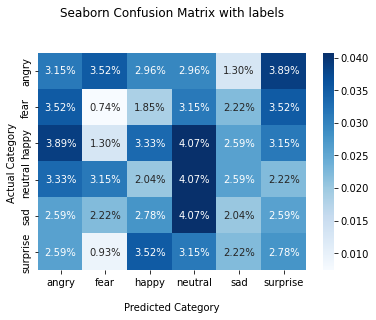

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()



---



# Antrenare pe modelul VGG16 - 2

Se va schimba modelul EmotionVGG creat mai sus cu modelul VGG pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu un strat de 256 de neuroni.

Rezultatele se salveaza in outputs/output9.



---



ANTRENARE

In [6]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output9'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(112,112,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, prediction_layer])

for layer in base_model.layers[:15]:
  layer.trainable = False

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition9_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition9_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling model...
Epoch 1/50
20/33 [=================>............] - ETA: 9s - loss: 1.6625 - accuracy: 0.3786 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 37s 945ms/step - loss: 1.4851 - accuracy: 0.4298 - val_loss: 1.1601 - val_accuracy: 0.5195
Epoch 2/50
32/33 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.6028

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 953ms/step - loss: 1.0338 - accuracy: 0.6054 - val_loss: 0.9666 - val_accuracy: 0.6230
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.6617

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1/assets
33/33 [==============================] - 31s 948ms/step - loss: 0.9056 - accuracy: 0.6617 - val_loss: 0.8831 - val_accuracy: 0.6406
Epoch 4/50
12/33 [=========>....................] - ETA: 16s - loss: 0.7802 - accuracy: 0.7018

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.8048 - accuracy: 0.6969 - val_loss: 0.8768 - val_accuracy: 0.6289
Epoch 5/50
 4/33 [==>...........................] - ETA: 23s - loss: 0.6857 - accuracy: 0.7559

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 958ms/step - loss: 0.7348 - accuracy: 0.7324 - val_loss: 0.8518 - val_accuracy: 0.6660
Epoch 6/50
21/33 [==================>...........] - ETA: 9s - loss: 0.6794 - accuracy: 0.7603 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.6772 - accuracy: 0.7562 - val_loss: 0.8225 - val_accuracy: 0.6523
Epoch 7/50
10/33 [========>.....................] - ETA: 18s - loss: 0.6195 - accuracy: 0.7727

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 857ms/step - loss: 0.6403 - accuracy: 0.7640 - val_loss: 0.7810 - val_accuracy: 0.6621
Epoch 8/50
 2/33 [>.............................] - ETA: 25s - loss: 0.6575 - accuracy: 0.7422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 858ms/step - loss: 0.6041 - accuracy: 0.7814 - val_loss: 0.7896 - val_accuracy: 0.6602
Epoch 9/50
32/33 [============================>.] - ETA: 0s - loss: 0.5720 - accuracy: 0.7935

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 866ms/step - loss: 0.5728 - accuracy: 0.7938 - val_loss: 0.8194 - val_accuracy: 0.6641
Epoch 10/50
33/33 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.8069

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1/assets
33/33 [==============================] - 31s 941ms/step - loss: 0.5474 - accuracy: 0.8069 - val_loss: 0.7332 - val_accuracy: 0.6836
Epoch 11/50
31/33 [===========================>..] - ETA: 1s - loss: 0.4842 - accuracy: 0.8335

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 956ms/step - loss: 0.4829 - accuracy: 0.8356 - val_loss: 0.7960 - val_accuracy: 0.6875
Epoch 12/50
19/33 [================>.............] - ETA: 10s - loss: 0.4772 - accuracy: 0.8237

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 939ms/step - loss: 0.4757 - accuracy: 0.8315 - val_loss: 0.7545 - val_accuracy: 0.7070
Epoch 13/50
15/33 [============>.................] - ETA: 13s - loss: 0.4563 - accuracy: 0.8335

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.4558 - accuracy: 0.8346 - val_loss: 0.7910 - val_accuracy: 0.6699
Epoch 14/50
13/33 [==========>...................] - ETA: 16s - loss: 0.4162 - accuracy: 0.8492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 858ms/step - loss: 0.4368 - accuracy: 0.8443 - val_loss: 0.8229 - val_accuracy: 0.6934
Epoch 15/50
20/33 [=================>............] - ETA: 10s - loss: 0.3945 - accuracy: 0.8715

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 925ms/step - loss: 0.4069 - accuracy: 0.8587 - val_loss: 0.7730 - val_accuracy: 0.7148
Epoch 16/50
20/33 [=================>............] - ETA: 9s - loss: 0.3902 - accuracy: 0.8610 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 861ms/step - loss: 0.3879 - accuracy: 0.8623 - val_loss: 0.8444 - val_accuracy: 0.6953
Epoch 17/50
21/33 [==================>...........] - ETA: 9s - loss: 0.3756 - accuracy: 0.8687 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.3811 - accuracy: 0.8662 - val_loss: 0.8183 - val_accuracy: 0.6973
Epoch 18/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3547 - accuracy: 0.8770

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.3595 - accuracy: 0.8757 - val_loss: 0.7877 - val_accuracy: 0.7109
Epoch 19/50
21/33 [==================>...........] - ETA: 9s - loss: 0.3187 - accuracy: 0.8880 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 949ms/step - loss: 0.3292 - accuracy: 0.8847 - val_loss: 0.7730 - val_accuracy: 0.7188
Epoch 20/50
17/33 [==============>...............] - ETA: 13s - loss: 0.3121 - accuracy: 0.9007

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 875ms/step - loss: 0.3124 - accuracy: 0.8963 - val_loss: 0.8547 - val_accuracy: 0.6816
Epoch 21/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.2935 - accuracy: 0.8958

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 881ms/step - loss: 0.2997 - accuracy: 0.8966 - val_loss: 0.7928 - val_accuracy: 0.7031
Epoch 22/50
12/33 [=========>....................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8887

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 883ms/step - loss: 0.2914 - accuracy: 0.8983 - val_loss: 0.8559 - val_accuracy: 0.7109
Epoch 23/50
25/33 [=====================>........] - ETA: 6s - loss: 0.2592 - accuracy: 0.9206

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.2675 - accuracy: 0.9174 - val_loss: 0.8434 - val_accuracy: 0.7012
Epoch 24/50
15/33 [============>.................] - ETA: 14s - loss: 0.3214 - accuracy: 0.8797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 943ms/step - loss: 0.2950 - accuracy: 0.8987 - val_loss: 0.7742 - val_accuracy: 0.7207
Epoch 25/50
23/33 [===================>..........] - ETA: 7s - loss: 0.2502 - accuracy: 0.9165

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 877ms/step - loss: 0.2539 - accuracy: 0.9157 - val_loss: 0.8439 - val_accuracy: 0.7031
Epoch 26/50
32/33 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9251

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.2277 - accuracy: 0.9252 - val_loss: 0.8202 - val_accuracy: 0.7148
Epoch 27/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.2134 - accuracy: 0.9273

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 873ms/step - loss: 0.2344 - accuracy: 0.9216 - val_loss: 0.8960 - val_accuracy: 0.7051
Epoch 28/50
15/33 [============>.................] - ETA: 15s - loss: 0.2168 - accuracy: 0.9344

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 945ms/step - loss: 0.2122 - accuracy: 0.9313 - val_loss: 0.7991 - val_accuracy: 0.7266
Epoch 29/50
26/33 [======================>.......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9289

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 883ms/step - loss: 0.2195 - accuracy: 0.9281 - val_loss: 0.8691 - val_accuracy: 0.7168
Epoch 30/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1988 - accuracy: 0.9341

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.2005 - accuracy: 0.9339 - val_loss: 0.9219 - val_accuracy: 0.7148
Epoch 31/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1823 - accuracy: 0.9447

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 866ms/step - loss: 0.1986 - accuracy: 0.9369 - val_loss: 0.9758 - val_accuracy: 0.6914
Epoch 32/50
29/33 [=========================>....] - ETA: 3s - loss: 0.2345 - accuracy: 0.9168

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.2320 - accuracy: 0.9179 - val_loss: 0.9262 - val_accuracy: 0.7109
Epoch 33/50
19/33 [================>.............] - ETA: 11s - loss: 0.1802 - accuracy: 0.9381

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.1898 - accuracy: 0.9369 - val_loss: 0.9641 - val_accuracy: 0.6914
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 869ms/step - loss: 0.1901 - accuracy: 0.9361 - val_loss: 0.8694 - val_accuracy: 0.7227
Epoch 35/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1737 - accuracy: 0.9457

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 869ms/step - loss: 0.1738 - accuracy: 0.9451 - val_loss: 0.8933 - val_accuracy: 0.7266
Epoch 36/50
33/33 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9429

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 873ms/step - loss: 0.1674 - accuracy: 0.9429 - val_loss: 1.0202 - val_accuracy: 0.7031
Epoch 37/50
30/33 [==========================>...] - ETA: 2s - loss: 0.1628 - accuracy: 0.9467

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 858ms/step - loss: 0.1637 - accuracy: 0.9463 - val_loss: 0.9169 - val_accuracy: 0.7070
Epoch 38/50
12/33 [=========>....................] - ETA: 17s - loss: 0.1651 - accuracy: 0.9460

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.1536 - accuracy: 0.9497 - val_loss: 0.9588 - val_accuracy: 0.7090
Epoch 39/50
 5/33 [===>..........................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9422

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 875ms/step - loss: 0.1679 - accuracy: 0.9483 - val_loss: 0.9578 - val_accuracy: 0.7246
Epoch 40/50
31/33 [===========================>..] - ETA: 1s - loss: 0.1503 - accuracy: 0.9529

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.1513 - accuracy: 0.9529 - val_loss: 1.0091 - val_accuracy: 0.7109
Epoch 41/50
 7/33 [=====>........................] - ETA: 18s - loss: 0.1815 - accuracy: 0.9418

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 882ms/step - loss: 0.1379 - accuracy: 0.9573 - val_loss: 0.9138 - val_accuracy: 0.7031
Epoch 42/50
21/33 [==================>...........] - ETA: 9s - loss: 0.1244 - accuracy: 0.9613 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 873ms/step - loss: 0.1280 - accuracy: 0.9607 - val_loss: 0.8522 - val_accuracy: 0.7188
Epoch 43/50
29/33 [=========================>....] - ETA: 3s - loss: 0.1537 - accuracy: 0.9481

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 979ms/step - loss: 0.1505 - accuracy: 0.9512 - val_loss: 0.9144 - val_accuracy: 0.7285
Epoch 44/50
21/33 [==================>...........] - ETA: 9s - loss: 0.1323 - accuracy: 0.9561 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 881ms/step - loss: 0.1283 - accuracy: 0.9590 - val_loss: 0.9243 - val_accuracy: 0.7207
Epoch 45/50
 4/33 [==>...........................] - ETA: 25s - loss: 0.1077 - accuracy: 0.9668

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.1244 - accuracy: 0.9611 - val_loss: 0.9793 - val_accuracy: 0.7188
Epoch 46/50
 3/33 [=>............................] - ETA: 27s - loss: 0.1031 - accuracy: 0.9714

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 975ms/step - loss: 0.1109 - accuracy: 0.9631 - val_loss: 0.9138 - val_accuracy: 0.7344
Epoch 47/50
 2/33 [>.............................] - ETA: 22s - loss: 0.0939 - accuracy: 0.9727

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.1023 - accuracy: 0.9694 - val_loss: 0.9650 - val_accuracy: 0.7168
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 886ms/step - loss: 0.1110 - accuracy: 0.9677 - val_loss: 1.0226 - val_accuracy: 0.7031
Epoch 49/50
22/33 [===================>..........] - ETA: 8s - loss: 0.1035 - accuracy: 0.9705

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.1060 - accuracy: 0.9682 - val_loss: 0.9912 - val_accuracy: 0.7285
Epoch 50/50
33/33 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9585

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 873ms/step - loss: 0.1177 - accuracy: 0.9585 - val_loss: 1.0572 - val_accuracy: 0.7168




---



TESTARE

In [7]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1...
4/4 [==============================] - 2s 497ms/step - loss: 0.7881 - accuracy: 0.7539
              precision    recall  f1-score   support

           0       0.18      0.18      0.18        96
           1       0.15      0.12      0.14        81
           2       0.19      0.18      0.19        99
           3       0.20      0.22      0.21        94
           4       0.15      0.15      0.15        88
           5       0.14      0.16      0.15        82

    accuracy                           0.17       540
   macro avg       0.17      0.17      0.17       540
weighted avg       0.17      0.17      0.17       540

[INFO] accuracy: 75.39




---





---



ANTRENARE

In [9]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output9'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint2'
start_epoch = 0

for layer in base_model.layers[15:]:
  layer.trainable = True

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition9_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition9_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/50
26/33 [======================>.......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9308

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 33s 1s/step - loss: 0.1672 - accuracy: 0.9376 - val_loss: 0.9033 - val_accuracy: 0.7266
Epoch 2/50
28/33 [========================>.....] - ETA: 4s - loss: 0.1125 - accuracy: 0.9654

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 906ms/step - loss: 0.1133 - accuracy: 0.9653 - val_loss: 0.9624 - val_accuracy: 0.7148
Epoch 3/50
24/33 [====================>.........] - ETA: 7s - loss: 0.1057 - accuracy: 0.9674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.1112 - accuracy: 0.9645 - val_loss: 0.9507 - val_accuracy: 0.7148
Epoch 4/50
20/33 [=================>............] - ETA: 10s - loss: 0.1122 - accuracy: 0.9662

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 889ms/step - loss: 0.1085 - accuracy: 0.9682 - val_loss: 0.9848 - val_accuracy: 0.7188
Epoch 5/50
23/33 [===================>..........] - ETA: 7s - loss: 0.0912 - accuracy: 0.9746

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 884ms/step - loss: 0.0968 - accuracy: 0.9721 - val_loss: 1.0023 - val_accuracy: 0.7070
Epoch 6/50
13/33 [==========>...................] - ETA: 16s - loss: 0.1188 - accuracy: 0.9573

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.1292 - accuracy: 0.9563 - val_loss: 1.1008 - val_accuracy: 0.7266
Epoch 7/50
 1/33 [..............................] - ETA: 33s - loss: 0.1740 - accuracy: 0.9219

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.1181 - accuracy: 0.9621 - val_loss: 1.0854 - val_accuracy: 0.7188
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.1110 - accuracy: 0.9624 - val_loss: 1.0590 - val_accuracy: 0.6934
Epoch 9/50
31/33 [===========================>..] - ETA: 1s - loss: 0.1318 - accuracy: 0.9588

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 884ms/step - loss: 0.1312 - accuracy: 0.9592 - val_loss: 1.0941 - val_accuracy: 0.7266
Epoch 10/50
 3/33 [=>............................] - ETA: 27s - loss: 0.0840 - accuracy: 0.9714

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 888ms/step - loss: 0.0951 - accuracy: 0.9701 - val_loss: 1.0697 - val_accuracy: 0.6973
Epoch 11/50
24/33 [====================>.........] - ETA: 7s - loss: 0.0988 - accuracy: 0.9707

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 883ms/step - loss: 0.1015 - accuracy: 0.9687 - val_loss: 1.1019 - val_accuracy: 0.6855
Epoch 12/50
30/33 [==========================>...] - ETA: 2s - loss: 0.0905 - accuracy: 0.9708

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.0907 - accuracy: 0.9713 - val_loss: 1.0215 - val_accuracy: 0.7070
Epoch 13/50
29/33 [=========================>....] - ETA: 3s - loss: 0.0894 - accuracy: 0.9698

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 908ms/step - loss: 0.0851 - accuracy: 0.9718 - val_loss: 1.0985 - val_accuracy: 0.7070
Epoch 14/50
15/33 [============>.................] - ETA: 14s - loss: 0.0686 - accuracy: 0.9818

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 880ms/step - loss: 0.0770 - accuracy: 0.9769 - val_loss: 1.0287 - val_accuracy: 0.7051
Epoch 15/50
 5/33 [===>..........................] - ETA: 22s - loss: 0.0771 - accuracy: 0.9781

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 873ms/step - loss: 0.0723 - accuracy: 0.9803 - val_loss: 1.0713 - val_accuracy: 0.7246
Epoch 16/50
22/33 [===================>..........] - ETA: 9s - loss: 0.1144 - accuracy: 0.9616 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 906ms/step - loss: 0.1037 - accuracy: 0.9645 - val_loss: 1.0784 - val_accuracy: 0.7227
Epoch 17/50
 6/33 [====>.........................] - ETA: 22s - loss: 0.0856 - accuracy: 0.9635

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 898ms/step - loss: 0.0836 - accuracy: 0.9735 - val_loss: 1.1763 - val_accuracy: 0.7188
Epoch 18/50
26/33 [======================>.......] - ETA: 5s - loss: 0.0831 - accuracy: 0.9752

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.0802 - accuracy: 0.9750 - val_loss: 1.1387 - val_accuracy: 0.7090
Epoch 19/50
 6/33 [====>.........................] - ETA: 22s - loss: 0.0640 - accuracy: 0.9779

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0827 - accuracy: 0.9760 - val_loss: 1.0889 - val_accuracy: 0.7266
Epoch 20/50
16/33 [=============>................] - ETA: 13s - loss: 0.0634 - accuracy: 0.9844

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 875ms/step - loss: 0.0717 - accuracy: 0.9806 - val_loss: 1.1299 - val_accuracy: 0.7070
Epoch 21/50
 9/33 [=======>......................] - ETA: 19s - loss: 0.0737 - accuracy: 0.9774

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 874ms/step - loss: 0.0626 - accuracy: 0.9818 - val_loss: 1.1120 - val_accuracy: 0.7090
Epoch 22/50
32/33 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9737

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0769 - accuracy: 0.9743 - val_loss: 1.2200 - val_accuracy: 0.7168
Epoch 23/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.0651 - accuracy: 0.9826

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 942ms/step - loss: 0.0841 - accuracy: 0.9716 - val_loss: 1.0982 - val_accuracy: 0.7344
Epoch 24/50
17/33 [==============>...............] - ETA: 12s - loss: 0.0782 - accuracy: 0.9778

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 869ms/step - loss: 0.0945 - accuracy: 0.9682 - val_loss: 1.2432 - val_accuracy: 0.7188
Epoch 25/50
20/33 [=================>............] - ETA: 10s - loss: 0.0956 - accuracy: 0.9674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.0902 - accuracy: 0.9704 - val_loss: 1.1888 - val_accuracy: 0.7344
Epoch 26/50
13/33 [==========>...................] - ETA: 16s - loss: 0.0794 - accuracy: 0.9766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 854ms/step - loss: 0.0777 - accuracy: 0.9738 - val_loss: 1.1038 - val_accuracy: 0.7266
Epoch 27/50
14/33 [===========>..................] - ETA: 15s - loss: 0.0652 - accuracy: 0.9766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.0724 - accuracy: 0.9747 - val_loss: 1.1173 - val_accuracy: 0.7207
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 857ms/step - loss: 0.0693 - accuracy: 0.9777 - val_loss: 1.1128 - val_accuracy: 0.7207
Epoch 29/50
32/33 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9761

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 851ms/step - loss: 0.0701 - accuracy: 0.9762 - val_loss: 1.2110 - val_accuracy: 0.6953
Epoch 30/50
22/33 [===================>..........] - ETA: 8s - loss: 0.0981 - accuracy: 0.9668

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.0970 - accuracy: 0.9687 - val_loss: 1.1601 - val_accuracy: 0.7168
Epoch 31/50
13/33 [==========>...................] - ETA: 15s - loss: 0.0570 - accuracy: 0.9807

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 856ms/step - loss: 0.0569 - accuracy: 0.9835 - val_loss: 1.0913 - val_accuracy: 0.7266
Epoch 32/50
15/33 [============>.................] - ETA: 14s - loss: 0.0470 - accuracy: 0.9885

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.0489 - accuracy: 0.9866 - val_loss: 1.2364 - val_accuracy: 0.7051
Epoch 33/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.0442 - accuracy: 0.9866

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 849ms/step - loss: 0.0572 - accuracy: 0.9801 - val_loss: 1.2691 - val_accuracy: 0.7148
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 855ms/step - loss: 0.0804 - accuracy: 0.9740 - val_loss: 1.1632 - val_accuracy: 0.7168
Epoch 35/50
 1/33 [..............................] - ETA: 30s - loss: 0.0207 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 852ms/step - loss: 0.0651 - accuracy: 0.9811 - val_loss: 1.1217 - val_accuracy: 0.7246
Epoch 36/50
25/33 [=====================>........] - ETA: 6s - loss: 0.0551 - accuracy: 0.9838

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.0559 - accuracy: 0.9837 - val_loss: 1.1122 - val_accuracy: 0.7246
Epoch 37/50
 1/33 [..............................] - ETA: 31s - loss: 0.0424 - accuracy: 0.9922

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 875ms/step - loss: 0.0547 - accuracy: 0.9818 - val_loss: 1.1480 - val_accuracy: 0.7324
Epoch 38/50
 6/33 [====>.........................] - ETA: 23s - loss: 0.0625 - accuracy: 0.9818

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0548 - accuracy: 0.9823 - val_loss: 1.0913 - val_accuracy: 0.7305
Epoch 39/50
19/33 [================>.............] - ETA: 10s - loss: 0.0495 - accuracy: 0.9871

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 855ms/step - loss: 0.0473 - accuracy: 0.9879 - val_loss: 1.2367 - val_accuracy: 0.7227
Epoch 40/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0538 - accuracy: 0.9821

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.0541 - accuracy: 0.9818 - val_loss: 1.1728 - val_accuracy: 0.7207
Epoch 41/50
19/33 [================>.............] - ETA: 10s - loss: 0.0637 - accuracy: 0.9819

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 859ms/step - loss: 0.0544 - accuracy: 0.9852 - val_loss: 1.1592 - val_accuracy: 0.7246
Epoch 42/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.0350 - accuracy: 0.9883

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0477 - accuracy: 0.9862 - val_loss: 1.1625 - val_accuracy: 0.7344
Epoch 43/50
 7/33 [=====>........................] - ETA: 18s - loss: 0.0488 - accuracy: 0.9873

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 864ms/step - loss: 0.0496 - accuracy: 0.9849 - val_loss: 1.3094 - val_accuracy: 0.7207
Epoch 44/50
19/33 [================>.............] - ETA: 10s - loss: 0.0505 - accuracy: 0.9815

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 942ms/step - loss: 0.0506 - accuracy: 0.9825 - val_loss: 1.2226 - val_accuracy: 0.7363
Epoch 45/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0668 - accuracy: 0.9794

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 892ms/step - loss: 0.0653 - accuracy: 0.9796 - val_loss: 1.1752 - val_accuracy: 0.7324
Epoch 46/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.0429 - accuracy: 0.9909

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 879ms/step - loss: 0.0472 - accuracy: 0.9859 - val_loss: 1.2098 - val_accuracy: 0.7266
Epoch 47/50
29/33 [=========================>....] - ETA: 3s - loss: 0.0420 - accuracy: 0.9881

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 876ms/step - loss: 0.0427 - accuracy: 0.9881 - val_loss: 1.2158 - val_accuracy: 0.7344
Epoch 48/50
21/33 [==================>...........] - ETA: 9s - loss: 0.0478 - accuracy: 0.9861 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0434 - accuracy: 0.9876 - val_loss: 1.2334 - val_accuracy: 0.7324
Epoch 49/50
30/33 [==========================>...] - ETA: 2s - loss: 0.0482 - accuracy: 0.9850

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 881ms/step - loss: 0.0475 - accuracy: 0.9852 - val_loss: 1.2620 - val_accuracy: 0.7266
Epoch 50/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0449 - accuracy: 0.9857

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.0467 - accuracy: 0.9849 - val_loss: 1.3133 - val_accuracy: 0.7266




---



TESTARE

In [10]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint2...
4/4 [==============================] - 2s 497ms/step - loss: 0.9869 - accuracy: 0.7617
              precision    recall  f1-score   support

           0       0.20      0.19      0.19        96
           1       0.19      0.16      0.17        81
           2       0.15      0.12      0.13        99
           3       0.19      0.24      0.22        94
           4       0.09      0.08      0.08        88
           5       0.16      0.20      0.17        82

    accuracy                           0.16       540
   macro avg       0.16      0.16      0.16       540
weighted avg       0.16      0.16      0.16       540

[INFO] accuracy: 76.17


Matrice de confuzie

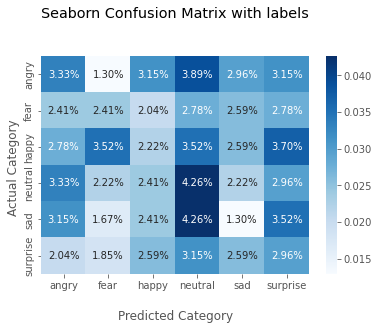

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Antrenare pe modelul VGG16 - 3

Se va schimba modelul EmotionVGG creat mai sus cu modelul VGG pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu un strat de 512 de neuroni.

Rezultatele se salveaza in outputs/output10.



---



ANTRENARE

In [13]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output10'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output10/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(112,112,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, prediction_layer])

for layer in base_model.layers[:15]:
  layer.trainable = False

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition10_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition10_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling model...
Epoch 1/50
15/33 [============>.................] - ETA: 14s - loss: 2.0667 - accuracy: 0.3307

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 952ms/step - loss: 1.5982 - accuracy: 0.4332 - val_loss: 1.0875 - val_accuracy: 0.5703
Epoch 2/50
24/33 [====================>.........] - ETA: 7s - loss: 1.0072 - accuracy: 0.6042

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 943ms/step - loss: 0.9933 - accuracy: 0.6146 - val_loss: 0.9610 - val_accuracy: 0.6406
Epoch 3/50
30/33 [==========================>...] - ETA: 2s - loss: 0.8488 - accuracy: 0.6805

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.8529 - accuracy: 0.6795 - val_loss: 0.9283 - val_accuracy: 0.6270
Epoch 4/50
31/33 [===========================>..] - ETA: 1s - loss: 0.8059 - accuracy: 0.6916

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 861ms/step - loss: 0.8063 - accuracy: 0.6921 - val_loss: 0.8496 - val_accuracy: 0.6348
Epoch 5/50
11/33 [=========>....................] - ETA: 18s - loss: 0.6911 - accuracy: 0.7365

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 862ms/step - loss: 0.7066 - accuracy: 0.7375 - val_loss: 0.8345 - val_accuracy: 0.6289
Epoch 6/50
14/33 [===========>..................] - ETA: 14s - loss: 0.6930 - accuracy: 0.7485

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 938ms/step - loss: 0.6719 - accuracy: 0.7540 - val_loss: 0.7907 - val_accuracy: 0.6738
Epoch 7/50
14/33 [===========>..................] - ETA: 14s - loss: 0.5905 - accuracy: 0.8001

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 861ms/step - loss: 0.6186 - accuracy: 0.7734 - val_loss: 0.7912 - val_accuracy: 0.6699
Epoch 8/50
 5/33 [===>..........................] - ETA: 17s - loss: 0.5886 - accuracy: 0.7940

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 942ms/step - loss: 0.5641 - accuracy: 0.8028 - val_loss: 0.7747 - val_accuracy: 0.6895
Epoch 9/50
24/33 [====================>.........] - ETA: 7s - loss: 0.5385 - accuracy: 0.8071

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.5399 - accuracy: 0.8048 - val_loss: 0.8336 - val_accuracy: 0.6719
Epoch 10/50
28/33 [========================>.....] - ETA: 3s - loss: 0.5168 - accuracy: 0.8114

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.5152 - accuracy: 0.8108 - val_loss: 0.8257 - val_accuracy: 0.6777
Epoch 11/50
 9/33 [=======>......................] - ETA: 17s - loss: 0.4966 - accuracy: 0.8413

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 935ms/step - loss: 0.5022 - accuracy: 0.8176 - val_loss: 0.7569 - val_accuracy: 0.7090
Epoch 12/50
26/33 [======================>.......] - ETA: 5s - loss: 0.4542 - accuracy: 0.8425

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 862ms/step - loss: 0.4509 - accuracy: 0.8439 - val_loss: 0.8411 - val_accuracy: 0.6582
Epoch 13/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4643 - accuracy: 0.8284

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 944ms/step - loss: 0.4547 - accuracy: 0.8329 - val_loss: 0.7872 - val_accuracy: 0.7109
Epoch 14/50
 3/33 [=>............................] - ETA: 22s - loss: 0.3813 - accuracy: 0.8776

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 869ms/step - loss: 0.4162 - accuracy: 0.8531 - val_loss: 0.7771 - val_accuracy: 0.7031
Epoch 15/50
33/33 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8621

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.3909 - accuracy: 0.8621 - val_loss: 0.8270 - val_accuracy: 0.6953
Epoch 16/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.4078 - accuracy: 0.8457

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.3952 - accuracy: 0.8594 - val_loss: 0.8174 - val_accuracy: 0.6875
Epoch 17/50
 9/33 [=======>......................] - ETA: 19s - loss: 0.3446 - accuracy: 0.8776

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 873ms/step - loss: 0.3591 - accuracy: 0.8669 - val_loss: 0.8598 - val_accuracy: 0.6875
Epoch 18/50
11/33 [=========>....................] - ETA: 16s - loss: 0.3260 - accuracy: 0.8810

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 926ms/step - loss: 0.3413 - accuracy: 0.8837 - val_loss: 0.8149 - val_accuracy: 0.7188
Epoch 19/50
14/33 [===========>..................] - ETA: 16s - loss: 0.3288 - accuracy: 0.8823

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.3426 - accuracy: 0.8764 - val_loss: 0.8605 - val_accuracy: 0.6914
Epoch 20/50
26/33 [======================>.......] - ETA: 5s - loss: 0.3043 - accuracy: 0.8973

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.3013 - accuracy: 0.8985 - val_loss: 0.8738 - val_accuracy: 0.7109
Epoch 21/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.3138 - accuracy: 0.8896

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 853ms/step - loss: 0.2989 - accuracy: 0.8963 - val_loss: 0.8269 - val_accuracy: 0.7031
Epoch 22/50
22/33 [===================>..........] - ETA: 8s - loss: 0.2769 - accuracy: 0.9013

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 859ms/step - loss: 0.2816 - accuracy: 0.9024 - val_loss: 0.8636 - val_accuracy: 0.6934
Epoch 23/50
15/33 [============>.................] - ETA: 13s - loss: 0.2445 - accuracy: 0.9168

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.2536 - accuracy: 0.9138 - val_loss: 0.8900 - val_accuracy: 0.7031
Epoch 24/50
22/33 [===================>..........] - ETA: 8s - loss: 0.2491 - accuracy: 0.9166

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 878ms/step - loss: 0.2539 - accuracy: 0.9143 - val_loss: 0.8441 - val_accuracy: 0.7148
Epoch 25/50
31/33 [===========================>..] - ETA: 1s - loss: 0.2254 - accuracy: 0.9280

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 950ms/step - loss: 0.2260 - accuracy: 0.9271 - val_loss: 0.8620 - val_accuracy: 0.7207
Epoch 26/50
30/33 [==========================>...] - ETA: 2s - loss: 0.2468 - accuracy: 0.9151

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.2447 - accuracy: 0.9148 - val_loss: 0.8848 - val_accuracy: 0.6973
Epoch 27/50
25/33 [=====================>........] - ETA: 6s - loss: 0.2206 - accuracy: 0.9299

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 934ms/step - loss: 0.2189 - accuracy: 0.9303 - val_loss: 0.8400 - val_accuracy: 0.7324
Epoch 28/50
21/33 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9349 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 877ms/step - loss: 0.2004 - accuracy: 0.9339 - val_loss: 0.8931 - val_accuracy: 0.6914
Epoch 29/50
23/33 [===================>..........] - ETA: 8s - loss: 0.1881 - accuracy: 0.9389

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 859ms/step - loss: 0.1939 - accuracy: 0.9366 - val_loss: 1.0075 - val_accuracy: 0.6992
Epoch 30/50
14/33 [===========>..................] - ETA: 15s - loss: 0.2217 - accuracy: 0.9202

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.2052 - accuracy: 0.9269 - val_loss: 0.9173 - val_accuracy: 0.7305
Epoch 31/50
16/33 [=============>................] - ETA: 13s - loss: 0.1874 - accuracy: 0.9414

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 864ms/step - loss: 0.1801 - accuracy: 0.9410 - val_loss: 0.9563 - val_accuracy: 0.7109
Epoch 32/50
16/33 [=============>................] - ETA: 12s - loss: 0.2093 - accuracy: 0.9279

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.1966 - accuracy: 0.9349 - val_loss: 1.0208 - val_accuracy: 0.6953
Epoch 33/50
13/33 [==========>...................] - ETA: 16s - loss: 0.1846 - accuracy: 0.9309

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 855ms/step - loss: 0.1725 - accuracy: 0.9424 - val_loss: 0.8928 - val_accuracy: 0.7188
Epoch 34/50
16/33 [=============>................] - ETA: 13s - loss: 0.1514 - accuracy: 0.9521

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.1695 - accuracy: 0.9456 - val_loss: 0.9608 - val_accuracy: 0.7051
Epoch 35/50
12/33 [=========>....................] - ETA: 16s - loss: 0.1673 - accuracy: 0.9476

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 899ms/step - loss: 0.1648 - accuracy: 0.9488 - val_loss: 0.9616 - val_accuracy: 0.7090
Epoch 36/50
33/33 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9522

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 856ms/step - loss: 0.1450 - accuracy: 0.9522 - val_loss: 0.9398 - val_accuracy: 0.7012
Epoch 37/50
12/33 [=========>....................] - ETA: 16s - loss: 0.1287 - accuracy: 0.9609

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 856ms/step - loss: 0.1293 - accuracy: 0.9614 - val_loss: 0.9429 - val_accuracy: 0.7285
Epoch 38/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1386 - accuracy: 0.9535

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.1414 - accuracy: 0.9551 - val_loss: 1.0087 - val_accuracy: 0.7090
Epoch 39/50
 3/33 [=>............................] - ETA: 24s - loss: 0.1219 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.1313 - accuracy: 0.9590 - val_loss: 0.9134 - val_accuracy: 0.7168
Epoch 40/50
 4/33 [==>...........................] - ETA: 23s - loss: 0.1298 - accuracy: 0.9629

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 863ms/step - loss: 0.1405 - accuracy: 0.9531 - val_loss: 0.9648 - val_accuracy: 0.7227
Epoch 41/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.1473 - accuracy: 0.9544

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 858ms/step - loss: 0.1424 - accuracy: 0.9551 - val_loss: 1.0074 - val_accuracy: 0.7246
Epoch 42/50
27/33 [=======================>......] - ETA: 4s - loss: 0.1464 - accuracy: 0.9457

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.1433 - accuracy: 0.9463 - val_loss: 1.0195 - val_accuracy: 0.7168
Epoch 43/50
20/33 [=================>............] - ETA: 10s - loss: 0.1079 - accuracy: 0.9645

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 846ms/step - loss: 0.1140 - accuracy: 0.9636 - val_loss: 1.0635 - val_accuracy: 0.7266
Epoch 44/50
12/33 [=========>....................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9629

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 862ms/step - loss: 0.1275 - accuracy: 0.9580 - val_loss: 1.0372 - val_accuracy: 0.7246
Epoch 45/50
 4/33 [==>...........................] - ETA: 26s - loss: 0.1323 - accuracy: 0.9609

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.1142 - accuracy: 0.9631 - val_loss: 1.0602 - val_accuracy: 0.6953
Epoch 46/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0954 - accuracy: 0.9720

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0962 - accuracy: 0.9721 - val_loss: 1.0580 - val_accuracy: 0.7188
Epoch 47/50
25/33 [=====================>........] - ETA: 6s - loss: 0.0932 - accuracy: 0.9729

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.0910 - accuracy: 0.9752 - val_loss: 1.1074 - val_accuracy: 0.7168
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.0932 - accuracy: 0.9733 - val_loss: 1.0176 - val_accuracy: 0.7207
Epoch 49/50
12/33 [=========>....................] - ETA: 17s - loss: 0.0763 - accuracy: 0.9811

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.0921 - accuracy: 0.9745 - val_loss: 1.0485 - val_accuracy: 0.7207
Epoch 50/50
28/33 [========================>.....] - ETA: 3s - loss: 0.0915 - accuracy: 0.9738

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.0910 - accuracy: 0.9743 - val_loss: 1.1034 - val_accuracy: 0.7168




---



TESTARE

In [14]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output10/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output10/checkpoint1...
4/4 [==============================] - 2s 490ms/step - loss: 0.7618 - accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.21      0.22      0.21        96
           1       0.10      0.06      0.08        81
           2       0.14      0.15      0.15        99
           3       0.16      0.18      0.17        94
           4       0.18      0.18      0.18        88
           5       0.18      0.18      0.18        82

    accuracy                           0.16       540
   macro avg       0.16      0.16      0.16       540
weighted avg       0.16      0.16      0.16       540

[INFO] accuracy: 75.00




---





---



ANTRENARE

In [15]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output10'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output10/checkpoint2'
start_epoch = 0

for layer in base_model.layers[15:]:
  layer.trainable = True

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition10_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition10_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.4139 - accuracy: 0.8493

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 33s 973ms/step - loss: 0.2937 - accuracy: 0.8912 - val_loss: 0.8635 - val_accuracy: 0.7090
Epoch 2/50
27/33 [=======================>......] - ETA: 4s - loss: 0.2073 - accuracy: 0.9293

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 862ms/step - loss: 0.2104 - accuracy: 0.9274 - val_loss: 0.8644 - val_accuracy: 0.7070
Epoch 3/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1976 - accuracy: 0.9318

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 930ms/step - loss: 0.1921 - accuracy: 0.9359 - val_loss: 0.9194 - val_accuracy: 0.7188
Epoch 4/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.1790 - accuracy: 0.9375

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 862ms/step - loss: 0.1686 - accuracy: 0.9488 - val_loss: 1.0069 - val_accuracy: 0.6758
Epoch 5/50
22/33 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9229

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 862ms/step - loss: 0.2113 - accuracy: 0.9284 - val_loss: 0.9958 - val_accuracy: 0.7051
Epoch 6/50
 4/33 [==>...........................] - ETA: 25s - loss: 0.2003 - accuracy: 0.9355

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.2089 - accuracy: 0.9279 - val_loss: 0.9071 - val_accuracy: 0.7168
Epoch 7/50
 1/33 [..............................] - ETA: 31s - loss: 0.1813 - accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 858ms/step - loss: 0.1886 - accuracy: 0.9356 - val_loss: 0.9465 - val_accuracy: 0.7012
Epoch 8/50
31/33 [===========================>..] - ETA: 1s - loss: 0.1682 - accuracy: 0.9443

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 862ms/step - loss: 0.1708 - accuracy: 0.9439 - val_loss: 1.0231 - val_accuracy: 0.6875
Epoch 9/50
24/33 [====================>.........] - ETA: 7s - loss: 0.1597 - accuracy: 0.9499

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.1602 - accuracy: 0.9483 - val_loss: 0.9891 - val_accuracy: 0.6953
Epoch 10/50
21/33 [==================>...........] - ETA: 9s - loss: 0.1566 - accuracy: 0.9466

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 941ms/step - loss: 0.1622 - accuracy: 0.9434 - val_loss: 0.9245 - val_accuracy: 0.7227
Epoch 11/50
 3/33 [=>............................] - ETA: 14s - loss: 0.1185 - accuracy: 0.9640

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.1441 - accuracy: 0.9524 - val_loss: 0.9837 - val_accuracy: 0.7031
Epoch 12/50
24/33 [====================>.........] - ETA: 6s - loss: 0.1490 - accuracy: 0.9552

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 928ms/step - loss: 0.1484 - accuracy: 0.9536 - val_loss: 0.9367 - val_accuracy: 0.7305
Epoch 13/50
20/33 [=================>............] - ETA: 10s - loss: 0.1449 - accuracy: 0.9478

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 861ms/step - loss: 0.1396 - accuracy: 0.9524 - val_loss: 0.9375 - val_accuracy: 0.7090
Epoch 14/50
17/33 [==============>...............] - ETA: 12s - loss: 0.1033 - accuracy: 0.9676

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.1131 - accuracy: 0.9653 - val_loss: 1.0438 - val_accuracy: 0.6973
Epoch 15/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.1305 - accuracy: 0.9590

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.1383 - accuracy: 0.9522 - val_loss: 1.0340 - val_accuracy: 0.7090
Epoch 16/50
 2/33 [>.............................] - ETA: 23s - loss: 0.1034 - accuracy: 0.9570

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 874ms/step - loss: 0.1107 - accuracy: 0.9662 - val_loss: 1.0160 - val_accuracy: 0.7070
Epoch 17/50
 2/33 [>.............................] - ETA: 25s - loss: 0.1048 - accuracy: 0.9766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 930ms/step - loss: 0.1081 - accuracy: 0.9689 - val_loss: 1.0244 - val_accuracy: 0.7383
Epoch 18/50
27/33 [=======================>......] - ETA: 4s - loss: 0.1001 - accuracy: 0.9675

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 864ms/step - loss: 0.0989 - accuracy: 0.9682 - val_loss: 0.9542 - val_accuracy: 0.7363
Epoch 19/50
19/33 [================>.............] - ETA: 10s - loss: 0.1073 - accuracy: 0.9639

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 862ms/step - loss: 0.1140 - accuracy: 0.9633 - val_loss: 1.0090 - val_accuracy: 0.7031
Epoch 20/50
29/33 [=========================>....] - ETA: 3s - loss: 0.1046 - accuracy: 0.9684

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.1043 - accuracy: 0.9684 - val_loss: 0.9375 - val_accuracy: 0.7363
Epoch 21/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.0987 - accuracy: 0.9654

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.1007 - accuracy: 0.9694 - val_loss: 1.0474 - val_accuracy: 0.7168
Epoch 22/50
21/33 [==================>...........] - ETA: 9s - loss: 0.1178 - accuracy: 0.9597 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 863ms/step - loss: 0.1246 - accuracy: 0.9580 - val_loss: 1.1567 - val_accuracy: 0.7070
Epoch 23/50
24/33 [====================>.........] - ETA: 7s - loss: 0.1163 - accuracy: 0.9629

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 882ms/step - loss: 0.1086 - accuracy: 0.9650 - val_loss: 1.0702 - val_accuracy: 0.7188
Epoch 24/50
30/33 [==========================>...] - ETA: 2s - loss: 0.0840 - accuracy: 0.9767

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.0831 - accuracy: 0.9777 - val_loss: 1.0931 - val_accuracy: 0.7188
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 862ms/step - loss: 0.0751 - accuracy: 0.9791 - val_loss: 1.0148 - val_accuracy: 0.7324
Epoch 26/50
21/33 [==================>...........] - ETA: 9s - loss: 0.1049 - accuracy: 0.9620 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.1072 - accuracy: 0.9609 - val_loss: 1.0722 - val_accuracy: 0.7246
Epoch 27/50
12/33 [=========>....................] - ETA: 17s - loss: 0.0889 - accuracy: 0.9740

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.1060 - accuracy: 0.9650 - val_loss: 1.0568 - val_accuracy: 0.7207
Epoch 28/50
15/33 [============>.................] - ETA: 13s - loss: 0.1087 - accuracy: 0.9664

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.1163 - accuracy: 0.9633 - val_loss: 1.1141 - val_accuracy: 0.7227
Epoch 29/50
32/33 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9717

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 847ms/step - loss: 0.0948 - accuracy: 0.9718 - val_loss: 1.0468 - val_accuracy: 0.7188
Epoch 30/50
 7/33 [=====>........................] - ETA: 17s - loss: 0.0686 - accuracy: 0.9810

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.0683 - accuracy: 0.9803 - val_loss: 1.1179 - val_accuracy: 0.7129
Epoch 31/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0720 - accuracy: 0.9777

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.0715 - accuracy: 0.9779 - val_loss: 1.1359 - val_accuracy: 0.7168
Epoch 32/50
10/33 [========>.....................] - ETA: 18s - loss: 0.0772 - accuracy: 0.9727

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 864ms/step - loss: 0.0850 - accuracy: 0.9730 - val_loss: 1.2583 - val_accuracy: 0.6934
Epoch 33/50
25/33 [=====================>........] - ETA: 6s - loss: 0.0975 - accuracy: 0.9683

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 855ms/step - loss: 0.0940 - accuracy: 0.9694 - val_loss: 1.0698 - val_accuracy: 0.7129
Epoch 34/50
24/33 [====================>.........] - ETA: 7s - loss: 0.0710 - accuracy: 0.9798

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.0737 - accuracy: 0.9781 - val_loss: 1.0991 - val_accuracy: 0.7207
Epoch 35/50
 9/33 [=======>......................] - ETA: 19s - loss: 0.0722 - accuracy: 0.9766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 857ms/step - loss: 0.0800 - accuracy: 0.9743 - val_loss: 1.0376 - val_accuracy: 0.7109
Epoch 36/50
 5/33 [===>..........................] - ETA: 23s - loss: 0.0699 - accuracy: 0.9828

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 866ms/step - loss: 0.0862 - accuracy: 0.9726 - val_loss: 1.0749 - val_accuracy: 0.7227
Epoch 37/50
30/33 [==========================>...] - ETA: 2s - loss: 0.0701 - accuracy: 0.9772

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 865ms/step - loss: 0.0718 - accuracy: 0.9762 - val_loss: 1.1353 - val_accuracy: 0.7168
Epoch 38/50
21/33 [==================>...........] - ETA: 9s - loss: 0.0760 - accuracy: 0.9802

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 858ms/step - loss: 0.0745 - accuracy: 0.9789 - val_loss: 1.0892 - val_accuracy: 0.7285
Epoch 39/50
18/33 [===============>..............] - ETA: 12s - loss: 0.0634 - accuracy: 0.9800

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 880ms/step - loss: 0.0709 - accuracy: 0.9764 - val_loss: 1.1829 - val_accuracy: 0.7031
Epoch 40/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0644 - accuracy: 0.9818

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 849ms/step - loss: 0.0647 - accuracy: 0.9811 - val_loss: 1.1549 - val_accuracy: 0.7051
Epoch 41/50
 3/33 [=>............................] - ETA: 21s - loss: 0.0537 - accuracy: 0.9818

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.0604 - accuracy: 0.9796 - val_loss: 1.1230 - val_accuracy: 0.7207
Epoch 42/50
13/33 [==========>...................] - ETA: 15s - loss: 0.0674 - accuracy: 0.9814

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 870ms/step - loss: 0.0641 - accuracy: 0.9823 - val_loss: 1.1533 - val_accuracy: 0.7285
Epoch 43/50
17/33 [==============>...............] - ETA: 12s - loss: 0.0576 - accuracy: 0.9812

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 851ms/step - loss: 0.0536 - accuracy: 0.9832 - val_loss: 1.1775 - val_accuracy: 0.7246
Epoch 44/50
 3/33 [=>............................] - ETA: 25s - loss: 0.0409 - accuracy: 0.9896

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 852ms/step - loss: 0.0466 - accuracy: 0.9871 - val_loss: 1.1323 - val_accuracy: 0.7227
Epoch 45/50
 6/33 [====>.........................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9804

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 882ms/step - loss: 0.0623 - accuracy: 0.9806 - val_loss: 1.1368 - val_accuracy: 0.7363
Epoch 46/50
26/33 [======================>.......] - ETA: 5s - loss: 0.0772 - accuracy: 0.9733

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 861ms/step - loss: 0.0748 - accuracy: 0.9733 - val_loss: 1.1753 - val_accuracy: 0.7246
Epoch 47/50
 5/33 [===>..........................] - ETA: 22s - loss: 0.0666 - accuracy: 0.9797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 862ms/step - loss: 0.0956 - accuracy: 0.9672 - val_loss: 1.3343 - val_accuracy: 0.7227
Epoch 48/50
16/33 [=============>................] - ETA: 13s - loss: 0.0845 - accuracy: 0.9712

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.0787 - accuracy: 0.9743 - val_loss: 1.2369 - val_accuracy: 0.7109
Epoch 49/50
 8/33 [======>.......................] - ETA: 20s - loss: 0.0592 - accuracy: 0.9805

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 857ms/step - loss: 0.0590 - accuracy: 0.9818 - val_loss: 1.2703 - val_accuracy: 0.7266
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 860ms/step - loss: 0.0681 - accuracy: 0.9781 - val_loss: 1.3168 - val_accuracy: 0.7051




---



TESTARE

In [16]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output10/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output10/checkpoint2...
4/4 [==============================] - 2s 492ms/step - loss: 0.9346 - accuracy: 0.7363
              precision    recall  f1-score   support

           0       0.21      0.23      0.22        96
           1       0.24      0.10      0.14        81
           2       0.14      0.15      0.15        99
           3       0.18      0.18      0.18        94
           4       0.13      0.14      0.13        88
           5       0.13      0.17      0.15        82

    accuracy                           0.16       540
   macro avg       0.17      0.16      0.16       540
weighted avg       0.17      0.16      0.16       540

[INFO] accuracy: 73.63


Matrice de confuzie

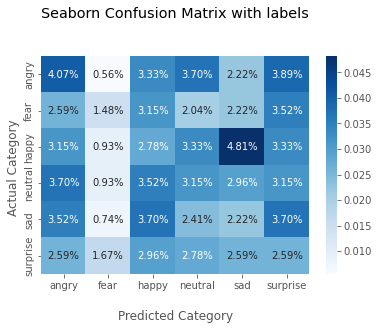

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Antrenare pe modelul VGG16 - 4

Se va schimba modelul EmotionVGG creat mai sus cu modelul VGG pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu 2 straturi de 256 de neuroni.

Rezultatele se salveaza in outputs/output11.



---



ANTRENARE

In [19]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output11'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output11/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(112,112,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
dense_layer_2 = layers.Dense(256, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dense_layer_2, prediction_layer])

for layer in base_model.layers[:15]:
  layer.trainable = False

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition11_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition11_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling model...
Epoch 1/50
13/33 [==========>...................] - ETA: 17s - loss: 1.6218 - accuracy: 0.3575

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 38s 1s/step - loss: 1.3849 - accuracy: 0.4505 - val_loss: 1.1141 - val_accuracy: 0.5273
Epoch 2/50
 2/33 [>.............................] - ETA: 23s - loss: 1.0925 - accuracy: 0.5508

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 942ms/step - loss: 1.0157 - accuracy: 0.6015 - val_loss: 0.9389 - val_accuracy: 0.6230
Epoch 3/50
12/33 [=========>....................] - ETA: 16s - loss: 0.9286 - accuracy: 0.6545

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 966ms/step - loss: 0.8860 - accuracy: 0.6564 - val_loss: 0.8129 - val_accuracy: 0.6621
Epoch 4/50
11/33 [=========>....................] - ETA: 18s - loss: 0.8335 - accuracy: 0.6768

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.7947 - accuracy: 0.6977 - val_loss: 0.8271 - val_accuracy: 0.6309
Epoch 5/50
19/33 [================>.............] - ETA: 11s - loss: 0.7215 - accuracy: 0.7287

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 950ms/step - loss: 0.7425 - accuracy: 0.7166 - val_loss: 0.8087 - val_accuracy: 0.6797
Epoch 6/50
26/33 [======================>.......] - ETA: 5s - loss: 0.6588 - accuracy: 0.7521

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 899ms/step - loss: 0.6535 - accuracy: 0.7507 - val_loss: 0.7822 - val_accuracy: 0.6797
Epoch 7/50
22/33 [===================>..........] - ETA: 8s - loss: 0.5752 - accuracy: 0.7862

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 943ms/step - loss: 0.5832 - accuracy: 0.7865 - val_loss: 0.7578 - val_accuracy: 0.7051
Epoch 8/50
14/33 [===========>..................] - ETA: 14s - loss: 0.5927 - accuracy: 0.7657

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 882ms/step - loss: 0.5745 - accuracy: 0.7790 - val_loss: 0.7899 - val_accuracy: 0.6699
Epoch 9/50
14/33 [===========>..................] - ETA: 15s - loss: 0.4929 - accuracy: 0.8209

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.4986 - accuracy: 0.8164 - val_loss: 0.8218 - val_accuracy: 0.6602
Epoch 10/50
11/33 [=========>....................] - ETA: 17s - loss: 0.4879 - accuracy: 0.8125

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 889ms/step - loss: 0.4818 - accuracy: 0.8150 - val_loss: 0.8217 - val_accuracy: 0.7012
Epoch 11/50
15/33 [============>.................] - ETA: 14s - loss: 0.4313 - accuracy: 0.8432

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.4387 - accuracy: 0.8383 - val_loss: 0.8190 - val_accuracy: 0.6816
Epoch 12/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.4132 - accuracy: 0.8415

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.4327 - accuracy: 0.8322 - val_loss: 0.7832 - val_accuracy: 0.6973
Epoch 13/50
17/33 [==============>...............] - ETA: 12s - loss: 0.3783 - accuracy: 0.8618

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 877ms/step - loss: 0.3750 - accuracy: 0.8652 - val_loss: 0.8336 - val_accuracy: 0.6992
Epoch 14/50
21/33 [==================>...........] - ETA: 9s - loss: 0.3624 - accuracy: 0.8617 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 879ms/step - loss: 0.3712 - accuracy: 0.8553 - val_loss: 0.8351 - val_accuracy: 0.7051
Epoch 15/50
21/33 [==================>...........] - ETA: 9s - loss: 0.3083 - accuracy: 0.8881 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 872ms/step - loss: 0.3230 - accuracy: 0.8854 - val_loss: 0.8078 - val_accuracy: 0.6934
Epoch 16/50
 7/33 [=====>........................] - ETA: 21s - loss: 0.2411 - accuracy: 0.9185

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 883ms/step - loss: 0.3221 - accuracy: 0.8856 - val_loss: 0.8876 - val_accuracy: 0.6797
Epoch 17/50
32/33 [============================>.] - ETA: 0s - loss: 0.2934 - accuracy: 0.8952

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 879ms/step - loss: 0.2999 - accuracy: 0.8922 - val_loss: 0.9593 - val_accuracy: 0.6797
Epoch 18/50
 5/33 [===>..........................] - ETA: 19s - loss: 0.2718 - accuracy: 0.9007

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 945ms/step - loss: 0.3175 - accuracy: 0.8800 - val_loss: 0.8700 - val_accuracy: 0.7109
Epoch 19/50
26/33 [======================>.......] - ETA: 5s - loss: 0.2583 - accuracy: 0.9094

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 878ms/step - loss: 0.2679 - accuracy: 0.9046 - val_loss: 0.9247 - val_accuracy: 0.7051
Epoch 20/50
18/33 [===============>..............] - ETA: 11s - loss: 0.2932 - accuracy: 0.8958

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 934ms/step - loss: 0.2722 - accuracy: 0.9029 - val_loss: 0.8747 - val_accuracy: 0.7246
Epoch 21/50
16/33 [=============>................] - ETA: 14s - loss: 0.2128 - accuracy: 0.9326

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.2047 - accuracy: 0.9342 - val_loss: 1.0127 - val_accuracy: 0.7188
Epoch 22/50
17/33 [==============>...............] - ETA: 12s - loss: 0.2429 - accuracy: 0.9200

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.2459 - accuracy: 0.9143 - val_loss: 0.8857 - val_accuracy: 0.7227
Epoch 23/50
25/33 [=====================>........] - ETA: 6s - loss: 0.2357 - accuracy: 0.9111

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.2434 - accuracy: 0.9080 - val_loss: 1.0062 - val_accuracy: 0.6895
Epoch 24/50
 3/33 [=>............................] - ETA: 25s - loss: 0.2599 - accuracy: 0.8932

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 875ms/step - loss: 0.1960 - accuracy: 0.9325 - val_loss: 0.9808 - val_accuracy: 0.7129
Epoch 25/50
10/33 [========>.....................] - ETA: 19s - loss: 0.1746 - accuracy: 0.9438

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 877ms/step - loss: 0.1767 - accuracy: 0.9405 - val_loss: 0.9916 - val_accuracy: 0.7109
Epoch 26/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.1446 - accuracy: 0.9523

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.1597 - accuracy: 0.9432 - val_loss: 1.1129 - val_accuracy: 0.7070
Epoch 27/50
18/33 [===============>..............] - ETA: 11s - loss: 0.1652 - accuracy: 0.9418

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 879ms/step - loss: 0.1801 - accuracy: 0.9378 - val_loss: 1.0424 - val_accuracy: 0.7207
Epoch 28/50
11/33 [=========>....................] - ETA: 17s - loss: 0.1836 - accuracy: 0.9297

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 857ms/step - loss: 0.1679 - accuracy: 0.9361 - val_loss: 1.1800 - val_accuracy: 0.7012
Epoch 29/50
24/33 [====================>.........] - ETA: 7s - loss: 0.1491 - accuracy: 0.9518

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 856ms/step - loss: 0.1445 - accuracy: 0.9536 - val_loss: 1.1103 - val_accuracy: 0.7148
Epoch 30/50
24/33 [====================>.........] - ETA: 7s - loss: 0.1327 - accuracy: 0.9502

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 861ms/step - loss: 0.1480 - accuracy: 0.9451 - val_loss: 1.2413 - val_accuracy: 0.6934
Epoch 31/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1960 - accuracy: 0.9279

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 865ms/step - loss: 0.1966 - accuracy: 0.9267 - val_loss: 1.1617 - val_accuracy: 0.6855
Epoch 32/50
27/33 [=======================>......] - ETA: 4s - loss: 0.1444 - accuracy: 0.9496

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 842ms/step - loss: 0.1447 - accuracy: 0.9490 - val_loss: 1.0908 - val_accuracy: 0.7207
Epoch 33/50
 3/33 [=>............................] - ETA: 23s - loss: 0.0971 - accuracy: 0.9635

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 847ms/step - loss: 0.1677 - accuracy: 0.9356 - val_loss: 1.0866 - val_accuracy: 0.7168
Epoch 34/50
23/33 [===================>..........] - ETA: 7s - loss: 0.1391 - accuracy: 0.9482

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 843ms/step - loss: 0.1461 - accuracy: 0.9444 - val_loss: 1.2304 - val_accuracy: 0.7148
Epoch 35/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1506 - accuracy: 0.9421

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 849ms/step - loss: 0.1465 - accuracy: 0.9461 - val_loss: 1.1212 - val_accuracy: 0.6953
Epoch 36/50
18/33 [===============>..............] - ETA: 12s - loss: 0.1451 - accuracy: 0.9540

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 859ms/step - loss: 0.1372 - accuracy: 0.9543 - val_loss: 1.1285 - val_accuracy: 0.7246
Epoch 37/50
 2/33 [>.............................] - ETA: 26s - loss: 0.1396 - accuracy: 0.9492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 845ms/step - loss: 0.1429 - accuracy: 0.9517 - val_loss: 1.1755 - val_accuracy: 0.7109
Epoch 38/50
15/33 [============>.................] - ETA: 14s - loss: 0.1081 - accuracy: 0.9615

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.1268 - accuracy: 0.9548 - val_loss: 1.1342 - val_accuracy: 0.7188
Epoch 39/50
27/33 [=======================>......] - ETA: 4s - loss: 0.1290 - accuracy: 0.9490

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 846ms/step - loss: 0.1280 - accuracy: 0.9488 - val_loss: 1.1685 - val_accuracy: 0.7227
Epoch 40/50
 2/33 [>.............................] - ETA: 21s - loss: 0.0845 - accuracy: 0.9766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 847ms/step - loss: 0.1148 - accuracy: 0.9587 - val_loss: 1.2307 - val_accuracy: 0.6934
Epoch 41/50
12/33 [=========>....................] - ETA: 16s - loss: 0.0943 - accuracy: 0.9661

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.0986 - accuracy: 0.9636 - val_loss: 1.2318 - val_accuracy: 0.7129
Epoch 42/50
 3/33 [=>............................] - ETA: 23s - loss: 0.0941 - accuracy: 0.9661

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 850ms/step - loss: 0.1408 - accuracy: 0.9512 - val_loss: 1.3594 - val_accuracy: 0.6973
Epoch 43/50
28/33 [========================>.....] - ETA: 3s - loss: 0.1035 - accuracy: 0.9638

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 847ms/step - loss: 0.1126 - accuracy: 0.9609 - val_loss: 1.3365 - val_accuracy: 0.6992
Epoch 44/50
26/33 [======================>.......] - ETA: 5s - loss: 0.1049 - accuracy: 0.9640

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 851ms/step - loss: 0.1028 - accuracy: 0.9636 - val_loss: 1.3141 - val_accuracy: 0.7012
Epoch 45/50
11/33 [=========>....................] - ETA: 16s - loss: 0.0867 - accuracy: 0.9702

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 947ms/step - loss: 0.0861 - accuracy: 0.9702 - val_loss: 1.2070 - val_accuracy: 0.7266
Epoch 46/50
20/33 [=================>............] - ETA: 10s - loss: 0.1037 - accuracy: 0.9594

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 894ms/step - loss: 0.1024 - accuracy: 0.9604 - val_loss: 1.3477 - val_accuracy: 0.7285
Epoch 47/50
23/33 [===================>..........] - ETA: 7s - loss: 0.1017 - accuracy: 0.9630

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.0969 - accuracy: 0.9633 - val_loss: 1.4032 - val_accuracy: 0.6875
Epoch 48/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.0923 - accuracy: 0.9705

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.1065 - accuracy: 0.9628 - val_loss: 1.2566 - val_accuracy: 0.7227
Epoch 49/50
25/33 [=====================>........] - ETA: 6s - loss: 0.1014 - accuracy: 0.9657

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.1022 - accuracy: 0.9662 - val_loss: 1.3973 - val_accuracy: 0.7070
Epoch 50/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.0811 - accuracy: 0.9727

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 827ms/step - loss: 0.0731 - accuracy: 0.9764 - val_loss: 1.3388 - val_accuracy: 0.7148




---



TESTARE

In [20]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output11/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output11/checkpoint1...
4/4 [==============================] - 2s 485ms/step - loss: 0.9472 - accuracy: 0.7754
              precision    recall  f1-score   support

           0       0.11      0.10      0.11        96
           1       0.14      0.15      0.14        81
           2       0.18      0.19      0.19        99
           3       0.14      0.17      0.15        94
           4       0.16      0.14      0.15        88
           5       0.06      0.05      0.06        82

    accuracy                           0.14       540
   macro avg       0.13      0.13      0.13       540
weighted avg       0.13      0.14      0.13       540

[INFO] accuracy: 77.54




---





---



ANTRENARE

In [21]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output11'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output11/checkpoint2'
start_epoch = 0

for layer in base_model.layers[15:]:
  layer.trainable = True

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition11_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition11_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/50
31/33 [===========================>..] - ETA: 1s - loss: 0.1958 - accuracy: 0.9342

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 920ms/step - loss: 0.1892 - accuracy: 0.9361 - val_loss: 1.3561 - val_accuracy: 0.7051
Epoch 2/50
29/33 [=========================>....] - ETA: 3s - loss: 0.0740 - accuracy: 0.9764

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 916ms/step - loss: 0.0738 - accuracy: 0.9762 - val_loss: 1.1915 - val_accuracy: 0.7363
Epoch 3/50
32/33 [============================>.] - ETA: 0s - loss: 0.1060 - accuracy: 0.9629

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 844ms/step - loss: 0.1047 - accuracy: 0.9636 - val_loss: 1.2279 - val_accuracy: 0.7266
Epoch 4/50
15/33 [============>.................] - ETA: 12s - loss: 0.1007 - accuracy: 0.9653

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.1003 - accuracy: 0.9643 - val_loss: 1.2063 - val_accuracy: 0.7266
Epoch 5/50
 3/33 [=>............................] - ETA: 23s - loss: 0.0729 - accuracy: 0.9740

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 933ms/step - loss: 0.0771 - accuracy: 0.9738 - val_loss: 1.2978 - val_accuracy: 0.7266
Epoch 6/50
14/33 [===========>..................] - ETA: 15s - loss: 0.0820 - accuracy: 0.9743

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 842ms/step - loss: 0.0961 - accuracy: 0.9660 - val_loss: 1.2401 - val_accuracy: 0.7344
Epoch 7/50
19/33 [================>.............] - ETA: 11s - loss: 0.0809 - accuracy: 0.9721

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 978ms/step - loss: 0.1038 - accuracy: 0.9619 - val_loss: 1.3488 - val_accuracy: 0.7070
Epoch 8/50
24/33 [====================>.........] - ETA: 8s - loss: 0.0863 - accuracy: 0.9674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 32s 976ms/step - loss: 0.1047 - accuracy: 0.9611 - val_loss: 1.2854 - val_accuracy: 0.7051
Epoch 9/50
31/33 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9591

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 896ms/step - loss: 0.1231 - accuracy: 0.9594 - val_loss: 1.1810 - val_accuracy: 0.7246
Epoch 10/50
25/33 [=====================>........] - ETA: 5s - loss: 0.0926 - accuracy: 0.9661

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 832ms/step - loss: 0.0937 - accuracy: 0.9653 - val_loss: 1.3616 - val_accuracy: 0.7285
Epoch 11/50
15/33 [============>.................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9745

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 829ms/step - loss: 0.0762 - accuracy: 0.9728 - val_loss: 1.4475 - val_accuracy: 0.7129
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.0806 - accuracy: 0.9718 - val_loss: 1.4022 - val_accuracy: 0.7363
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0747 - accuracy: 0.9764 - val_loss: 1.3640 - val_accuracy: 0.7188
Epoch 14/50
20/33 [=================>............] - ETA: 9s - loss: 0.0750 - accuracy: 0.9735 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 827ms/step - loss: 0.0706 - accuracy: 0.9735 - val_loss: 1.3663 - val_accuracy: 0.7109
Epoch 15/50
10/33 [========>.....................] - ETA: 18s - loss: 0.0908 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.0926 - accuracy: 0.9665 - val_loss: 1.3706 - val_accuracy: 0.7109
Epoch 16/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.0604 - accuracy: 0.9824

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0813 - accuracy: 0.9716 - val_loss: 1.3780 - val_accuracy: 0.7148
Epoch 17/50
18/33 [===============>..............] - ETA: 11s - loss: 0.0944 - accuracy: 0.9644

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 841ms/step - loss: 0.0888 - accuracy: 0.9679 - val_loss: 1.4076 - val_accuracy: 0.7207
Epoch 18/50
32/33 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9719

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.0695 - accuracy: 0.9726 - val_loss: 1.3809 - val_accuracy: 0.7324
Epoch 19/50
29/33 [=========================>....] - ETA: 3s - loss: 0.0648 - accuracy: 0.9775

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 1.4214 - val_accuracy: 0.7090
Epoch 20/50
20/33 [=================>............] - ETA: 10s - loss: 0.0751 - accuracy: 0.9730

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 831ms/step - loss: 0.0782 - accuracy: 0.9721 - val_loss: 1.4286 - val_accuracy: 0.7188
Epoch 21/50
18/33 [===============>..............] - ETA: 11s - loss: 0.0811 - accuracy: 0.9674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 836ms/step - loss: 0.0837 - accuracy: 0.9675 - val_loss: 1.3837 - val_accuracy: 0.7227
Epoch 22/50
14/33 [===========>..................] - ETA: 14s - loss: 0.0550 - accuracy: 0.9822

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.0651 - accuracy: 0.9791 - val_loss: 1.4905 - val_accuracy: 0.7070
Epoch 23/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0625 - accuracy: 0.9757

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 828ms/step - loss: 0.0649 - accuracy: 0.9752 - val_loss: 1.4340 - val_accuracy: 0.7188
Epoch 24/50
28/33 [========================>.....] - ETA: 3s - loss: 0.0738 - accuracy: 0.9721

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.0795 - accuracy: 0.9711 - val_loss: 1.6197 - val_accuracy: 0.7207
Epoch 25/50
12/33 [=========>....................] - ETA: 16s - loss: 0.1215 - accuracy: 0.9544

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 829ms/step - loss: 0.1138 - accuracy: 0.9575 - val_loss: 1.3470 - val_accuracy: 0.7207
Epoch 26/50
 4/33 [==>...........................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.0690 - accuracy: 0.9750 - val_loss: 1.4889 - val_accuracy: 0.6992
Epoch 27/50
15/33 [============>.................] - ETA: 13s - loss: 0.0761 - accuracy: 0.9724

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 833ms/step - loss: 0.0762 - accuracy: 0.9745 - val_loss: 1.4221 - val_accuracy: 0.7090
Epoch 28/50
 1/33 [..............................] - ETA: 34s - loss: 0.0653 - accuracy: 0.9844

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.0709 - accuracy: 0.9757 - val_loss: 1.6471 - val_accuracy: 0.6699
Epoch 29/50
 1/33 [..............................] - ETA: 28s - loss: 0.2410 - accuracy: 0.8906

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.1461 - accuracy: 0.9441 - val_loss: 1.4636 - val_accuracy: 0.6973
Epoch 30/50
12/33 [=========>....................] - ETA: 15s - loss: 0.0903 - accuracy: 0.9678

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.0880 - accuracy: 0.9706 - val_loss: 1.4884 - val_accuracy: 0.7051
Epoch 31/50
14/33 [===========>..................] - ETA: 13s - loss: 0.0777 - accuracy: 0.9715

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 831ms/step - loss: 0.0704 - accuracy: 0.9738 - val_loss: 1.5890 - val_accuracy: 0.7031
Epoch 32/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0454 - accuracy: 0.9832

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.0448 - accuracy: 0.9837 - val_loss: 1.4409 - val_accuracy: 0.7227
Epoch 33/50
32/33 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9800

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 837ms/step - loss: 0.0534 - accuracy: 0.9804 - val_loss: 1.5733 - val_accuracy: 0.7266
Epoch 34/50
15/33 [============>.................] - ETA: 13s - loss: 0.0365 - accuracy: 0.9875

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 832ms/step - loss: 0.0427 - accuracy: 0.9854 - val_loss: 1.6480 - val_accuracy: 0.6953
Epoch 35/50
33/33 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9777

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.0635 - accuracy: 0.9777 - val_loss: 1.5157 - val_accuracy: 0.7109
Epoch 36/50
 1/33 [..............................] - ETA: 28s - loss: 0.0262 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0491 - accuracy: 0.9815 - val_loss: 1.5395 - val_accuracy: 0.7207
Epoch 37/50
25/33 [=====================>........] - ETA: 5s - loss: 0.0608 - accuracy: 0.9803

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.0619 - accuracy: 0.9796 - val_loss: 1.6732 - val_accuracy: 0.7090
Epoch 38/50
 1/33 [..............................] - ETA: 29s - loss: 0.0360 - accuracy: 0.9844

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 830ms/step - loss: 0.0594 - accuracy: 0.9803 - val_loss: 1.5987 - val_accuracy: 0.7148
Epoch 39/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.1148 - accuracy: 0.9587

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.0728 - accuracy: 0.9745 - val_loss: 1.5226 - val_accuracy: 0.7305
Epoch 40/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0490 - accuracy: 0.9814

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 832ms/step - loss: 0.0490 - accuracy: 0.9815 - val_loss: 1.6229 - val_accuracy: 0.7266
Epoch 41/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0560 - accuracy: 0.9797

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 851ms/step - loss: 0.0551 - accuracy: 0.9803 - val_loss: 1.3977 - val_accuracy: 0.7285
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 840ms/step - loss: 0.0566 - accuracy: 0.9796 - val_loss: 1.6054 - val_accuracy: 0.7109
Epoch 43/50
28/33 [========================>.....] - ETA: 3s - loss: 0.0542 - accuracy: 0.9827

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 838ms/step - loss: 0.0544 - accuracy: 0.9830 - val_loss: 1.6557 - val_accuracy: 0.7109
Epoch 44/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0503 - accuracy: 0.9815

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0529 - accuracy: 0.9798 - val_loss: 1.5278 - val_accuracy: 0.7227
Epoch 45/50
32/33 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9689

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 911ms/step - loss: 0.0788 - accuracy: 0.9696 - val_loss: 1.5168 - val_accuracy: 0.7402
Epoch 46/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.0583 - accuracy: 0.9805

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 825ms/step - loss: 0.0501 - accuracy: 0.9832 - val_loss: 1.6943 - val_accuracy: 0.6973
Epoch 47/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.0437 - accuracy: 0.9831

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0659 - accuracy: 0.9769 - val_loss: 1.4729 - val_accuracy: 0.7285
Epoch 48/50
12/33 [=========>....................] - ETA: 16s - loss: 0.0408 - accuracy: 0.9863

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 831ms/step - loss: 0.0454 - accuracy: 0.9859 - val_loss: 1.6297 - val_accuracy: 0.7188
Epoch 49/50
16/33 [=============>................] - ETA: 12s - loss: 0.0584 - accuracy: 0.9809

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.0538 - accuracy: 0.9794 - val_loss: 1.6765 - val_accuracy: 0.7090
Epoch 50/50
 5/33 [===>..........................] - ETA: 22s - loss: 0.0418 - accuracy: 0.9891

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.0441 - accuracy: 0.9840 - val_loss: 1.5585 - val_accuracy: 0.7207




---



TESTARE

In [22]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output11/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output11/checkpoint2...
4/4 [==============================] - 2s 458ms/step - loss: 1.2275 - accuracy: 0.7734
              precision    recall  f1-score   support

           0       0.18      0.18      0.18        96
           1       0.16      0.11      0.13        81
           2       0.26      0.28      0.27        99
           3       0.17      0.19      0.18        94
           4       0.19      0.15      0.17        88
           5       0.22      0.29      0.25        82

    accuracy                           0.20       540
   macro avg       0.20      0.20      0.20       540
weighted avg       0.20      0.20      0.20       540

[INFO] accuracy: 77.34


Matrice de confuzie

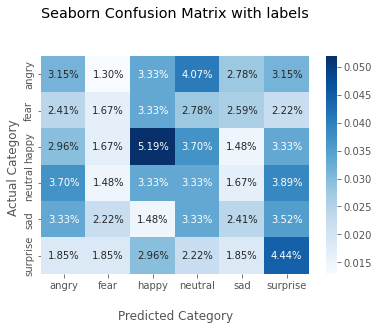

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Antrenare pe modelul VGG16 - 5

Se va schimba modelul EmotionVGG creat mai sus cu modelul VGG pentru a testa pe un model preantrenat.

In plus, se va face fine-tuning cu 2 straturi de 512 de neuroni.

Rezultatele se salveaza in outputs/output12.



---



ANTRENARE

In [24]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import argparse
import os
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output12'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output12/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(112,112,3))
base_model.trainable = False ## Not trainable weights

## Add last layers

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dense_layer_2 = layers.Dense(512, activation='relu')
prediction_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([base_model, flatten_layer, dense_layer_1, dense_layer_2, prediction_layer])

for layer in base_model.layers[:15]:
  layer.trainable = False

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition12_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition12_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling model...
Epoch 1/50
 5/33 [===>..........................] - ETA: 22s - loss: 2.0777 - accuracy: 0.2438

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 920ms/step - loss: 1.4201 - accuracy: 0.4378 - val_loss: 1.0841 - val_accuracy: 0.5527
Epoch 2/50
 2/33 [>.............................] - ETA: 21s - loss: 0.9330 - accuracy: 0.6641

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 924ms/step - loss: 0.9818 - accuracy: 0.6224 - val_loss: 0.9513 - val_accuracy: 0.6172
Epoch 3/50
23/33 [===================>..........] - ETA: 7s - loss: 0.8775 - accuracy: 0.6561

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 902ms/step - loss: 0.8537 - accuracy: 0.6656 - val_loss: 0.8675 - val_accuracy: 0.6543
Epoch 4/50
13/33 [==========>...................] - ETA: 15s - loss: 0.7336 - accuracy: 0.7314

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 917ms/step - loss: 0.7616 - accuracy: 0.7101 - val_loss: 0.8540 - val_accuracy: 0.6641
Epoch 5/50
18/33 [===============>..............] - ETA: 11s - loss: 0.7461 - accuracy: 0.7202

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 897ms/step - loss: 0.7043 - accuracy: 0.7365 - val_loss: 0.7722 - val_accuracy: 0.7012
Epoch 6/50
18/33 [===============>..............] - ETA: 11s - loss: 0.5807 - accuracy: 0.7843

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.6187 - accuracy: 0.7627 - val_loss: 0.7373 - val_accuracy: 0.6934
Epoch 7/50
29/33 [=========================>....] - ETA: 3s - loss: 0.5651 - accuracy: 0.7826

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 897ms/step - loss: 0.5695 - accuracy: 0.7817 - val_loss: 0.7530 - val_accuracy: 0.7090
Epoch 8/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.5257 - accuracy: 0.7979

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.5464 - accuracy: 0.7885 - val_loss: 0.8486 - val_accuracy: 0.6641
Epoch 9/50
18/33 [===============>..............] - ETA: 11s - loss: 0.5142 - accuracy: 0.8077

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 908ms/step - loss: 0.5026 - accuracy: 0.8103 - val_loss: 0.7414 - val_accuracy: 0.7109
Epoch 10/50
13/33 [==========>...................] - ETA: 15s - loss: 0.4405 - accuracy: 0.8377

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.4349 - accuracy: 0.8381 - val_loss: 0.8743 - val_accuracy: 0.6758
Epoch 11/50
32/33 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8328

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.4453 - accuracy: 0.8307 - val_loss: 0.8387 - val_accuracy: 0.6836
Epoch 12/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3701 - accuracy: 0.8682

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.3776 - accuracy: 0.8626 - val_loss: 1.0039 - val_accuracy: 0.6758
Epoch 13/50
16/33 [=============>................] - ETA: 12s - loss: 0.3840 - accuracy: 0.8608

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.3662 - accuracy: 0.8628 - val_loss: 0.9545 - val_accuracy: 0.6660
Epoch 14/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3217 - accuracy: 0.8824

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.3134 - accuracy: 0.8881 - val_loss: 0.8518 - val_accuracy: 0.7051
Epoch 15/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.2856 - accuracy: 0.8997

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.2745 - accuracy: 0.9021 - val_loss: 1.0924 - val_accuracy: 0.6895
Epoch 16/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3293 - accuracy: 0.8778

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 816ms/step - loss: 0.3162 - accuracy: 0.8832 - val_loss: 0.9048 - val_accuracy: 0.7031
Epoch 17/50
12/33 [=========>....................] - ETA: 15s - loss: 0.2890 - accuracy: 0.8919

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.2808 - accuracy: 0.8922 - val_loss: 1.0101 - val_accuracy: 0.6895
Epoch 18/50
17/33 [==============>...............] - ETA: 12s - loss: 0.2683 - accuracy: 0.8943

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.2515 - accuracy: 0.9041 - val_loss: 1.0173 - val_accuracy: 0.7051
Epoch 19/50
27/33 [=======================>......] - ETA: 4s - loss: 0.2397 - accuracy: 0.9140

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 827ms/step - loss: 0.2370 - accuracy: 0.9145 - val_loss: 1.0202 - val_accuracy: 0.6973
Epoch 20/50
11/33 [=========>....................] - ETA: 17s - loss: 0.2048 - accuracy: 0.9240

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 829ms/step - loss: 0.2180 - accuracy: 0.9162 - val_loss: 1.0028 - val_accuracy: 0.6953
Epoch 21/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9180

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 893ms/step - loss: 0.1845 - accuracy: 0.9352 - val_loss: 1.0387 - val_accuracy: 0.7227
Epoch 22/50
16/33 [=============>................] - ETA: 13s - loss: 0.1626 - accuracy: 0.9443

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 831ms/step - loss: 0.1747 - accuracy: 0.9388 - val_loss: 1.0517 - val_accuracy: 0.7129
Epoch 23/50
21/33 [==================>...........] - ETA: 8s - loss: 0.1678 - accuracy: 0.9380

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 901ms/step - loss: 0.1685 - accuracy: 0.9361 - val_loss: 0.9815 - val_accuracy: 0.7266
Epoch 24/50
13/33 [==========>...................] - ETA: 15s - loss: 0.1858 - accuracy: 0.9393

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.1970 - accuracy: 0.9296 - val_loss: 1.0163 - val_accuracy: 0.7129
Epoch 25/50
 1/33 [..............................] - ETA: 28s - loss: 0.1532 - accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.1804 - accuracy: 0.9293 - val_loss: 1.0867 - val_accuracy: 0.7031
Epoch 26/50
24/33 [====================>.........] - ETA: 6s - loss: 0.1605 - accuracy: 0.9407

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 841ms/step - loss: 0.1630 - accuracy: 0.9415 - val_loss: 1.0538 - val_accuracy: 0.7109
Epoch 27/50
20/33 [=================>............] - ETA: 10s - loss: 0.1395 - accuracy: 0.9492

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.1616 - accuracy: 0.9415 - val_loss: 1.1572 - val_accuracy: 0.7090
Epoch 28/50
 5/33 [===>..........................] - ETA: 21s - loss: 0.1593 - accuracy: 0.9469

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.2092 - accuracy: 0.9259 - val_loss: 1.0237 - val_accuracy: 0.7168
Epoch 29/50
17/33 [==============>...............] - ETA: 12s - loss: 0.1767 - accuracy: 0.9338

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.1844 - accuracy: 0.9344 - val_loss: 1.0919 - val_accuracy: 0.6816
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 836ms/step - loss: 0.1423 - accuracy: 0.9473 - val_loss: 1.1772 - val_accuracy: 0.7031
Epoch 31/50
19/33 [================>.............] - ETA: 11s - loss: 0.1333 - accuracy: 0.9482

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 827ms/step - loss: 0.1448 - accuracy: 0.9475 - val_loss: 1.2089 - val_accuracy: 0.6895
Epoch 32/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9414

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.1264 - accuracy: 0.9560 - val_loss: 1.1728 - val_accuracy: 0.7207
Epoch 33/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.1192 - accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.1405 - accuracy: 0.9502 - val_loss: 1.2059 - val_accuracy: 0.6992
Epoch 34/50
27/33 [=======================>......] - ETA: 4s - loss: 0.1029 - accuracy: 0.9653

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.1117 - accuracy: 0.9624 - val_loss: 1.0820 - val_accuracy: 0.7246
Epoch 35/50
23/33 [===================>..........] - ETA: 7s - loss: 0.1482 - accuracy: 0.9497

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 823ms/step - loss: 0.1460 - accuracy: 0.9502 - val_loss: 1.2559 - val_accuracy: 0.6992
Epoch 36/50
28/33 [========================>.....] - ETA: 3s - loss: 0.1545 - accuracy: 0.9436

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.1545 - accuracy: 0.9424 - val_loss: 1.3018 - val_accuracy: 0.6934
Epoch 37/50
18/33 [===============>..............] - ETA: 11s - loss: 0.1454 - accuracy: 0.9472

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.1342 - accuracy: 0.9519 - val_loss: 1.2290 - val_accuracy: 0.7148
Epoch 38/50
13/33 [==========>...................] - ETA: 14s - loss: 0.1041 - accuracy: 0.9628

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.1319 - accuracy: 0.9524 - val_loss: 1.2371 - val_accuracy: 0.7188
Epoch 39/50
26/33 [======================>.......] - ETA: 5s - loss: 0.1157 - accuracy: 0.9590

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 838ms/step - loss: 0.1124 - accuracy: 0.9611 - val_loss: 1.3012 - val_accuracy: 0.6895
Epoch 40/50
 2/33 [>.............................] - ETA: 24s - loss: 0.0779 - accuracy: 0.9727

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.0874 - accuracy: 0.9692 - val_loss: 1.2963 - val_accuracy: 0.7090
Epoch 41/50
13/33 [==========>...................] - ETA: 15s - loss: 0.1211 - accuracy: 0.9573

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 848ms/step - loss: 0.1255 - accuracy: 0.9548 - val_loss: 1.1986 - val_accuracy: 0.7227
Epoch 42/50
13/33 [==========>...................] - ETA: 14s - loss: 0.0893 - accuracy: 0.9692

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0926 - accuracy: 0.9655 - val_loss: 1.2883 - val_accuracy: 0.7168
Epoch 43/50
11/33 [=========>....................] - ETA: 15s - loss: 0.1074 - accuracy: 0.9685

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 831ms/step - loss: 0.0975 - accuracy: 0.9684 - val_loss: 1.3006 - val_accuracy: 0.7129
Epoch 44/50
17/33 [==============>...............] - ETA: 12s - loss: 0.0684 - accuracy: 0.9766

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 829ms/step - loss: 0.0728 - accuracy: 0.9750 - val_loss: 1.2788 - val_accuracy: 0.7090
Epoch 45/50
 9/33 [=======>......................] - ETA: 16s - loss: 0.0612 - accuracy: 0.9809

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.0698 - accuracy: 0.9757 - val_loss: 1.4092 - val_accuracy: 0.7109
Epoch 46/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.0929 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 826ms/step - loss: 0.0818 - accuracy: 0.9701 - val_loss: 1.3230 - val_accuracy: 0.6992
Epoch 47/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0689 - accuracy: 0.9764

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.0708 - accuracy: 0.9757 - val_loss: 1.3147 - val_accuracy: 0.7266
Epoch 48/50
23/33 [===================>..........] - ETA: 7s - loss: 0.0578 - accuracy: 0.9792

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.0612 - accuracy: 0.9789 - val_loss: 1.3898 - val_accuracy: 0.7031
Epoch 49/50
11/33 [=========>....................] - ETA: 16s - loss: 0.0638 - accuracy: 0.9744

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 902ms/step - loss: 0.0722 - accuracy: 0.9735 - val_loss: 1.4107 - val_accuracy: 0.7324
Epoch 50/50
25/33 [=====================>........] - ETA: 5s - loss: 0.1229 - accuracy: 0.9570

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 834ms/step - loss: 0.1283 - accuracy: 0.9534 - val_loss: 1.5343 - val_accuracy: 0.7012




---



TESTARE

In [25]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output12/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output12/checkpoint1...
4/4 [==============================] - 2s 484ms/step - loss: 1.0744 - accuracy: 0.7773
              precision    recall  f1-score   support

           0       0.16      0.16      0.16        96
           1       0.16      0.14      0.15        81
           2       0.22      0.21      0.22        99
           3       0.17      0.20      0.19        94
           4       0.17      0.12      0.14        88
           5       0.12      0.17      0.14        82

    accuracy                           0.17       540
   macro avg       0.17      0.17      0.17       540
weighted avg       0.17      0.17      0.17       540

[INFO] accuracy: 77.73




---





---



ANTRENARE

In [26]:
output = '/content/drive/MyDrive/GitHub/licenta/outputs/output12'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output12/checkpoint2'
start_epoch = 0

for layer in base_model.layers[15:]:
  layer.trainable = True

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition12_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition12_2.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/50
27/33 [=======================>......] - ETA: 4s - loss: 0.1507 - accuracy: 0.9481

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 31s 910ms/step - loss: 0.1444 - accuracy: 0.9502 - val_loss: 1.2576 - val_accuracy: 0.7129
Epoch 2/50
14/33 [===========>..................] - ETA: 15s - loss: 0.0682 - accuracy: 0.9788

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 846ms/step - loss: 0.0787 - accuracy: 0.9738 - val_loss: 1.4887 - val_accuracy: 0.6992
Epoch 3/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0731 - accuracy: 0.9754

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 829ms/step - loss: 0.0750 - accuracy: 0.9747 - val_loss: 1.5912 - val_accuracy: 0.7129
Epoch 4/50
29/33 [=========================>....] - ETA: 3s - loss: 0.1182 - accuracy: 0.9584

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 910ms/step - loss: 0.1123 - accuracy: 0.9599 - val_loss: 1.2403 - val_accuracy: 0.7480
Epoch 5/50
 2/33 [>.............................] - ETA: 28s - loss: 0.0884 - accuracy: 0.9733

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 850ms/step - loss: 0.0741 - accuracy: 0.9745 - val_loss: 1.3894 - val_accuracy: 0.7227
Epoch 6/50
12/33 [=========>....................] - ETA: 16s - loss: 0.0681 - accuracy: 0.9753

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 825ms/step - loss: 0.0683 - accuracy: 0.9755 - val_loss: 1.4744 - val_accuracy: 0.7148
Epoch 7/50
31/33 [===========================>..] - ETA: 1s - loss: 0.1047 - accuracy: 0.9627

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.1034 - accuracy: 0.9626 - val_loss: 1.3377 - val_accuracy: 0.7207
Epoch 8/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.0759 - accuracy: 0.9701

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.0886 - accuracy: 0.9682 - val_loss: 1.3836 - val_accuracy: 0.7266
Epoch 9/50
 9/33 [=======>......................] - ETA: 19s - loss: 0.0733 - accuracy: 0.9714

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.0690 - accuracy: 0.9735 - val_loss: 1.4228 - val_accuracy: 0.7285
Epoch 10/50
21/33 [==================>...........] - ETA: 8s - loss: 0.0849 - accuracy: 0.9729

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.1129 - accuracy: 0.9609 - val_loss: 1.6446 - val_accuracy: 0.7129
Epoch 11/50
 6/33 [====>.........................] - ETA: 20s - loss: 0.0785 - accuracy: 0.9674

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0928 - accuracy: 0.9665 - val_loss: 1.3563 - val_accuracy: 0.7305
Epoch 12/50
27/33 [=======================>......] - ETA: 4s - loss: 0.0927 - accuracy: 0.9682

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 832ms/step - loss: 0.0877 - accuracy: 0.9692 - val_loss: 1.3311 - val_accuracy: 0.7441
Epoch 13/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.0544 - accuracy: 0.9779

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 854ms/step - loss: 0.0709 - accuracy: 0.9743 - val_loss: 1.5684 - val_accuracy: 0.7285
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 848ms/step - loss: 0.1014 - accuracy: 0.9641 - val_loss: 1.4990 - val_accuracy: 0.7422
Epoch 15/50
33/33 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.0731 - accuracy: 0.9750 - val_loss: 1.4587 - val_accuracy: 0.7266
Epoch 16/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.0947 - accuracy: 0.9609

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 907ms/step - loss: 0.0754 - accuracy: 0.9687 - val_loss: 1.3075 - val_accuracy: 0.7520
Epoch 17/50
33/33 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9786

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 834ms/step - loss: 0.0585 - accuracy: 0.9786 - val_loss: 1.3949 - val_accuracy: 0.7383
Epoch 18/50
25/33 [=====================>........] - ETA: 5s - loss: 0.0684 - accuracy: 0.9741

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.0722 - accuracy: 0.9733 - val_loss: 1.3685 - val_accuracy: 0.7363
Epoch 19/50
 9/33 [=======>......................] - ETA: 18s - loss: 0.0648 - accuracy: 0.9800

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.0743 - accuracy: 0.9740 - val_loss: 1.4384 - val_accuracy: 0.7285
Epoch 20/50
26/33 [======================>.......] - ETA: 5s - loss: 0.0779 - accuracy: 0.9739

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 836ms/step - loss: 0.0780 - accuracy: 0.9735 - val_loss: 1.2981 - val_accuracy: 0.7383
Epoch 21/50
 2/33 [>.............................] - ETA: 25s - loss: 0.0248 - accuracy: 0.9961

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.0765 - accuracy: 0.9762 - val_loss: 1.4520 - val_accuracy: 0.7285
Epoch 22/50
16/33 [=============>................] - ETA: 12s - loss: 0.0858 - accuracy: 0.9686

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 829ms/step - loss: 0.0860 - accuracy: 0.9687 - val_loss: 1.4397 - val_accuracy: 0.7227
Epoch 23/50
 5/33 [===>..........................] - ETA: 20s - loss: 0.1013 - accuracy: 0.9663

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 849ms/step - loss: 0.0764 - accuracy: 0.9718 - val_loss: 1.3648 - val_accuracy: 0.7324
Epoch 24/50
16/33 [=============>................] - ETA: 13s - loss: 0.0530 - accuracy: 0.9824

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.0599 - accuracy: 0.9779 - val_loss: 1.3265 - val_accuracy: 0.7266
Epoch 25/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0554 - accuracy: 0.9816

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 841ms/step - loss: 0.0560 - accuracy: 0.9818 - val_loss: 1.3526 - val_accuracy: 0.7188
Epoch 26/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.0511 - accuracy: 0.9810

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 836ms/step - loss: 0.0502 - accuracy: 0.9830 - val_loss: 1.4598 - val_accuracy: 0.7344
Epoch 27/50
32/33 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9822

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.0550 - accuracy: 0.9823 - val_loss: 1.7022 - val_accuracy: 0.7109
Epoch 28/50
 2/33 [>.............................] - ETA: 24s - loss: 0.1236 - accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 834ms/step - loss: 0.0807 - accuracy: 0.9692 - val_loss: 1.4493 - val_accuracy: 0.7227
Epoch 29/50
 9/33 [=======>......................] - ETA: 19s - loss: 0.1623 - accuracy: 0.9465

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 856ms/step - loss: 0.0924 - accuracy: 0.9677 - val_loss: 1.3595 - val_accuracy: 0.7383
Epoch 30/50
28/33 [========================>.....] - ETA: 3s - loss: 0.0745 - accuracy: 0.9747

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.0718 - accuracy: 0.9752 - val_loss: 1.5972 - val_accuracy: 0.7246
Epoch 31/50
12/33 [=========>....................] - ETA: 16s - loss: 0.0500 - accuracy: 0.9831

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0572 - accuracy: 0.9781 - val_loss: 1.5586 - val_accuracy: 0.7227
Epoch 32/50
 1/33 [..............................] - ETA: 32s - loss: 0.0601 - accuracy: 0.9688

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 827ms/step - loss: 0.0720 - accuracy: 0.9743 - val_loss: 1.6018 - val_accuracy: 0.7227
Epoch 33/50
12/33 [=========>....................] - ETA: 16s - loss: 0.0798 - accuracy: 0.9713

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 853ms/step - loss: 0.0821 - accuracy: 0.9689 - val_loss: 1.3708 - val_accuracy: 0.7285
Epoch 34/50
30/33 [==========================>...] - ETA: 2s - loss: 0.0472 - accuracy: 0.9826

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 839ms/step - loss: 0.0481 - accuracy: 0.9820 - val_loss: 1.4163 - val_accuracy: 0.7188
Epoch 35/50
24/33 [====================>.........] - ETA: 6s - loss: 0.0423 - accuracy: 0.9862

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.0468 - accuracy: 0.9849 - val_loss: 1.6654 - val_accuracy: 0.7246
Epoch 36/50
28/33 [========================>.....] - ETA: 3s - loss: 0.0479 - accuracy: 0.9830

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 831ms/step - loss: 0.0444 - accuracy: 0.9847 - val_loss: 1.4556 - val_accuracy: 0.7422
Epoch 37/50
31/33 [===========================>..] - ETA: 1s - loss: 0.0423 - accuracy: 0.9846

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 30s 914ms/step - loss: 0.0425 - accuracy: 0.9848 - val_loss: 1.4924 - val_accuracy: 0.7539
Epoch 38/50
28/33 [========================>.....] - ETA: 3s - loss: 0.0462 - accuracy: 0.9836

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 831ms/step - loss: 0.0466 - accuracy: 0.9835 - val_loss: 1.4461 - val_accuracy: 0.7402
Epoch 39/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.0334 - accuracy: 0.9900

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0546 - accuracy: 0.9823 - val_loss: 1.5293 - val_accuracy: 0.7148
Epoch 40/50
22/33 [===================>..........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9889

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 832ms/step - loss: 0.0473 - accuracy: 0.9840 - val_loss: 1.4187 - val_accuracy: 0.7246
Epoch 41/50
 2/33 [>.............................] - ETA: 27s - loss: 0.0545 - accuracy: 0.9805

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.0644 - accuracy: 0.9764 - val_loss: 1.7718 - val_accuracy: 0.6914
Epoch 42/50
10/33 [========>.....................] - ETA: 16s - loss: 0.0691 - accuracy: 0.9736

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 837ms/step - loss: 0.0675 - accuracy: 0.9752 - val_loss: 1.5079 - val_accuracy: 0.7266
Epoch 43/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.0491 - accuracy: 0.9814

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 830ms/step - loss: 0.0527 - accuracy: 0.9832 - val_loss: 1.4927 - val_accuracy: 0.7168
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 829ms/step - loss: 0.0400 - accuracy: 0.9866 - val_loss: 1.6121 - val_accuracy: 0.7246
Epoch 45/50
20/33 [=================>............] - ETA: 9s - loss: 0.0465 - accuracy: 0.9800 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.0452 - accuracy: 0.9828 - val_loss: 1.6227 - val_accuracy: 0.7344
Epoch 46/50
32/33 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9865

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 829ms/step - loss: 0.0357 - accuracy: 0.9864 - val_loss: 1.5776 - val_accuracy: 0.7148
Epoch 47/50
21/33 [==================>...........] - ETA: 8s - loss: 0.0438 - accuracy: 0.9845

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 835ms/step - loss: 0.0439 - accuracy: 0.9849 - val_loss: 1.6174 - val_accuracy: 0.7344
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.0405 - accuracy: 0.9857 - val_loss: 1.6282 - val_accuracy: 0.7402
Epoch 49/50
25/33 [=====================>........] - ETA: 5s - loss: 0.0411 - accuracy: 0.9864

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 825ms/step - loss: 0.0428 - accuracy: 0.9857 - val_loss: 1.7110 - val_accuracy: 0.7363
Epoch 50/50
 5/33 [===>..........................] - ETA: 15s - loss: 0.0656 - accuracy: 0.9738

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.0613 - accuracy: 0.9777 - val_loss: 1.8069 - val_accuracy: 0.7148




---



TESTARE

In [27]:
model = '/content/drive/MyDrive/GitHub/licenta/outputs/output12/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output12/checkpoint2...
4/4 [==============================] - 2s 480ms/step - loss: 1.1063 - accuracy: 0.7676
              precision    recall  f1-score   support

           0       0.21      0.23      0.22        96
           1       0.16      0.12      0.14        81
           2       0.18      0.17      0.17        99
           3       0.17      0.18      0.18        94
           4       0.27      0.27      0.27        88
           5       0.22      0.24      0.23        82

    accuracy                           0.20       540
   macro avg       0.20      0.20      0.20       540
weighted avg       0.20      0.20      0.20       540

[INFO] accuracy: 76.76


Matrice de confuzie

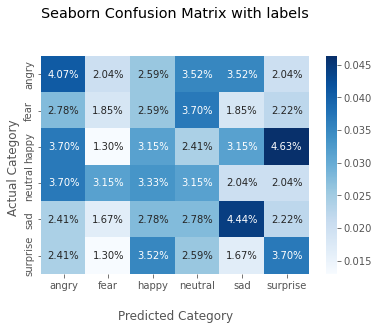

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# //Antrenare pe modelul VGG - 2// - ignore

Se va folosi fine-tuningul facut in cartea "Invatare profunda in viziunea artificiala" (Daniel Octavian Melinte, Luige Vladareanu, Ana Maria Travediu)

Rezultatele obtinute se vor afla in /outputs/output9.



---



ANTRENARE RCC

Se va salva graficul cu numele "facial_emotion_recognition9_1.png" si cel mai bun model se va salva in /outputs/checkpoint1

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten, Dropout

output = '/content/drive/MyDrive/GitHub/licenta/outputs/output9'
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1'
model = None
start_epoch = 0

train_datagen = ImageDataGenerator( rotation_range = 10, rescale = 1 / 255.0, zoom_range = 0.1, horizontal_flip = True, fill_mode = "nearest")
val_datagen = ImageDataGenerator(rescale = 1 / 255.0)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/GitHub/licenta/dataset_fer/train', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')
val_generator = val_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/val', target_size = (112, 112), batch_size = 128, class_mode = 'categorical')


# FOLOSIRE VGG16

## Loading VGG16 model

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(112,112,3))

## reteaua complet conectata

headModel = base_model.output
headModel = Flatten(name="flatten")(headModel) # harta de caracteristici de pe ultimul strat conv este aplatizat

## antrenati ulterior doar 50% din neuronii de pe stratul ascuns 
headModel = Dense(512, activation="relu")(headModel) 
headModel = Dropout(0.5)(headModel)

## pentru clasificare se utilizeaza functia Softmax

predictions = Dense(6, activation = "softmax")(headModel)

# modelul antrenat pt initializare

model = Model(inputs = base_model.input, outputs = predictions)

# antrenare doar RCC

for layer in base_model.layers:
  layer.trainable = False

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition9_1.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition9_1.json"])
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

Found 4246 images belonging to 6 classes.
Found 529 images belonging to 6 classes.
[INFO] compiling model...
Epoch 1/50
32/33 [============================>.] - ETA: 13s - loss: 1.6633 - accuracy: 0.3920

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 659s 20s/step - loss: 1.6495 - accuracy: 0.3953 - val_loss: 1.1717 - val_accuracy: 0.5312
Epoch 2/50
21/33 [==================>...........] - ETA: 8s - loss: 1.1746 - accuracy: 0.5364

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 869ms/step - loss: 1.1510 - accuracy: 0.5449 - val_loss: 1.0242 - val_accuracy: 0.5898
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.6034

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


INFO:tensorflow:Assets written to: /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1/assets
33/33 [==============================] - 29s 867ms/step - loss: 1.0271 - accuracy: 0.6034 - val_loss: 0.9069 - val_accuracy: 0.6445
Epoch 4/50
 3/33 [=>............................] - ETA: 22s - loss: 0.9424 - accuracy: 0.6302

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.9574 - accuracy: 0.6331 - val_loss: 0.9039 - val_accuracy: 0.6211
Epoch 5/50
26/33 [======================>.......] - ETA: 4s - loss: 0.9431 - accuracy: 0.6279

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 854ms/step - loss: 0.9366 - accuracy: 0.6326 - val_loss: 0.8719 - val_accuracy: 0.6582
Epoch 6/50
29/33 [=========================>....] - ETA: 2s - loss: 0.8566 - accuracy: 0.6672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 867ms/step - loss: 0.8635 - accuracy: 0.6659 - val_loss: 0.7993 - val_accuracy: 0.6855
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.8090 - accuracy: 0.6911 - val_loss: 0.8464 - val_accuracy: 0.6602
Epoch 8/50
28/33 [========================>.....] - ETA: 3s - loss: 0.7923 - accuracy: 0.7050

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 793ms/step - loss: 0.8051 - accuracy: 0.7008 - val_loss: 0.8063 - val_accuracy: 0.6523
Epoch 9/50
32/33 [============================>.] - ETA: 0s - loss: 0.7883 - accuracy: 0.6927

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.7863 - accuracy: 0.6945 - val_loss: 0.7909 - val_accuracy: 0.6680
Epoch 10/50
25/33 [=====================>........] - ETA: 5s - loss: 0.7454 - accuracy: 0.7059

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 860ms/step - loss: 0.7383 - accuracy: 0.7110 - val_loss: 0.7697 - val_accuracy: 0.6953
Epoch 11/50
12/33 [=========>....................] - ETA: 15s - loss: 0.7050 - accuracy: 0.7350

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.7186 - accuracy: 0.7205 - val_loss: 0.7512 - val_accuracy: 0.6914
Epoch 12/50
 2/33 [>.............................] - ETA: 20s - loss: 0.7282 - accuracy: 0.6758

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.7037 - accuracy: 0.7261 - val_loss: 0.7565 - val_accuracy: 0.6895
Epoch 13/50
 3/33 [=>............................] - ETA: 21s - loss: 0.6510 - accuracy: 0.7526

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 28s 865ms/step - loss: 0.6791 - accuracy: 0.7416 - val_loss: 0.7136 - val_accuracy: 0.7207
Epoch 14/50
 9/33 [=======>......................] - ETA: 17s - loss: 0.6397 - accuracy: 0.7569

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.6281 - accuracy: 0.7601 - val_loss: 0.7471 - val_accuracy: 0.6953
Epoch 15/50
16/33 [=============>................] - ETA: 12s - loss: 0.6024 - accuracy: 0.7651

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 802ms/step - loss: 0.6198 - accuracy: 0.7627 - val_loss: 0.7301 - val_accuracy: 0.6973
Epoch 16/50
11/33 [=========>....................] - ETA: 17s - loss: 0.6175 - accuracy: 0.7713

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.6024 - accuracy: 0.7720 - val_loss: 0.7745 - val_accuracy: 0.7090
Epoch 17/50
12/33 [=========>....................] - ETA: 15s - loss: 0.6211 - accuracy: 0.7546

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 800ms/step - loss: 0.6283 - accuracy: 0.7586 - val_loss: 0.7667 - val_accuracy: 0.7090
Epoch 18/50
13/33 [==========>...................] - ETA: 15s - loss: 0.5937 - accuracy: 0.7680

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 804ms/step - loss: 0.5985 - accuracy: 0.7729 - val_loss: 0.7871 - val_accuracy: 0.6895
Epoch 19/50
29/33 [=========================>....] - ETA: 2s - loss: 0.5693 - accuracy: 0.7942

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 803ms/step - loss: 0.5650 - accuracy: 0.7929 - val_loss: 0.7247 - val_accuracy: 0.7090
Epoch 20/50
 4/33 [==>...........................] - ETA: 21s - loss: 0.5440 - accuracy: 0.7949

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.5390 - accuracy: 0.7999 - val_loss: 0.7719 - val_accuracy: 0.6992
Epoch 21/50
11/33 [=========>....................] - ETA: 14s - loss: 0.5750 - accuracy: 0.7834

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 804ms/step - loss: 0.5520 - accuracy: 0.7887 - val_loss: 0.7307 - val_accuracy: 0.7090
Epoch 22/50
24/33 [====================>.........] - ETA: 6s - loss: 0.5152 - accuracy: 0.8096

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.5099 - accuracy: 0.8123 - val_loss: 0.7919 - val_accuracy: 0.6953
Epoch 23/50
20/33 [=================>............] - ETA: 9s - loss: 0.5174 - accuracy: 0.8048 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 825ms/step - loss: 0.5016 - accuracy: 0.8077 - val_loss: 0.7745 - val_accuracy: 0.7070
Epoch 24/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.4544 - accuracy: 0.8369

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.4940 - accuracy: 0.8198 - val_loss: 0.7273 - val_accuracy: 0.7246
Epoch 25/50
30/33 [==========================>...] - ETA: 2s - loss: 0.4847 - accuracy: 0.8104

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.4914 - accuracy: 0.8074 - val_loss: 0.7215 - val_accuracy: 0.7168
Epoch 26/50
18/33 [===============>..............] - ETA: 11s - loss: 0.4768 - accuracy: 0.8251

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.5023 - accuracy: 0.8140 - val_loss: 0.7737 - val_accuracy: 0.7012
Epoch 27/50
 6/33 [====>.........................] - ETA: 21s - loss: 0.4972 - accuracy: 0.8203

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 814ms/step - loss: 0.4788 - accuracy: 0.8235 - val_loss: 0.7423 - val_accuracy: 0.6895
Epoch 28/50
17/33 [==============>...............] - ETA: 11s - loss: 0.4289 - accuracy: 0.8425

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 876ms/step - loss: 0.4395 - accuracy: 0.8371 - val_loss: 0.7493 - val_accuracy: 0.7324
Epoch 29/50
 9/33 [=======>......................] - ETA: 16s - loss: 0.4451 - accuracy: 0.8394

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.4649 - accuracy: 0.8354 - val_loss: 0.7330 - val_accuracy: 0.7227
Epoch 30/50
 6/33 [====>.........................] - ETA: 17s - loss: 0.4214 - accuracy: 0.8489

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 876ms/step - loss: 0.4373 - accuracy: 0.8373 - val_loss: 0.7322 - val_accuracy: 0.7402
Epoch 31/50
28/33 [========================>.....] - ETA: 3s - loss: 0.4075 - accuracy: 0.8511

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.4065 - accuracy: 0.8526 - val_loss: 0.7469 - val_accuracy: 0.7305
Epoch 32/50
33/33 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8579

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.3926 - accuracy: 0.8579 - val_loss: 0.8608 - val_accuracy: 0.6953
Epoch 33/50
11/33 [=========>....................] - ETA: 16s - loss: 0.3954 - accuracy: 0.8544

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.4004 - accuracy: 0.8553 - val_loss: 0.7582 - val_accuracy: 0.7031
Epoch 34/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4136 - accuracy: 0.8397

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.4128 - accuracy: 0.8375 - val_loss: 0.7487 - val_accuracy: 0.7207
Epoch 35/50
11/33 [=========>....................] - ETA: 15s - loss: 0.3993 - accuracy: 0.8464

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.3927 - accuracy: 0.8565 - val_loss: 0.7646 - val_accuracy: 0.7148
Epoch 36/50
25/33 [=====================>........] - ETA: 6s - loss: 0.3797 - accuracy: 0.8617

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.3843 - accuracy: 0.8604 - val_loss: 0.7784 - val_accuracy: 0.7188
Epoch 37/50
13/33 [==========>...................] - ETA: 15s - loss: 0.3643 - accuracy: 0.8696

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.3911 - accuracy: 0.8562 - val_loss: 0.8012 - val_accuracy: 0.7031
Epoch 38/50
12/33 [=========>....................] - ETA: 16s - loss: 0.3599 - accuracy: 0.8672

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.3861 - accuracy: 0.8572 - val_loss: 0.7905 - val_accuracy: 0.7012
Epoch 39/50
 7/33 [=====>........................] - ETA: 16s - loss: 0.3751 - accuracy: 0.8506

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.3895 - accuracy: 0.8541 - val_loss: 0.7703 - val_accuracy: 0.7207
Epoch 40/50
31/33 [===========================>..] - ETA: 1s - loss: 0.3742 - accuracy: 0.8630

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 816ms/step - loss: 0.3776 - accuracy: 0.8611 - val_loss: 0.7766 - val_accuracy: 0.7129
Epoch 41/50
 5/33 [===>..........................] - ETA: 16s - loss: 0.3271 - accuracy: 0.8689

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.3658 - accuracy: 0.8626 - val_loss: 0.8176 - val_accuracy: 0.7109
Epoch 42/50
16/33 [=============>................] - ETA: 12s - loss: 0.3572 - accuracy: 0.8671

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.3566 - accuracy: 0.8691 - val_loss: 0.8286 - val_accuracy: 0.7129
Epoch 43/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3422 - accuracy: 0.8703

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 803ms/step - loss: 0.3409 - accuracy: 0.8696 - val_loss: 0.7830 - val_accuracy: 0.7246
Epoch 44/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8884

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.3403 - accuracy: 0.8720 - val_loss: 0.8197 - val_accuracy: 0.7363
Epoch 45/50
26/33 [======================>.......] - ETA: 5s - loss: 0.3644 - accuracy: 0.8644

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.3672 - accuracy: 0.8647 - val_loss: 0.7929 - val_accuracy: 0.7129
Epoch 46/50
27/33 [=======================>......] - ETA: 4s - loss: 0.3651 - accuracy: 0.8591

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.3641 - accuracy: 0.8601 - val_loss: 0.7991 - val_accuracy: 0.7246
Epoch 47/50
31/33 [===========================>..] - ETA: 1s - loss: 0.3524 - accuracy: 0.8654

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 826ms/step - loss: 0.3511 - accuracy: 0.8669 - val_loss: 0.8057 - val_accuracy: 0.6973
Epoch 48/50
31/33 [===========================>..] - ETA: 1s - loss: 0.3236 - accuracy: 0.8760

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 832ms/step - loss: 0.3245 - accuracy: 0.8752 - val_loss: 0.8285 - val_accuracy: 0.7031
Epoch 49/50
21/33 [==================>...........] - ETA: 8s - loss: 0.3291 - accuracy: 0.8726

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.3379 - accuracy: 0.8735 - val_loss: 0.7881 - val_accuracy: 0.7168
Epoch 50/50
 3/33 [=>............................] - ETA: 22s - loss: 0.3397 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.3172 - accuracy: 0.8837 - val_loss: 0.8405 - val_accuracy: 0.6992




---



TESTARE RCC

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint1...
4/4 [==============================] - 147s 49s/step - loss: 0.6705 - accuracy: 0.7578
              precision    recall  f1-score   support

           0       0.13      0.15      0.14        96
           1       0.12      0.09      0.10        81
           2       0.17      0.17      0.17        99
           3       0.18      0.18      0.18        94
           4       0.26      0.25      0.25        88
           5       0.18      0.21      0.19        82

    accuracy                           0.17       540
   macro avg       0.17      0.17      0.17       540
weighted avg       0.17      0.17      0.17       540

[INFO] accuracy: 75.78




---





---



ANTRENARE ULTIMELE N STRATURI CONVOLUTIONALE

Se va salva cu numele "facial_emotion_recognition9_2" si cel mia bun model se va salva la /outputs/checkpoint2

In [ ]:
checkpoint = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint2'

train_generator.reset()
val_generator.reset()

for layer in model.layers[:168]:
  layer.trainable = False

for layer in model.layers[168:]:
  layer.trainable = True

## Compile and fit model

print("[INFO] compiling model...")
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# construct the set of callbacks
figPath = os.path.sep.join([output,"facial_emotion_recognition9_2.png"])
jsonPath = os.path.sep.join([output,"facial_emotion_recognition9_2.json"])
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [model_checkpoint_callback, TrainingMonitor(figPath, jsonPath=jsonPath, startAt=start_epoch)]

model.fit(train_generator, steps_per_epoch = 4246 // 128, epochs = 50, validation_data = val_generator, validation_steps = 529 // 128, max_queue_size = 128 * 2, callbacks = callbacks, verbose = 1)

[INFO] compiling model...
Epoch 1/50
12/33 [=========>....................] - ETA: 15s - loss: 0.3934 - accuracy: 0.8607

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 883ms/step - loss: 0.4032 - accuracy: 0.8494 - val_loss: 0.7428 - val_accuracy: 0.7383
Epoch 2/50
12/33 [=========>....................] - ETA: 14s - loss: 0.4133 - accuracy: 0.8413

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.4120 - accuracy: 0.8453 - val_loss: 0.7282 - val_accuracy: 0.7383
Epoch 3/50
26/33 [======================>.......] - ETA: 5s - loss: 0.3870 - accuracy: 0.8613

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.3889 - accuracy: 0.8596 - val_loss: 0.7429 - val_accuracy: 0.7363
Epoch 4/50
27/33 [=======================>......] - ETA: 4s - loss: 0.4022 - accuracy: 0.8555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.4029 - accuracy: 0.8565 - val_loss: 0.7403 - val_accuracy: 0.7363
Epoch 5/50
27/33 [=======================>......] - ETA: 4s - loss: 0.3983 - accuracy: 0.8582

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 868ms/step - loss: 0.3959 - accuracy: 0.8565 - val_loss: 0.7135 - val_accuracy: 0.7441
Epoch 6/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.4162 - accuracy: 0.8535

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 804ms/step - loss: 0.3983 - accuracy: 0.8519 - val_loss: 0.7283 - val_accuracy: 0.7441
Epoch 7/50
15/33 [============>.................] - ETA: 13s - loss: 0.3954 - accuracy: 0.8573

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 26s 802ms/step - loss: 0.3964 - accuracy: 0.8570 - val_loss: 0.7507 - val_accuracy: 0.7344
Epoch 8/50
25/33 [=====================>........] - ETA: 5s - loss: 0.4079 - accuracy: 0.8465

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.4021 - accuracy: 0.8482 - val_loss: 0.7453 - val_accuracy: 0.7383
Epoch 9/50
 8/33 [======>.......................] - ETA: 19s - loss: 0.4226 - accuracy: 0.8486

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3994 - accuracy: 0.8565 - val_loss: 0.7221 - val_accuracy: 0.7422
Epoch 10/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.3805 - accuracy: 0.8661

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.3964 - accuracy: 0.8572 - val_loss: 0.7439 - val_accuracy: 0.7363
Epoch 11/50
21/33 [==================>...........] - ETA: 8s - loss: 0.3829 - accuracy: 0.8602

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3949 - accuracy: 0.8558 - val_loss: 0.7306 - val_accuracy: 0.7422
Epoch 12/50
11/33 [=========>....................] - ETA: 14s - loss: 0.4022 - accuracy: 0.8479

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.3994 - accuracy: 0.8516 - val_loss: 0.7423 - val_accuracy: 0.7344
Epoch 13/50
 4/33 [==>...........................] - ETA: 22s - loss: 0.4108 - accuracy: 0.8789

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3901 - accuracy: 0.8635 - val_loss: 0.7313 - val_accuracy: 0.7344
Epoch 14/50
14/33 [===========>..................] - ETA: 14s - loss: 0.4002 - accuracy: 0.8582

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 828ms/step - loss: 0.3958 - accuracy: 0.8592 - val_loss: 0.7256 - val_accuracy: 0.7402
Epoch 15/50
15/33 [============>.................] - ETA: 13s - loss: 0.3927 - accuracy: 0.8505

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3995 - accuracy: 0.8499 - val_loss: 0.7378 - val_accuracy: 0.7344
Epoch 16/50
20/33 [=================>............] - ETA: 9s - loss: 0.4003 - accuracy: 0.8602 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.3937 - accuracy: 0.8623 - val_loss: 0.7499 - val_accuracy: 0.7344
Epoch 17/50
18/33 [===============>..............] - ETA: 10s - loss: 0.4126 - accuracy: 0.8508

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3937 - accuracy: 0.8589 - val_loss: 0.7469 - val_accuracy: 0.7344
Epoch 18/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.3963 - accuracy: 0.8535

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3946 - accuracy: 0.8587 - val_loss: 0.7422 - val_accuracy: 0.7402
Epoch 19/50
29/33 [=========================>....] - ETA: 2s - loss: 0.3789 - accuracy: 0.8683

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.3887 - accuracy: 0.8628 - val_loss: 0.7341 - val_accuracy: 0.7402
Epoch 20/50
 7/33 [=====>........................] - ETA: 19s - loss: 0.4260 - accuracy: 0.8315

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 806ms/step - loss: 0.4003 - accuracy: 0.8548 - val_loss: 0.7262 - val_accuracy: 0.7383
Epoch 21/50
14/33 [===========>..................] - ETA: 13s - loss: 0.4073 - accuracy: 0.8529

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 812ms/step - loss: 0.3990 - accuracy: 0.8550 - val_loss: 0.7319 - val_accuracy: 0.7363
Epoch 22/50
10/33 [========>.....................] - ETA: 16s - loss: 0.3889 - accuracy: 0.8518

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.3931 - accuracy: 0.8572 - val_loss: 0.7461 - val_accuracy: 0.7344
Epoch 23/50
33/33 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8567

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 814ms/step - loss: 0.3895 - accuracy: 0.8567 - val_loss: 0.7400 - val_accuracy: 0.7363
Epoch 24/50
16/33 [=============>................] - ETA: 12s - loss: 0.3944 - accuracy: 0.8568

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 805ms/step - loss: 0.3953 - accuracy: 0.8601 - val_loss: 0.7345 - val_accuracy: 0.7402
Epoch 25/50
33/33 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8550

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 811ms/step - loss: 0.3982 - accuracy: 0.8550 - val_loss: 0.7451 - val_accuracy: 0.7344
Epoch 26/50
16/33 [=============>................] - ETA: 12s - loss: 0.3897 - accuracy: 0.8692

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 29s 871ms/step - loss: 0.3914 - accuracy: 0.8672 - val_loss: 0.7213 - val_accuracy: 0.7461
Epoch 27/50
15/33 [============>.................] - ETA: 12s - loss: 0.3801 - accuracy: 0.8655

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3928 - accuracy: 0.8577 - val_loss: 0.7358 - val_accuracy: 0.7363
Epoch 28/50
 7/33 [=====>........................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8571

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.4090 - accuracy: 0.8463 - val_loss: 0.7336 - val_accuracy: 0.7402
Epoch 29/50
 3/33 [=>............................] - ETA: 22s - loss: 0.3845 - accuracy: 0.8620

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 817ms/step - loss: 0.3998 - accuracy: 0.8526 - val_loss: 0.7365 - val_accuracy: 0.7363
Epoch 30/50
30/33 [==========================>...] - ETA: 2s - loss: 0.3944 - accuracy: 0.8560

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3926 - accuracy: 0.8567 - val_loss: 0.7493 - val_accuracy: 0.7344
Epoch 31/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3791 - accuracy: 0.8619

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 807ms/step - loss: 0.3833 - accuracy: 0.8626 - val_loss: 0.7564 - val_accuracy: 0.7305
Epoch 32/50
27/33 [=======================>......] - ETA: 4s - loss: 0.3905 - accuracy: 0.8597

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 813ms/step - loss: 0.3999 - accuracy: 0.8582 - val_loss: 0.7295 - val_accuracy: 0.7383
Epoch 33/50
14/33 [===========>..................] - ETA: 14s - loss: 0.4080 - accuracy: 0.8532

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 816ms/step - loss: 0.3900 - accuracy: 0.8592 - val_loss: 0.7365 - val_accuracy: 0.7363
Epoch 34/50
23/33 [===================>..........] - ETA: 7s - loss: 0.3747 - accuracy: 0.8590

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.3879 - accuracy: 0.8553 - val_loss: 0.7186 - val_accuracy: 0.7461
Epoch 35/50
24/33 [====================>.........] - ETA: 6s - loss: 0.3795 - accuracy: 0.8643

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 810ms/step - loss: 0.3915 - accuracy: 0.8601 - val_loss: 0.7313 - val_accuracy: 0.7402
Epoch 36/50
15/33 [============>.................] - ETA: 13s - loss: 0.4003 - accuracy: 0.8512

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 832ms/step - loss: 0.4121 - accuracy: 0.8494 - val_loss: 0.7330 - val_accuracy: 0.7383
Epoch 37/50
24/33 [====================>.........] - ETA: 6s - loss: 0.4010 - accuracy: 0.8570

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 809ms/step - loss: 0.4050 - accuracy: 0.8545 - val_loss: 0.7507 - val_accuracy: 0.7344
Epoch 38/50
 8/33 [======>.......................] - ETA: 18s - loss: 0.4099 - accuracy: 0.8477

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 815ms/step - loss: 0.3946 - accuracy: 0.8545 - val_loss: 0.7428 - val_accuracy: 0.7363
Epoch 39/50
31/33 [===========================>..] - ETA: 1s - loss: 0.3891 - accuracy: 0.8612

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 808ms/step - loss: 0.3910 - accuracy: 0.8606 - val_loss: 0.7240 - val_accuracy: 0.7422
Epoch 40/50
28/33 [========================>.....] - ETA: 3s - loss: 0.3934 - accuracy: 0.8565

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 819ms/step - loss: 0.3966 - accuracy: 0.8572 - val_loss: 0.7528 - val_accuracy: 0.7324
Epoch 41/50
11/33 [=========>....................] - ETA: 16s - loss: 0.3868 - accuracy: 0.8651

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.3986 - accuracy: 0.8567 - val_loss: 0.7464 - val_accuracy: 0.7363
Epoch 42/50
19/33 [================>.............] - ETA: 10s - loss: 0.3851 - accuracy: 0.8603

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.3931 - accuracy: 0.8553 - val_loss: 0.7313 - val_accuracy: 0.7402
Epoch 43/50
20/33 [=================>............] - ETA: 9s - loss: 0.3940 - accuracy: 0.8553 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.3970 - accuracy: 0.8543 - val_loss: 0.7423 - val_accuracy: 0.7363
Epoch 44/50
32/33 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8521

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.3961 - accuracy: 0.8538 - val_loss: 0.7504 - val_accuracy: 0.7305
Epoch 45/50
 8/33 [======>.......................] - ETA: 20s - loss: 0.4140 - accuracy: 0.8467

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 824ms/step - loss: 0.3993 - accuracy: 0.8538 - val_loss: 0.7456 - val_accuracy: 0.7344
Epoch 46/50
33/33 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8499

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.3963 - accuracy: 0.8499 - val_loss: 0.7374 - val_accuracy: 0.7402
Epoch 47/50
 2/33 [>.............................] - ETA: 25s - loss: 0.3939 - accuracy: 0.8633

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 822ms/step - loss: 0.3980 - accuracy: 0.8516 - val_loss: 0.7352 - val_accuracy: 0.7422
Epoch 48/50
25/33 [=====================>........] - ETA: 5s - loss: 0.3953 - accuracy: 0.8555

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 818ms/step - loss: 0.3969 - accuracy: 0.8555 - val_loss: 0.7315 - val_accuracy: 0.7402
Epoch 49/50
21/33 [==================>...........] - ETA: 8s - loss: 0.3917 - accuracy: 0.8509

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 821ms/step - loss: 0.3966 - accuracy: 0.8470 - val_loss: 0.7436 - val_accuracy: 0.7324
Epoch 50/50
30/33 [==========================>...] - ETA: 2s - loss: 0.4004 - accuracy: 0.8578

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


33/33 [==============================] - 27s 820ms/step - loss: 0.4018 - accuracy: 0.8565 - val_loss: 0.7367 - val_accuracy: 0.7363




---



TESTARE

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import argparse
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np

model = '/content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint2'

test_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/GitHub/licenta/dataset_fer/test', target_size = (112, 112), batch_size = 128, class_mode = "categorical")

# load the model from disk
print("[INFO] loading {}...".format(model))
model = load_model(model)


# evaluate the network
(loss, acc) = model.evaluate(test_generator, steps = 540 // 128, max_queue_size = 128 * 2)

# get the ground truth of your data. 
test_labels  =test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)

# get the classification report
print(classification_report(test_labels, y_pred))

print("[INFO] accuracy: {:.2f}".format(acc * 100))

Found 540 images belonging to 6 classes.
[INFO] loading /content/drive/MyDrive/GitHub/licenta/outputs/output9/checkpoint2...
4/4 [==============================] - 2s 462ms/step - loss: 0.6689 - accuracy: 0.7637
              precision    recall  f1-score   support

           0       0.23      0.26      0.24        96
           1       0.16      0.11      0.13        81
           2       0.18      0.18      0.18        99
           3       0.17      0.17      0.17        94
           4       0.16      0.16      0.16        88
           5       0.17      0.20      0.18        82

    accuracy                           0.18       540
   macro avg       0.18      0.18      0.18       540
weighted avg       0.18      0.18      0.18       540

[INFO] accuracy: 76.37


Matrice de confuzie

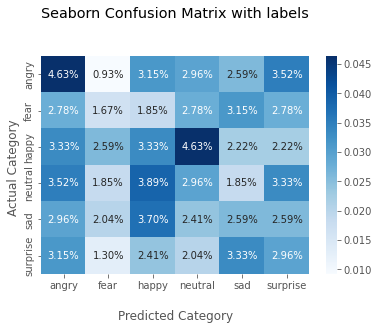

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline
plt.close('all')

# Get the confusion matrix
cf_matrix = confusion_matrix(test_labels, y_pred)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry','fear', 'happy', 'neutral', 'sad', 'surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()